In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from IPython.display import clear_output

Для проведения расчетов на GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Класс для реализации спектральной нормировки - метода, используемого при обучении GAN'ов для стабилизации обучения дискриминатора.

In [3]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

Класс для реализации модуля самовнимания

In [4]:
class Self_Attn(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        # Construct the module
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        m_batchsize,C,width ,height = x.size()
        
        proj_query  = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0,2,1) # B * N * C
        proj_key =  self.key_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        energy =  torch.bmm(proj_query, proj_key) # batch matrix-matrix product
        
        attention = self.softmax(energy) # B * N * N
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        out = torch.bmm(proj_value, attention.permute(0,2,1)) # batch matrix-matrix product
        out = out.view(m_batchsize,C,width,height) # B * C * W * H
        
        out = self.gamma*out + x
        return out

Функция для перевода OHE-представления выхода генератора в нормальное изображение

In [5]:
def create_image_from_array(color_array):
    color_map = {
        1: (255, 255, 255),  # белый
        0: (0, 0, 0),        # черный
        2: (255, 0, 0),      # красный
        3: (0, 0, 255)       # синий
    }
    array = np.array(color_array, dtype=np.uint8)
    height, width = array.shape
    image = Image.new('RGB', (width, height))
    pixels = image.load()
    for y in range(height):
        for x in range(width):
            pixels[x, y] = color_map[array[y, x]]
    return image

Формирование обучающего набора данных

In [10]:
data = []
for i in range(0, 29):
    path = r'C:\Users\Nick\Documents\CESAGAN\data\{0}.png'.format(i)
    img = Image.open(path).convert('L')
    img = np.array(img)/255
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] > 0. and img[i][j] < 1.0:
                if img[i][j] < 0.5:
                    img[i][j] = 2
                else:
                    img[i][j] = 3
    # ohe
    tmp = np.array(img.tolist(), dtype=np.int8)
    num_tile_types = 4  # Стена, дорога, старт, финиш
    one_hot_level = np.eye(num_tile_types)[tmp]  # Размер: (40, 28, num_tile_types)
    one_hot_level = one_hot_level.transpose(2, 0, 1) 
    # нормировка
    one_hot_level = 2 * one_hot_level - 1
    data.append(torch.tensor(one_hot_level, dtype=torch.float32))
data = torch.stack(data, dim=0)

In [12]:
data.shape

torch.Size([29, 4, 28, 40])

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim, out_dim):
        super(Generator, self).__init__()       
        self.seq = nn.Sequential(
            SpectralNorm(nn.ConvTranspose2d(z_dim, 512, kernel_size=(7,10), stride=1, padding=0, bias=False)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            SpectralNorm(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SpectralNorm(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            Self_Attn(128),
            nn.ConvTranspose2d(128, out_dim, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x): 
        return self.seq(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.seq = nn.Sequential(
            SpectralNorm(nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            Self_Attn(256),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=0),
        )

    def forward(self, x):
        return self.seq(x)

In [26]:
z_dim = 100 # размерность скрытого пространства
bs = data.shape[0] # размер батча обучения
d_step = 1 # шаг обучения дискриминатора
G = Generator(z_dim, 4).to(device)
D = Discriminator(4).to(device)
criterion = nn.BCELoss()  
#G_optimizer = optim.RMSprop(G.parameters(), lr = 0.0001)
#D_optimizer = optim.RMSprop(D.parameters(), lr = 0.0001)
G_optimizer = optim.Adam(G.parameters(), lr = 0.0001, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr = 0.0001, betas=(0.5, 0.999))

[0/200]: loss_d: 1.767, loss_g: 0.543


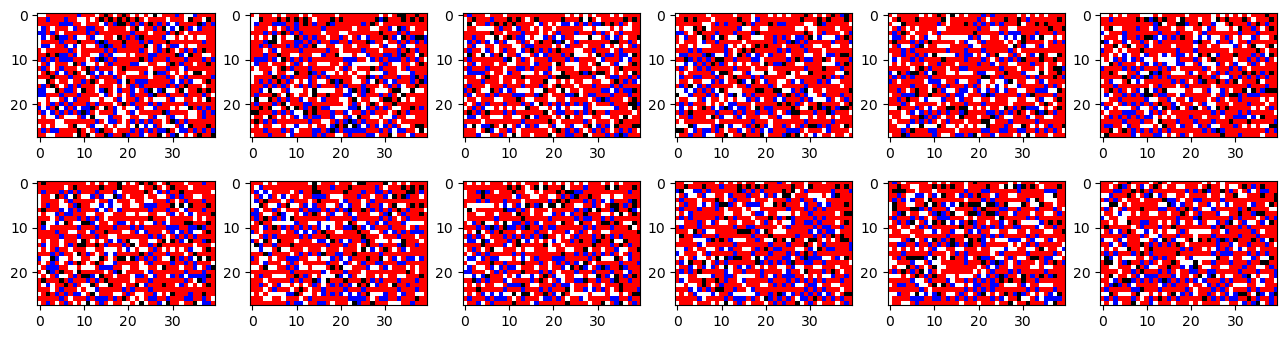

[1/200]: loss_d: 1.440, loss_g: 0.290
[2/200]: loss_d: 1.269, loss_g: 0.288
[3/200]: loss_d: 1.269, loss_g: 0.337
[4/200]: loss_d: 1.137, loss_g: 0.489
[5/200]: loss_d: 0.821, loss_g: 0.832
[6/200]: loss_d: 0.941, loss_g: 0.661
[7/200]: loss_d: 0.791, loss_g: 0.809
[8/200]: loss_d: 0.724, loss_g: 0.894
[9/200]: loss_d: 0.715, loss_g: 0.931
[10/200]: loss_d: 0.636, loss_g: 1.020
[11/200]: loss_d: 0.685, loss_g: 0.934
[12/200]: loss_d: 0.601, loss_g: 1.087
[13/200]: loss_d: 0.550, loss_g: 1.169
[14/200]: loss_d: 0.372, loss_g: 1.314
[15/200]: loss_d: 0.336, loss_g: 1.419
[16/200]: loss_d: 0.188, loss_g: 1.380
[17/200]: loss_d: 0.281, loss_g: 1.431
[18/200]: loss_d: 0.416, loss_g: 1.383
[19/200]: loss_d: 0.363, loss_g: 1.448
[20/200]: loss_d: 0.440, loss_g: 1.332
[21/200]: loss_d: 0.184, loss_g: 1.422
[22/200]: loss_d: 0.267, loss_g: 1.511
[23/200]: loss_d: 0.184, loss_g: 1.634
[24/200]: loss_d: 0.095, loss_g: 1.615
[25/200]: loss_d: 0.029, loss_g: 1.719
[26/200]: loss_d: 0.128, loss_g: 1

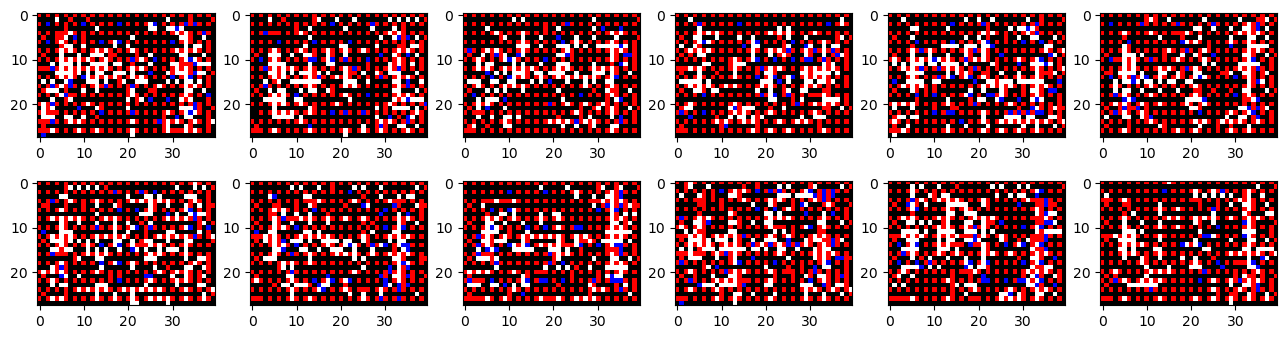

[101/200]: loss_d: 0.000, loss_g: 1.802
[102/200]: loss_d: 0.000, loss_g: 1.789
[103/200]: loss_d: 0.003, loss_g: 1.639
[104/200]: loss_d: 0.001, loss_g: 1.902
[105/200]: loss_d: 0.000, loss_g: 1.832
[106/200]: loss_d: 0.000, loss_g: 1.751
[107/200]: loss_d: 0.000, loss_g: 1.735
[108/200]: loss_d: 0.000, loss_g: 1.841
[109/200]: loss_d: 0.002, loss_g: 1.558
[110/200]: loss_d: 0.003, loss_g: 1.524
[111/200]: loss_d: 0.016, loss_g: 1.788
[112/200]: loss_d: 0.000, loss_g: 1.829
[113/200]: loss_d: 0.002, loss_g: 1.844
[114/200]: loss_d: 0.000, loss_g: 1.737
[115/200]: loss_d: 0.004, loss_g: 1.709
[116/200]: loss_d: 0.001, loss_g: 1.630
[117/200]: loss_d: 0.000, loss_g: 1.658
[118/200]: loss_d: 0.000, loss_g: 1.511
[119/200]: loss_d: 0.012, loss_g: 1.686
[120/200]: loss_d: 0.004, loss_g: 1.723
[121/200]: loss_d: 0.000, loss_g: 1.682
[122/200]: loss_d: 0.000, loss_g: 1.787
[123/200]: loss_d: 0.002, loss_g: 1.628
[124/200]: loss_d: 0.000, loss_g: 1.715
[125/200]: loss_d: 0.000, loss_g: 1.744


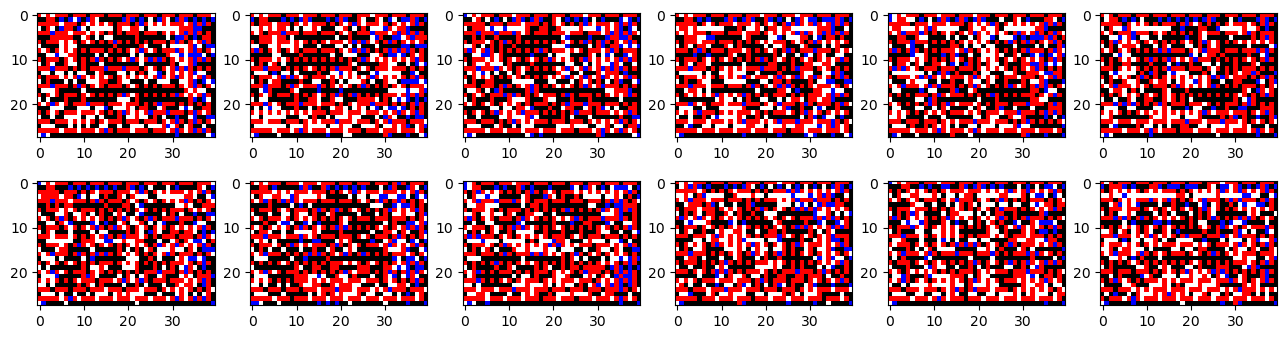

[201/200]: loss_d: 0.000, loss_g: 1.638
[202/200]: loss_d: 0.000, loss_g: 1.477
[203/200]: loss_d: 0.005, loss_g: 1.718
[204/200]: loss_d: 0.000, loss_g: 1.887
[205/200]: loss_d: 0.000, loss_g: 1.922
[206/200]: loss_d: 0.002, loss_g: 1.709
[207/200]: loss_d: 0.000, loss_g: 1.628
[208/200]: loss_d: 0.020, loss_g: 1.609
[209/200]: loss_d: 0.002, loss_g: 1.915
[210/200]: loss_d: 0.000, loss_g: 1.877
[211/200]: loss_d: 0.000, loss_g: 1.939
[212/200]: loss_d: 0.000, loss_g: 1.761
[213/200]: loss_d: 0.000, loss_g: 1.854
[214/200]: loss_d: 0.000, loss_g: 1.742
[215/200]: loss_d: 0.000, loss_g: 1.627
[216/200]: loss_d: 0.000, loss_g: 1.653
[217/200]: loss_d: 0.001, loss_g: 1.516
[218/200]: loss_d: 0.005, loss_g: 1.715
[219/200]: loss_d: 0.000, loss_g: 1.732
[220/200]: loss_d: 0.000, loss_g: 1.720
[221/200]: loss_d: 0.000, loss_g: 1.846
[222/200]: loss_d: 0.000, loss_g: 1.751
[223/200]: loss_d: 0.000, loss_g: 1.623
[224/200]: loss_d: 0.000, loss_g: 1.621
[225/200]: loss_d: 0.000, loss_g: 1.526


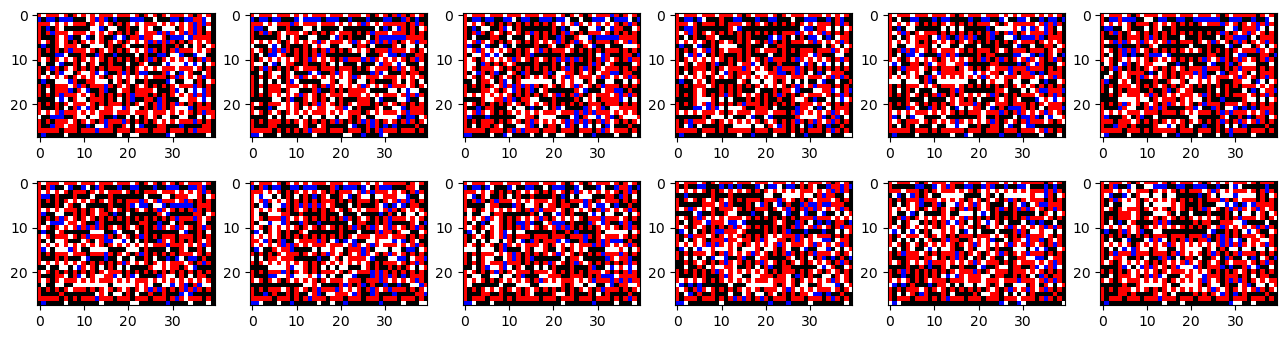

[301/200]: loss_d: 0.000, loss_g: 1.693
[302/200]: loss_d: 0.001, loss_g: 1.783
[303/200]: loss_d: 0.000, loss_g: 1.734
[304/200]: loss_d: 0.000, loss_g: 1.714
[305/200]: loss_d: 0.000, loss_g: 1.727
[306/200]: loss_d: 0.000, loss_g: 1.684
[307/200]: loss_d: 0.000, loss_g: 1.793
[308/200]: loss_d: 0.000, loss_g: 1.699
[309/200]: loss_d: 0.000, loss_g: 1.654
[310/200]: loss_d: 0.000, loss_g: 1.670
[311/200]: loss_d: 0.000, loss_g: 1.572
[312/200]: loss_d: 0.013, loss_g: 1.817
[313/200]: loss_d: 0.000, loss_g: 1.974
[314/200]: loss_d: 0.000, loss_g: 2.055
[315/200]: loss_d: 0.000, loss_g: 1.970
[316/200]: loss_d: 0.000, loss_g: 2.013
[317/200]: loss_d: 0.000, loss_g: 1.935
[318/200]: loss_d: 0.000, loss_g: 1.920
[319/200]: loss_d: 0.000, loss_g: 1.856
[320/200]: loss_d: 0.000, loss_g: 1.917
[321/200]: loss_d: 0.000, loss_g: 1.803
[322/200]: loss_d: 0.000, loss_g: 1.774
[323/200]: loss_d: 0.000, loss_g: 1.625
[324/200]: loss_d: 0.000, loss_g: 1.616
[325/200]: loss_d: 0.001, loss_g: 1.679


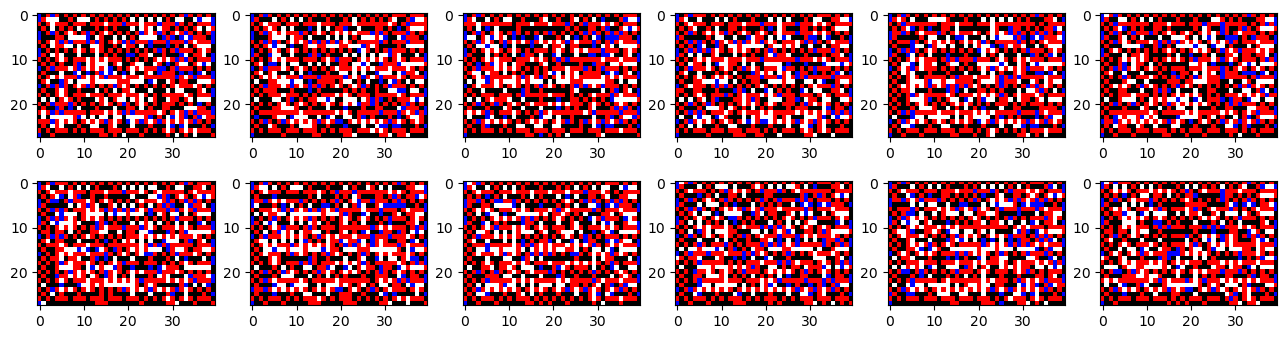

[401/200]: loss_d: 0.000, loss_g: 2.496
[402/200]: loss_d: 0.000, loss_g: 2.445
[403/200]: loss_d: 0.000, loss_g: 2.362
[404/200]: loss_d: 0.000, loss_g: 2.387
[405/200]: loss_d: 0.000, loss_g: 2.221
[406/200]: loss_d: 0.000, loss_g: 2.270
[407/200]: loss_d: 0.000, loss_g: 2.175
[408/200]: loss_d: 0.000, loss_g: 2.072
[409/200]: loss_d: 0.000, loss_g: 1.878
[410/200]: loss_d: 0.000, loss_g: 1.842
[411/200]: loss_d: 0.000, loss_g: 1.781
[412/200]: loss_d: 0.000, loss_g: 1.774
[413/200]: loss_d: 0.000, loss_g: 1.749
[414/200]: loss_d: 0.000, loss_g: 1.691
[415/200]: loss_d: 0.000, loss_g: 1.706
[416/200]: loss_d: 0.000, loss_g: 1.753
[417/200]: loss_d: 0.000, loss_g: 1.661
[418/200]: loss_d: 0.000, loss_g: 1.600
[419/200]: loss_d: 0.000, loss_g: 1.476
[420/200]: loss_d: 0.004, loss_g: 1.667
[421/200]: loss_d: 0.000, loss_g: 1.733
[422/200]: loss_d: 0.000, loss_g: 1.802
[423/200]: loss_d: 0.001, loss_g: 1.512
[424/200]: loss_d: 0.001, loss_g: 1.665
[425/200]: loss_d: 0.000, loss_g: 1.807


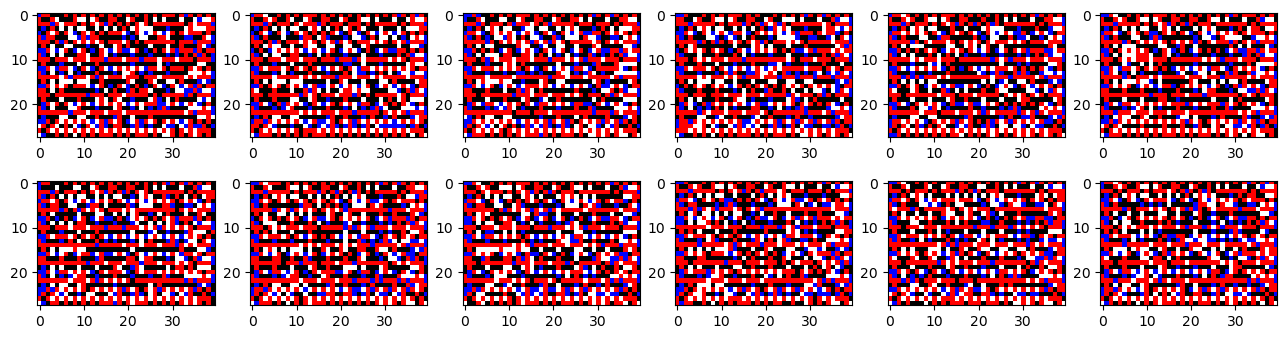

[501/200]: loss_d: 0.000, loss_g: 1.764
[502/200]: loss_d: 0.000, loss_g: 1.784
[503/200]: loss_d: 0.000, loss_g: 1.705
[504/200]: loss_d: 0.000, loss_g: 1.721
[505/200]: loss_d: 0.000, loss_g: 1.688
[506/200]: loss_d: 0.000, loss_g: 1.567
[507/200]: loss_d: 0.000, loss_g: 1.566
[508/200]: loss_d: 0.000, loss_g: 1.405
[509/200]: loss_d: 0.000, loss_g: 1.370
[510/200]: loss_d: 0.000, loss_g: 1.518
[511/200]: loss_d: 0.000, loss_g: 1.510
[512/200]: loss_d: 0.010, loss_g: 2.577
[513/200]: loss_d: 0.017, loss_g: 2.505
[514/200]: loss_d: 0.000, loss_g: 2.406
[515/200]: loss_d: 0.000, loss_g: 2.303
[516/200]: loss_d: 0.001, loss_g: 2.137
[517/200]: loss_d: 0.000, loss_g: 2.027
[518/200]: loss_d: 0.000, loss_g: 1.972
[519/200]: loss_d: 0.000, loss_g: 1.851
[520/200]: loss_d: 0.000, loss_g: 1.757
[521/200]: loss_d: 0.000, loss_g: 1.801
[522/200]: loss_d: 0.000, loss_g: 1.781
[523/200]: loss_d: 0.000, loss_g: 1.724
[524/200]: loss_d: 0.000, loss_g: 1.732
[525/200]: loss_d: 0.000, loss_g: 1.681


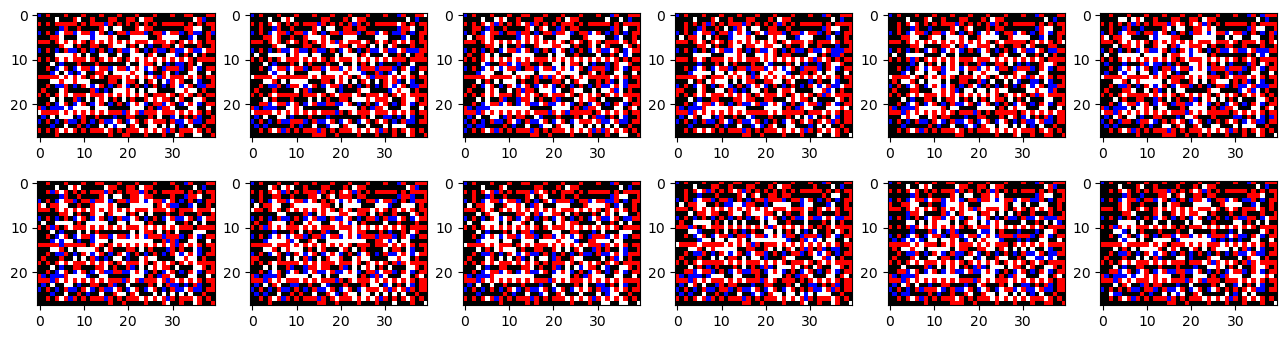

[601/200]: loss_d: 0.000, loss_g: 1.743
[602/200]: loss_d: 0.000, loss_g: 1.708
[603/200]: loss_d: 0.000, loss_g: 1.638
[604/200]: loss_d: 0.000, loss_g: 1.605
[605/200]: loss_d: 0.000, loss_g: 1.689
[606/200]: loss_d: 0.000, loss_g: 1.702
[607/200]: loss_d: 0.000, loss_g: 1.772
[608/200]: loss_d: 0.004, loss_g: 2.036
[609/200]: loss_d: 0.000, loss_g: 2.067
[610/200]: loss_d: 0.000, loss_g: 2.091
[611/200]: loss_d: 0.000, loss_g: 2.064
[612/200]: loss_d: 0.000, loss_g: 2.064
[613/200]: loss_d: 0.000, loss_g: 2.095
[614/200]: loss_d: 0.000, loss_g: 1.994
[615/200]: loss_d: 0.000, loss_g: 2.014
[616/200]: loss_d: 0.000, loss_g: 2.007
[617/200]: loss_d: 0.000, loss_g: 2.102
[618/200]: loss_d: 0.000, loss_g: 1.980
[619/200]: loss_d: 0.000, loss_g: 1.858
[620/200]: loss_d: 0.000, loss_g: 1.781
[621/200]: loss_d: 0.000, loss_g: 1.733
[622/200]: loss_d: 0.000, loss_g: 1.841
[623/200]: loss_d: 0.000, loss_g: 1.798
[624/200]: loss_d: 0.000, loss_g: 1.758
[625/200]: loss_d: 0.000, loss_g: 1.544


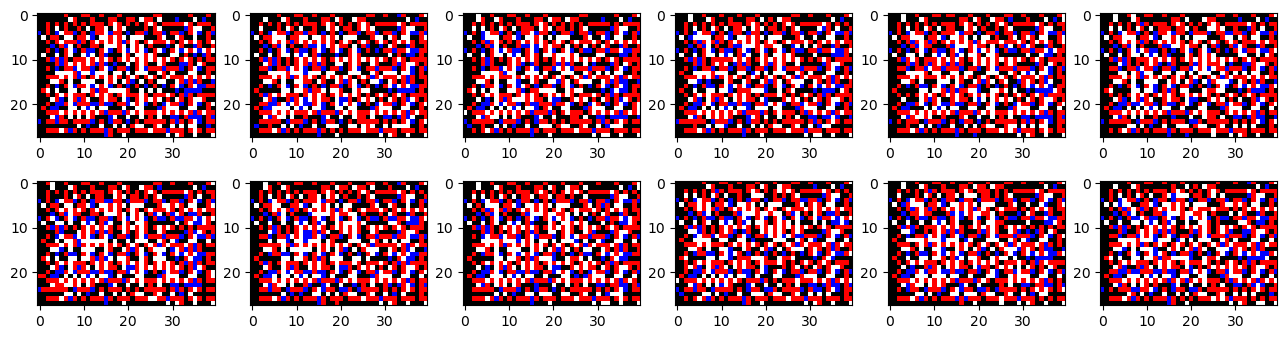

[701/200]: loss_d: 0.000, loss_g: 1.860
[702/200]: loss_d: 0.000, loss_g: 1.842
[703/200]: loss_d: 0.000, loss_g: 1.866
[704/200]: loss_d: 0.000, loss_g: 1.830
[705/200]: loss_d: 0.000, loss_g: 1.843
[706/200]: loss_d: 0.000, loss_g: 1.766
[707/200]: loss_d: 0.000, loss_g: 1.731
[708/200]: loss_d: 0.000, loss_g: 1.621
[709/200]: loss_d: 0.000, loss_g: 1.604
[710/200]: loss_d: 0.000, loss_g: 1.545
[711/200]: loss_d: 0.000, loss_g: 1.588
[712/200]: loss_d: 0.000, loss_g: 1.494
[713/200]: loss_d: 0.000, loss_g: 1.420
[714/200]: loss_d: 0.000, loss_g: 1.361
[715/200]: loss_d: 0.000, loss_g: 1.394
[716/200]: loss_d: 0.000, loss_g: 1.317
[717/200]: loss_d: 0.001, loss_g: 2.127
[718/200]: loss_d: 0.000, loss_g: 2.395
[719/200]: loss_d: 0.000, loss_g: 2.514
[720/200]: loss_d: 0.000, loss_g: 2.561
[721/200]: loss_d: 0.000, loss_g: 2.530
[722/200]: loss_d: 0.000, loss_g: 2.520
[723/200]: loss_d: 0.000, loss_g: 2.431
[724/200]: loss_d: 0.000, loss_g: 2.466
[725/200]: loss_d: 0.000, loss_g: 2.407


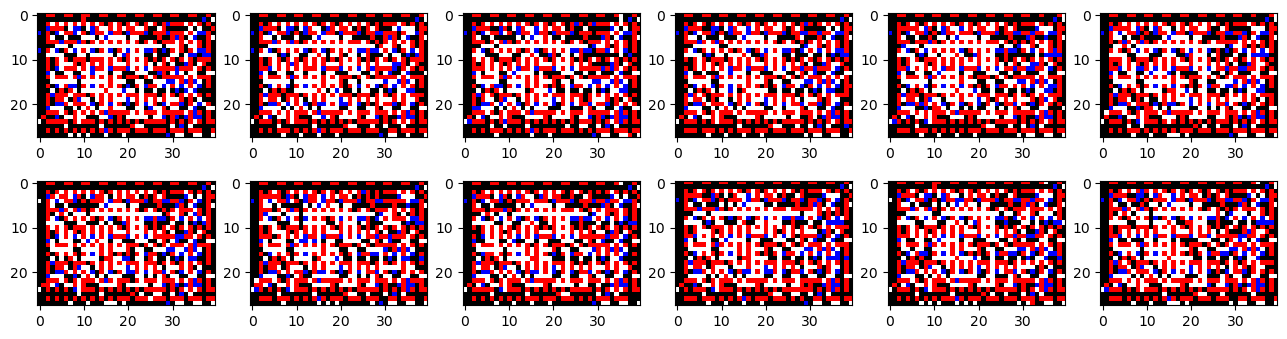

[801/200]: loss_d: 0.000, loss_g: 4.561
[802/200]: loss_d: 0.000, loss_g: 4.464
[803/200]: loss_d: 0.000, loss_g: 4.287
[804/200]: loss_d: 0.000, loss_g: 4.165
[805/200]: loss_d: 0.000, loss_g: 4.065
[806/200]: loss_d: 0.000, loss_g: 3.939
[807/200]: loss_d: 0.000, loss_g: 3.797
[808/200]: loss_d: 0.000, loss_g: 3.735
[809/200]: loss_d: 0.000, loss_g: 3.595
[810/200]: loss_d: 0.000, loss_g: 3.514
[811/200]: loss_d: 0.000, loss_g: 3.406
[812/200]: loss_d: 0.000, loss_g: 3.348
[813/200]: loss_d: 0.000, loss_g: 3.305
[814/200]: loss_d: 0.000, loss_g: 3.178
[815/200]: loss_d: 0.000, loss_g: 3.036
[816/200]: loss_d: 0.000, loss_g: 2.897
[817/200]: loss_d: 0.000, loss_g: 2.844
[818/200]: loss_d: 0.000, loss_g: 2.736
[819/200]: loss_d: 0.000, loss_g: 2.679
[820/200]: loss_d: 0.000, loss_g: 2.643
[821/200]: loss_d: 0.000, loss_g: 2.624
[822/200]: loss_d: 0.000, loss_g: 2.522
[823/200]: loss_d: 0.000, loss_g: 2.522
[824/200]: loss_d: 0.000, loss_g: 2.402
[825/200]: loss_d: 0.000, loss_g: 2.255


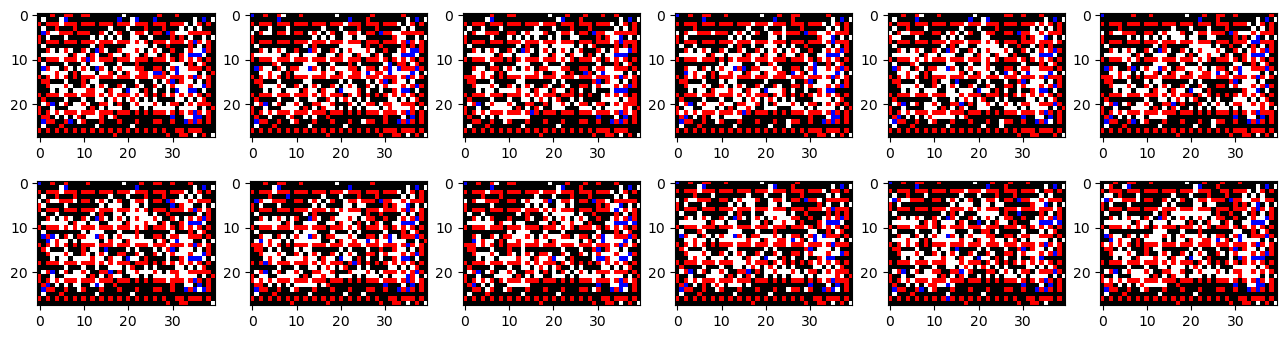

[901/200]: loss_d: 0.000, loss_g: 2.215
[902/200]: loss_d: 0.000, loss_g: 2.061
[903/200]: loss_d: 0.000, loss_g: 1.987
[904/200]: loss_d: 0.000, loss_g: 1.846
[905/200]: loss_d: 0.000, loss_g: 1.776
[906/200]: loss_d: 0.000, loss_g: 1.692
[907/200]: loss_d: 0.000, loss_g: 1.606
[908/200]: loss_d: 0.000, loss_g: 1.650
[909/200]: loss_d: 0.000, loss_g: 1.600
[910/200]: loss_d: 0.000, loss_g: 1.625
[911/200]: loss_d: 0.000, loss_g: 1.381
[912/200]: loss_d: 0.012, loss_g: 7.141
[913/200]: loss_d: 0.846, loss_g: 4.792
[914/200]: loss_d: 0.000, loss_g: 2.199
[915/200]: loss_d: 0.678, loss_g: 12.440
[916/200]: loss_d: 0.000, loss_g: 14.377
[917/200]: loss_d: 0.000, loss_g: 13.952
[918/200]: loss_d: 0.029, loss_g: 12.478
[919/200]: loss_d: 0.000, loss_g: 10.251
[920/200]: loss_d: 0.000, loss_g: 7.935
[921/200]: loss_d: 0.000, loss_g: 5.790
[922/200]: loss_d: 0.000, loss_g: 4.752
[923/200]: loss_d: 0.000, loss_g: 4.113
[924/200]: loss_d: 0.000, loss_g: 3.510
[925/200]: loss_d: 0.000, loss_g: 3

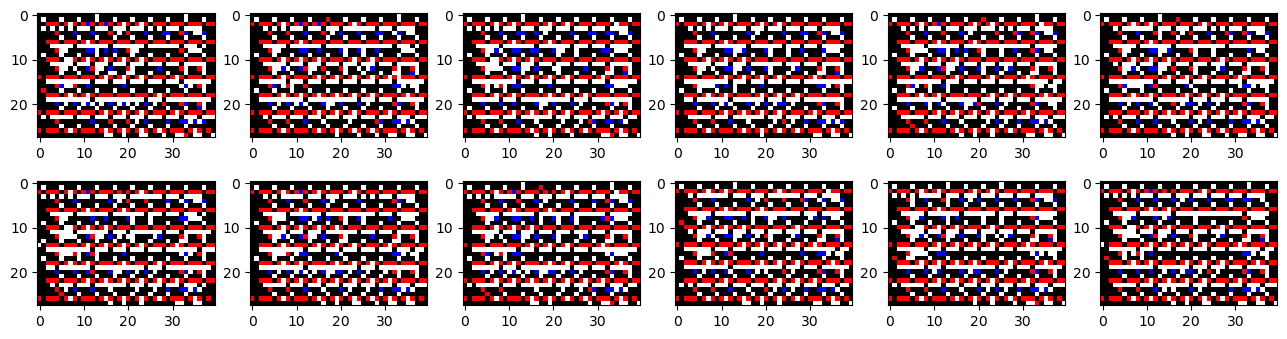

[1001/200]: loss_d: 0.000, loss_g: 8.133
[1002/200]: loss_d: 0.000, loss_g: 7.974
[1003/200]: loss_d: 0.000, loss_g: 7.872
[1004/200]: loss_d: 0.000, loss_g: 7.722
[1005/200]: loss_d: 0.000, loss_g: 7.628
[1006/200]: loss_d: 0.000, loss_g: 7.391
[1007/200]: loss_d: 0.000, loss_g: 7.269
[1008/200]: loss_d: 0.000, loss_g: 7.144
[1009/200]: loss_d: 0.000, loss_g: 6.999
[1010/200]: loss_d: 0.000, loss_g: 6.861
[1011/200]: loss_d: 0.000, loss_g: 6.767
[1012/200]: loss_d: 0.000, loss_g: 6.663
[1013/200]: loss_d: 0.000, loss_g: 6.523
[1014/200]: loss_d: 0.000, loss_g: 6.462
[1015/200]: loss_d: 0.000, loss_g: 6.297
[1016/200]: loss_d: 0.000, loss_g: 6.147
[1017/200]: loss_d: 0.000, loss_g: 6.043
[1018/200]: loss_d: 0.000, loss_g: 5.942
[1019/200]: loss_d: 0.000, loss_g: 5.877
[1020/200]: loss_d: 0.000, loss_g: 5.766
[1021/200]: loss_d: 0.000, loss_g: 5.717
[1022/200]: loss_d: 0.000, loss_g: 5.584
[1023/200]: loss_d: 0.000, loss_g: 5.489
[1024/200]: loss_d: 0.000, loss_g: 5.297
[1025/200]: loss

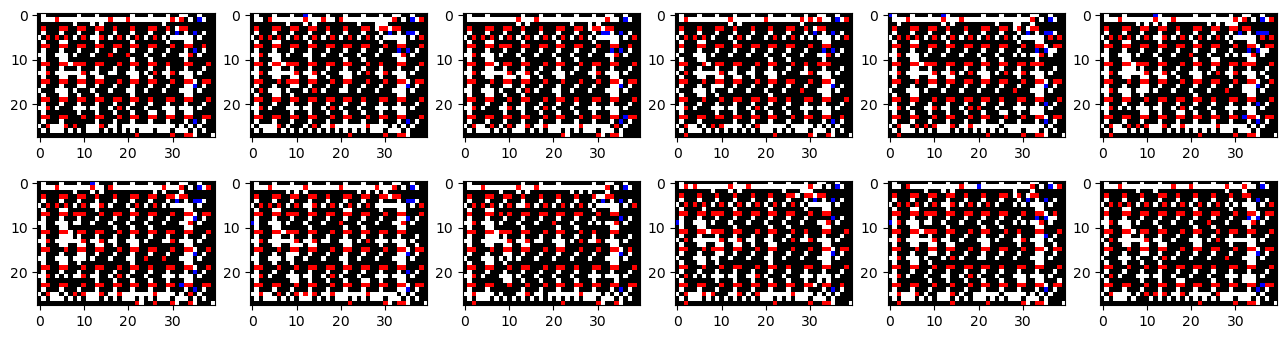

[1101/200]: loss_d: 0.000, loss_g: 2.862
[1102/200]: loss_d: 0.000, loss_g: 2.350
[1103/200]: loss_d: 0.000, loss_g: 1.727
[1104/200]: loss_d: 0.000, loss_g: 1.469
[1105/200]: loss_d: 0.000, loss_g: 1.724
[1106/200]: loss_d: 0.000, loss_g: 1.491
[1107/200]: loss_d: 0.273, loss_g: 13.859
[1108/200]: loss_d: 2.580, loss_g: 14.282
[1109/200]: loss_d: 0.016, loss_g: 13.681
[1110/200]: loss_d: 0.000, loss_g: 12.744
[1111/200]: loss_d: 0.000, loss_g: 11.756
[1112/200]: loss_d: 0.000, loss_g: 10.369
[1113/200]: loss_d: 0.000, loss_g: 8.705
[1114/200]: loss_d: 0.000, loss_g: 6.656
[1115/200]: loss_d: 0.000, loss_g: 4.693
[1116/200]: loss_d: 0.000, loss_g: 3.106
[1117/200]: loss_d: 0.000, loss_g: 1.285
[1118/200]: loss_d: 0.521, loss_g: 13.162
[1119/200]: loss_d: 0.000, loss_g: 15.185
[1120/200]: loss_d: 0.329, loss_g: 15.085
[1121/200]: loss_d: 0.000, loss_g: 14.531
[1122/200]: loss_d: 0.000, loss_g: 13.772
[1123/200]: loss_d: 0.000, loss_g: 12.894
[1124/200]: loss_d: 0.000, loss_g: 11.674
[11

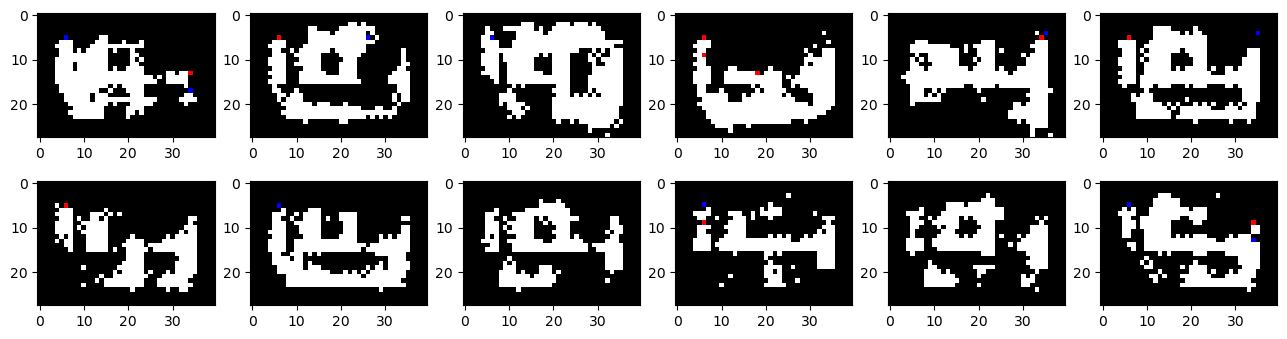

[1201/200]: loss_d: 0.114, loss_g: 3.209
[1202/200]: loss_d: 0.166, loss_g: 1.611
[1203/200]: loss_d: 0.323, loss_g: 3.398
[1204/200]: loss_d: 0.007, loss_g: 3.748
[1205/200]: loss_d: 0.037, loss_g: 3.134
[1206/200]: loss_d: 0.018, loss_g: 2.397
[1207/200]: loss_d: 0.036, loss_g: 2.625
[1208/200]: loss_d: 0.009, loss_g: 2.608
[1209/200]: loss_d: 0.027, loss_g: 2.401
[1210/200]: loss_d: 0.018, loss_g: 2.337
[1211/200]: loss_d: 0.062, loss_g: 3.540
[1212/200]: loss_d: 0.625, loss_g: 0.717
[1213/200]: loss_d: 0.506, loss_g: 4.145
[1214/200]: loss_d: 0.086, loss_g: 4.219
[1215/200]: loss_d: 0.060, loss_g: 3.116
[1216/200]: loss_d: 0.000, loss_g: 1.978
[1217/200]: loss_d: 0.114, loss_g: 3.014
[1218/200]: loss_d: 0.000, loss_g: 3.266
[1219/200]: loss_d: 0.002, loss_g: 2.920
[1220/200]: loss_d: 0.000, loss_g: 2.513
[1221/200]: loss_d: 0.000, loss_g: 2.058
[1222/200]: loss_d: 0.039, loss_g: 2.384
[1223/200]: loss_d: 0.005, loss_g: 2.218
[1224/200]: loss_d: 0.006, loss_g: 2.378
[1225/200]: loss

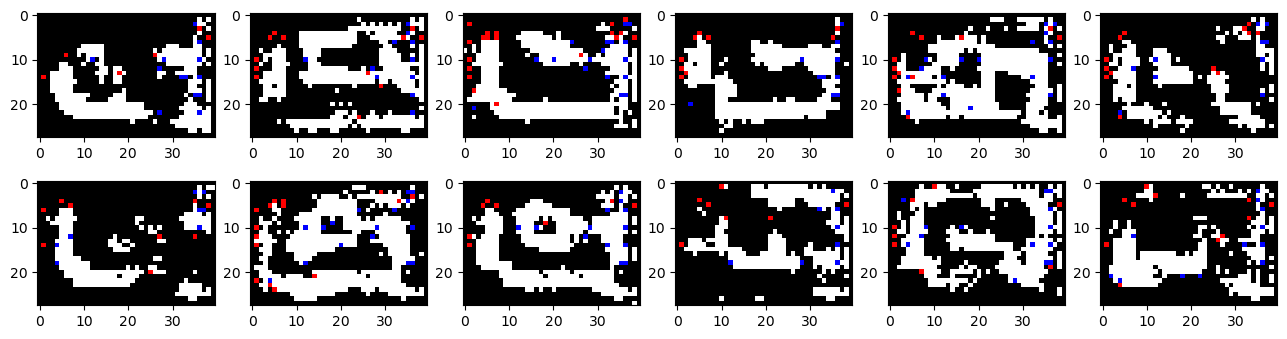

[1301/200]: loss_d: 0.007, loss_g: 2.270
[1302/200]: loss_d: 0.013, loss_g: 2.036
[1303/200]: loss_d: 0.014, loss_g: 2.040
[1304/200]: loss_d: 0.004, loss_g: 2.087
[1305/200]: loss_d: 0.015, loss_g: 1.944
[1306/200]: loss_d: 0.002, loss_g: 2.044
[1307/200]: loss_d: 0.002, loss_g: 1.818
[1308/200]: loss_d: 0.094, loss_g: 2.929
[1309/200]: loss_d: 0.277, loss_g: 0.880
[1310/200]: loss_d: 0.474, loss_g: 3.659
[1311/200]: loss_d: 0.098, loss_g: 3.579
[1312/200]: loss_d: 0.000, loss_g: 3.374
[1313/200]: loss_d: 0.000, loss_g: 3.193
[1314/200]: loss_d: 0.000, loss_g: 3.099
[1315/200]: loss_d: 0.000, loss_g: 2.852
[1316/200]: loss_d: 0.000, loss_g: 2.761
[1317/200]: loss_d: 0.000, loss_g: 2.675
[1318/200]: loss_d: 0.000, loss_g: 2.685
[1319/200]: loss_d: 0.000, loss_g: 2.676
[1320/200]: loss_d: 0.000, loss_g: 2.341
[1321/200]: loss_d: 0.002, loss_g: 2.158
[1322/200]: loss_d: 0.003, loss_g: 2.423
[1323/200]: loss_d: 0.000, loss_g: 2.130
[1324/200]: loss_d: 0.027, loss_g: 2.339
[1325/200]: loss

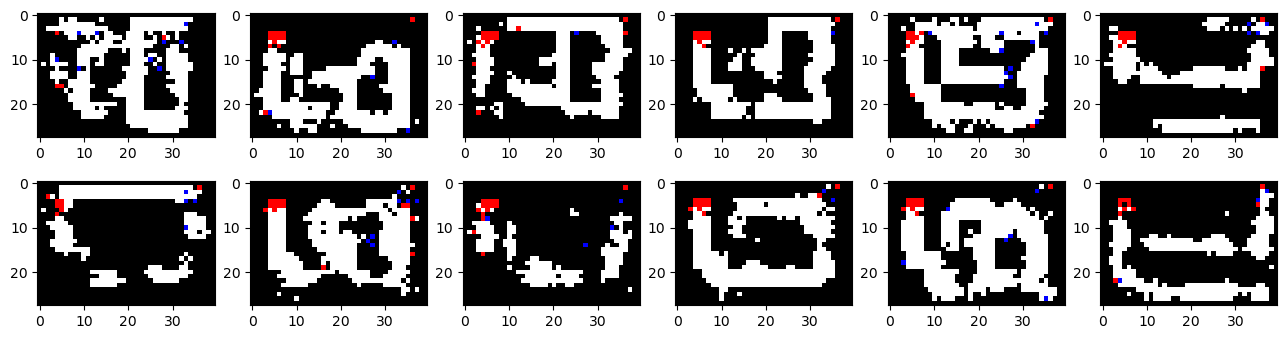

[1401/200]: loss_d: 0.001, loss_g: 1.956
[1402/200]: loss_d: 0.000, loss_g: 2.013
[1403/200]: loss_d: 0.004, loss_g: 1.892
[1404/200]: loss_d: 0.013, loss_g: 2.019
[1405/200]: loss_d: 0.016, loss_g: 1.983
[1406/200]: loss_d: 0.000, loss_g: 1.685
[1407/200]: loss_d: 0.031, loss_g: 2.169
[1408/200]: loss_d: 0.018, loss_g: 2.238
[1409/200]: loss_d: 0.000, loss_g: 2.095
[1410/200]: loss_d: 0.000, loss_g: 1.888
[1411/200]: loss_d: 0.007, loss_g: 2.193
[1412/200]: loss_d: 0.000, loss_g: 2.416
[1413/200]: loss_d: 0.000, loss_g: 2.553
[1414/200]: loss_d: 0.000, loss_g: 2.414
[1415/200]: loss_d: 0.000, loss_g: 2.263
[1416/200]: loss_d: 0.000, loss_g: 2.057
[1417/200]: loss_d: 0.000, loss_g: 2.141
[1418/200]: loss_d: 0.000, loss_g: 1.928
[1419/200]: loss_d: 0.000, loss_g: 1.966
[1420/200]: loss_d: 0.002, loss_g: 2.081
[1421/200]: loss_d: 0.010, loss_g: 1.866
[1422/200]: loss_d: 0.007, loss_g: 1.931
[1423/200]: loss_d: 0.000, loss_g: 1.871
[1424/200]: loss_d: 0.008, loss_g: 2.431
[1425/200]: loss

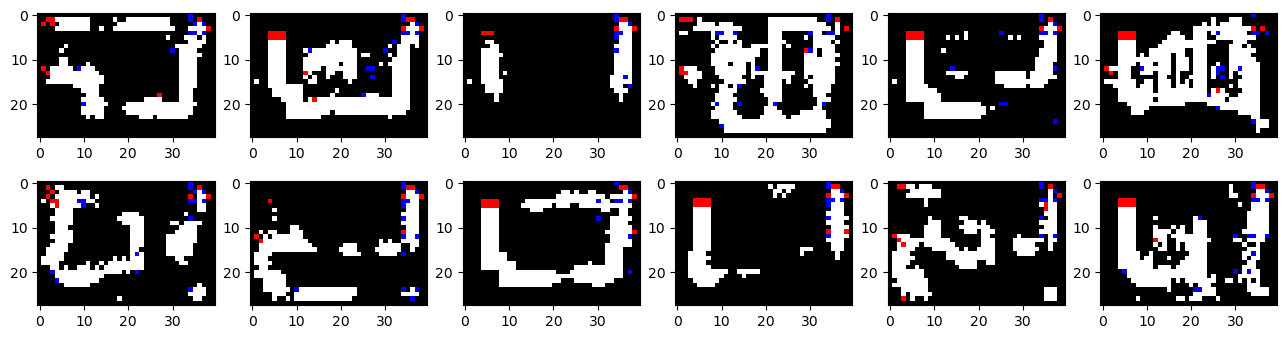

[1501/200]: loss_d: 0.000, loss_g: 2.066
[1502/200]: loss_d: 0.000, loss_g: 1.979
[1503/200]: loss_d: 0.003, loss_g: 2.348
[1504/200]: loss_d: 0.004, loss_g: 2.467
[1505/200]: loss_d: 0.011, loss_g: 1.921
[1506/200]: loss_d: 0.009, loss_g: 2.163
[1507/200]: loss_d: 0.000, loss_g: 2.215
[1508/200]: loss_d: 0.025, loss_g: 2.272
[1509/200]: loss_d: 0.018, loss_g: 2.233
[1510/200]: loss_d: 0.013, loss_g: 2.233
[1511/200]: loss_d: 0.008, loss_g: 2.306
[1512/200]: loss_d: 0.000, loss_g: 2.037
[1513/200]: loss_d: 0.012, loss_g: 2.200
[1514/200]: loss_d: 0.011, loss_g: 2.198
[1515/200]: loss_d: 0.000, loss_g: 2.005
[1516/200]: loss_d: 0.001, loss_g: 1.843
[1517/200]: loss_d: 0.039, loss_g: 2.404
[1518/200]: loss_d: 0.030, loss_g: 1.731
[1519/200]: loss_d: 0.017, loss_g: 2.080
[1520/200]: loss_d: 0.012, loss_g: 2.296
[1521/200]: loss_d: 0.050, loss_g: 2.280
[1522/200]: loss_d: 0.001, loss_g: 2.473
[1523/200]: loss_d: 0.000, loss_g: 2.310
[1524/200]: loss_d: 0.000, loss_g: 2.501
[1525/200]: loss

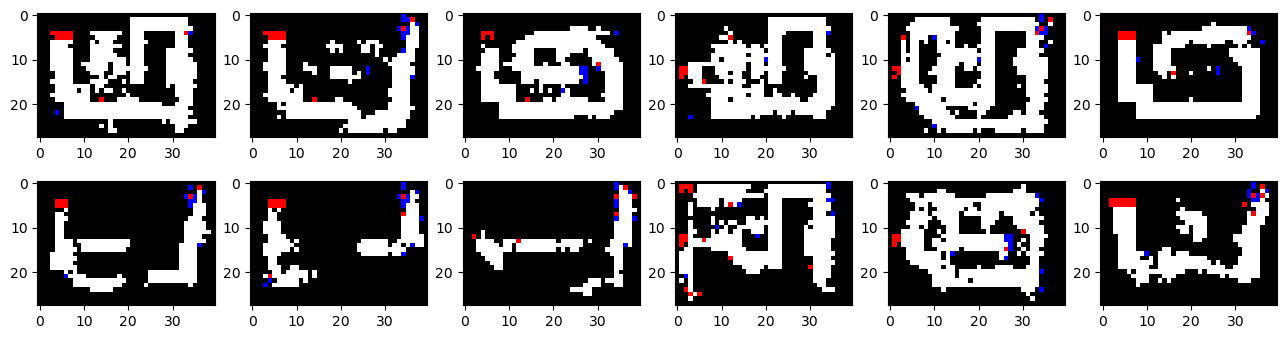

[1601/200]: loss_d: 0.020, loss_g: 2.192
[1602/200]: loss_d: 0.020, loss_g: 1.962
[1603/200]: loss_d: 0.004, loss_g: 1.798
[1604/200]: loss_d: 0.023, loss_g: 2.057
[1605/200]: loss_d: 0.012, loss_g: 2.427
[1606/200]: loss_d: 0.042, loss_g: 1.753
[1607/200]: loss_d: 0.029, loss_g: 2.110
[1608/200]: loss_d: 0.012, loss_g: 2.435
[1609/200]: loss_d: 0.000, loss_g: 2.414
[1610/200]: loss_d: 0.001, loss_g: 2.085
[1611/200]: loss_d: 0.003, loss_g: 2.427
[1612/200]: loss_d: 0.000, loss_g: 2.474
[1613/200]: loss_d: 0.000, loss_g: 2.148
[1614/200]: loss_d: 0.002, loss_g: 1.902
[1615/200]: loss_d: 0.026, loss_g: 2.131
[1616/200]: loss_d: 0.000, loss_g: 1.939
[1617/200]: loss_d: 0.004, loss_g: 2.127
[1618/200]: loss_d: 0.009, loss_g: 2.002
[1619/200]: loss_d: 0.000, loss_g: 2.289
[1620/200]: loss_d: 0.000, loss_g: 2.492
[1621/200]: loss_d: 0.000, loss_g: 2.113
[1622/200]: loss_d: 0.000, loss_g: 2.290
[1623/200]: loss_d: 0.000, loss_g: 2.209
[1624/200]: loss_d: 0.000, loss_g: 2.591
[1625/200]: loss

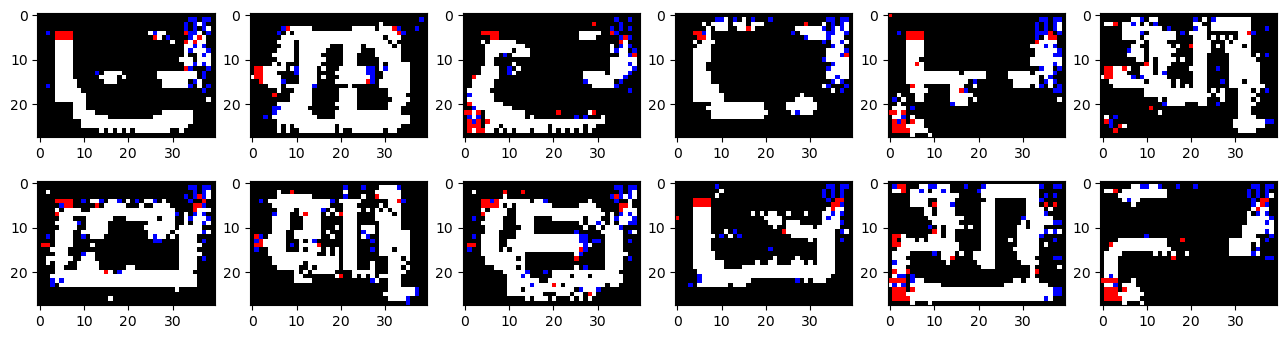

[1701/200]: loss_d: 0.007, loss_g: 1.653
[1702/200]: loss_d: 0.000, loss_g: 1.695
[1703/200]: loss_d: 0.000, loss_g: 1.902
[1704/200]: loss_d: 0.001, loss_g: 2.082
[1705/200]: loss_d: 0.024, loss_g: 2.632
[1706/200]: loss_d: 0.039, loss_g: 2.061
[1707/200]: loss_d: 0.043, loss_g: 1.911
[1708/200]: loss_d: 0.004, loss_g: 2.202
[1709/200]: loss_d: 0.005, loss_g: 2.554
[1710/200]: loss_d: 0.000, loss_g: 2.609
[1711/200]: loss_d: 0.004, loss_g: 2.005
[1712/200]: loss_d: 0.000, loss_g: 2.047
[1713/200]: loss_d: 0.007, loss_g: 2.024
[1714/200]: loss_d: 0.026, loss_g: 2.236
[1715/200]: loss_d: 0.000, loss_g: 2.482
[1716/200]: loss_d: 0.005, loss_g: 2.251
[1717/200]: loss_d: 0.000, loss_g: 2.005
[1718/200]: loss_d: 0.000, loss_g: 2.171
[1719/200]: loss_d: 0.000, loss_g: 2.402
[1720/200]: loss_d: 0.003, loss_g: 2.345
[1721/200]: loss_d: 0.000, loss_g: 2.365
[1722/200]: loss_d: 0.000, loss_g: 2.239
[1723/200]: loss_d: 0.000, loss_g: 2.419
[1724/200]: loss_d: 0.000, loss_g: 1.899
[1725/200]: loss

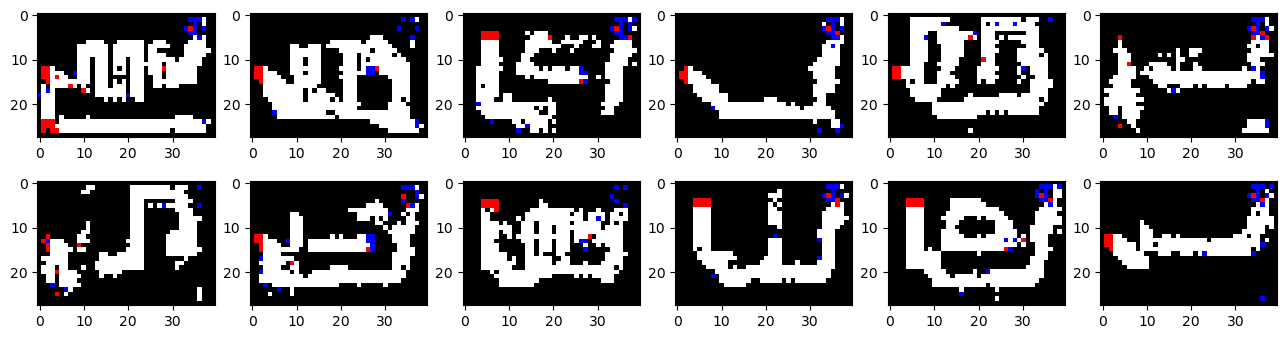

[1801/200]: loss_d: 0.005, loss_g: 2.221
[1802/200]: loss_d: 0.000, loss_g: 2.046
[1803/200]: loss_d: 0.023, loss_g: 2.528
[1804/200]: loss_d: 0.000, loss_g: 2.634
[1805/200]: loss_d: 0.077, loss_g: 2.300
[1806/200]: loss_d: 0.000, loss_g: 1.683
[1807/200]: loss_d: 0.066, loss_g: 2.126
[1808/200]: loss_d: 0.004, loss_g: 2.758
[1809/200]: loss_d: 0.055, loss_g: 2.251
[1810/200]: loss_d: 0.000, loss_g: 2.010
[1811/200]: loss_d: 0.004, loss_g: 2.190
[1812/200]: loss_d: 0.000, loss_g: 2.477
[1813/200]: loss_d: 0.000, loss_g: 2.376
[1814/200]: loss_d: 0.000, loss_g: 2.463
[1815/200]: loss_d: 0.000, loss_g: 2.269
[1816/200]: loss_d: 0.000, loss_g: 2.306
[1817/200]: loss_d: 0.000, loss_g: 2.305
[1818/200]: loss_d: 0.000, loss_g: 2.090
[1819/200]: loss_d: 0.000, loss_g: 2.236
[1820/200]: loss_d: 0.020, loss_g: 2.380
[1821/200]: loss_d: 0.018, loss_g: 1.992
[1822/200]: loss_d: 0.000, loss_g: 2.083
[1823/200]: loss_d: 0.009, loss_g: 1.869
[1824/200]: loss_d: 0.000, loss_g: 2.124
[1825/200]: loss

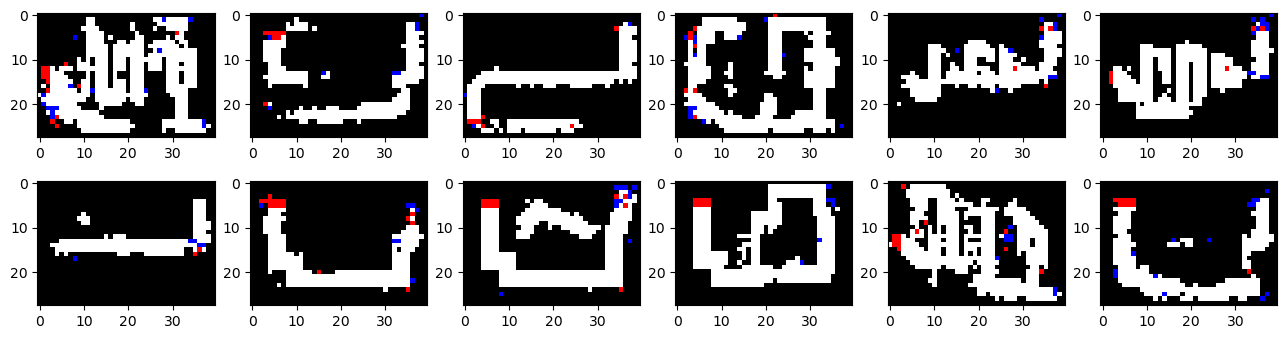

[1901/200]: loss_d: 0.000, loss_g: 2.224
[1902/200]: loss_d: 0.000, loss_g: 2.095
[1903/200]: loss_d: 0.000, loss_g: 2.055
[1904/200]: loss_d: 0.004, loss_g: 2.054
[1905/200]: loss_d: 0.000, loss_g: 2.529
[1906/200]: loss_d: 0.000, loss_g: 2.419
[1907/200]: loss_d: 0.000, loss_g: 2.567
[1908/200]: loss_d: 0.000, loss_g: 2.229
[1909/200]: loss_d: 0.001, loss_g: 2.322
[1910/200]: loss_d: 0.000, loss_g: 1.821
[1911/200]: loss_d: 0.028, loss_g: 3.170
[1912/200]: loss_d: 0.308, loss_g: 0.468
[1913/200]: loss_d: 0.783, loss_g: 4.674
[1914/200]: loss_d: 0.882, loss_g: 1.909
[1915/200]: loss_d: 0.045, loss_g: 1.765
[1916/200]: loss_d: 0.108, loss_g: 2.408
[1917/200]: loss_d: 0.039, loss_g: 2.190
[1918/200]: loss_d: 0.003, loss_g: 1.874
[1919/200]: loss_d: 0.088, loss_g: 2.701
[1920/200]: loss_d: 0.009, loss_g: 2.968
[1921/200]: loss_d: 0.021, loss_g: 1.704
[1922/200]: loss_d: 0.040, loss_g: 1.967
[1923/200]: loss_d: 0.004, loss_g: 2.304
[1924/200]: loss_d: 0.000, loss_g: 2.598
[1925/200]: loss

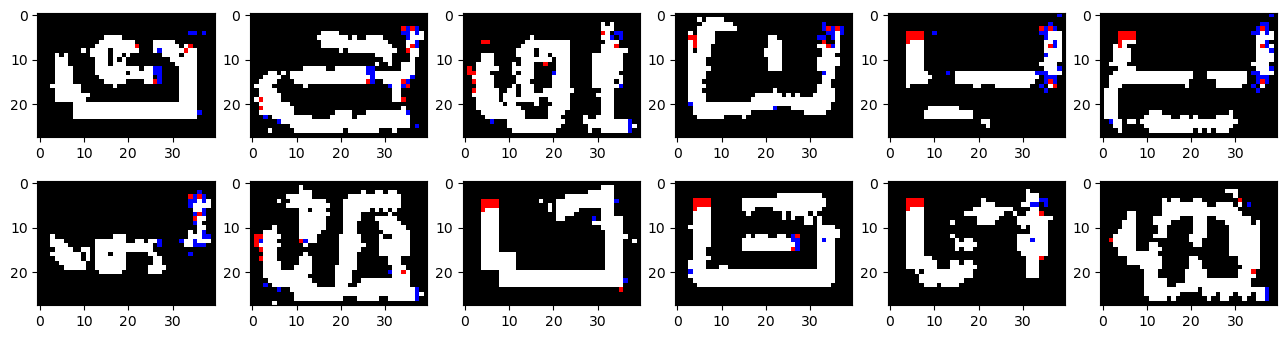

[2001/200]: loss_d: 0.000, loss_g: 2.024
[2002/200]: loss_d: 0.000, loss_g: 1.984
[2003/200]: loss_d: 0.003, loss_g: 2.265
[2004/200]: loss_d: 0.007, loss_g: 2.079
[2005/200]: loss_d: 0.000, loss_g: 2.130
[2006/200]: loss_d: 0.000, loss_g: 2.134
[2007/200]: loss_d: 0.000, loss_g: 2.080
[2008/200]: loss_d: 0.000, loss_g: 2.033
[2009/200]: loss_d: 0.037, loss_g: 2.413
[2010/200]: loss_d: 0.013, loss_g: 2.698
[2011/200]: loss_d: 0.008, loss_g: 2.225
[2012/200]: loss_d: 0.000, loss_g: 2.359
[2013/200]: loss_d: 0.000, loss_g: 2.496
[2014/200]: loss_d: 0.000, loss_g: 2.829
[2015/200]: loss_d: 0.000, loss_g: 2.308
[2016/200]: loss_d: 0.000, loss_g: 2.284
[2017/200]: loss_d: 0.000, loss_g: 2.297
[2018/200]: loss_d: 0.000, loss_g: 2.462
[2019/200]: loss_d: 0.000, loss_g: 2.230
[2020/200]: loss_d: 0.000, loss_g: 2.388
[2021/200]: loss_d: 0.000, loss_g: 2.435
[2022/200]: loss_d: 0.000, loss_g: 2.510
[2023/200]: loss_d: 0.000, loss_g: 2.417
[2024/200]: loss_d: 0.000, loss_g: 2.103
[2025/200]: loss

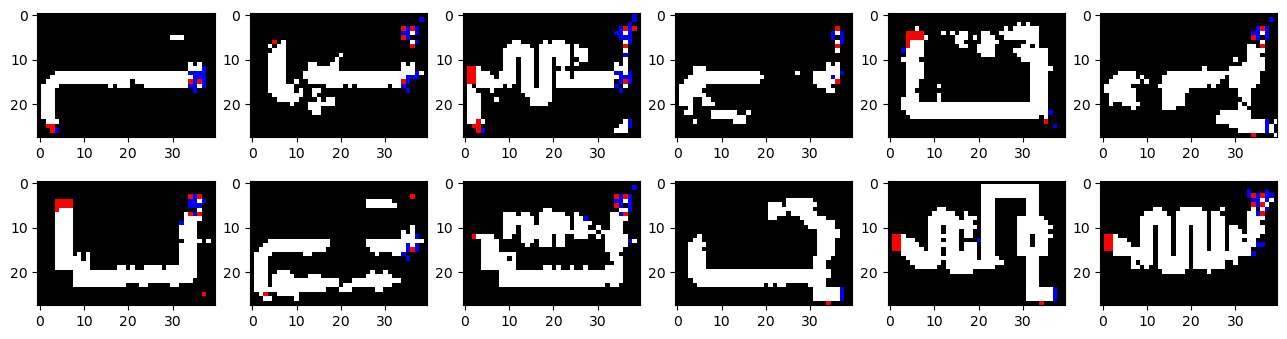

[2101/200]: loss_d: 0.000, loss_g: 3.268
[2102/200]: loss_d: 0.003, loss_g: 2.693
[2103/200]: loss_d: 0.000, loss_g: 2.720
[2104/200]: loss_d: 0.005, loss_g: 2.739
[2105/200]: loss_d: 0.000, loss_g: 3.067
[2106/200]: loss_d: 0.000, loss_g: 2.897
[2107/200]: loss_d: 0.000, loss_g: 2.826
[2108/200]: loss_d: 0.000, loss_g: 2.910
[2109/200]: loss_d: 0.000, loss_g: 2.618
[2110/200]: loss_d: 0.000, loss_g: 2.993
[2111/200]: loss_d: 0.000, loss_g: 2.974
[2112/200]: loss_d: 0.000, loss_g: 2.891
[2113/200]: loss_d: 0.000, loss_g: 2.751
[2114/200]: loss_d: 0.010, loss_g: 2.617
[2115/200]: loss_d: 0.000, loss_g: 3.076
[2116/200]: loss_d: 0.002, loss_g: 2.502
[2117/200]: loss_d: 0.008, loss_g: 2.436
[2118/200]: loss_d: 0.000, loss_g: 2.699
[2119/200]: loss_d: 0.008, loss_g: 2.912
[2120/200]: loss_d: 0.010, loss_g: 2.706
[2121/200]: loss_d: 0.000, loss_g: 2.570
[2122/200]: loss_d: 0.004, loss_g: 2.351
[2123/200]: loss_d: 0.000, loss_g: 2.431
[2124/200]: loss_d: 0.000, loss_g: 2.493
[2125/200]: loss

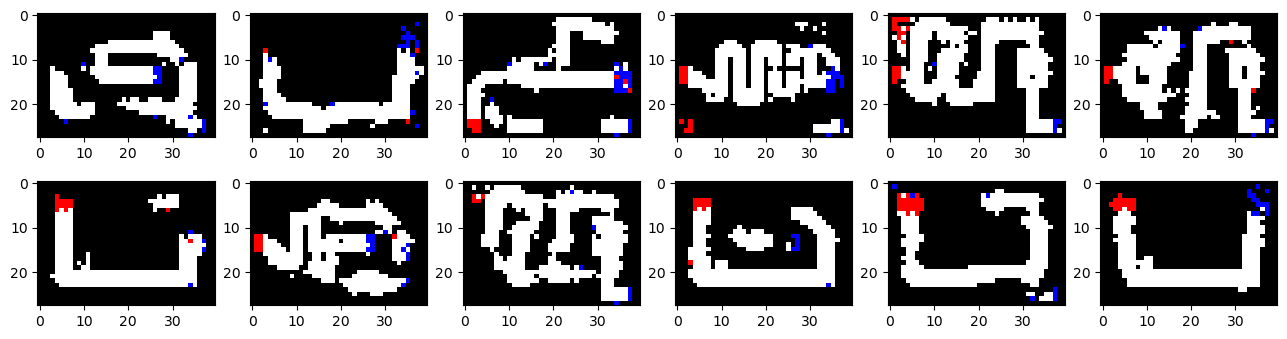

[2201/200]: loss_d: 0.000, loss_g: 2.681
[2202/200]: loss_d: 0.000, loss_g: 2.608
[2203/200]: loss_d: 0.000, loss_g: 2.441
[2204/200]: loss_d: 0.000, loss_g: 2.544
[2205/200]: loss_d: 0.000, loss_g: 2.256
[2206/200]: loss_d: 0.000, loss_g: 2.456
[2207/200]: loss_d: 0.000, loss_g: 2.407
[2208/200]: loss_d: 0.000, loss_g: 2.633
[2209/200]: loss_d: 0.000, loss_g: 2.658
[2210/200]: loss_d: 0.000, loss_g: 2.570
[2211/200]: loss_d: 0.000, loss_g: 2.860
[2212/200]: loss_d: 0.000, loss_g: 2.386
[2213/200]: loss_d: 0.000, loss_g: 2.526
[2214/200]: loss_d: 0.007, loss_g: 2.438
[2215/200]: loss_d: 0.000, loss_g: 2.511
[2216/200]: loss_d: 0.000, loss_g: 3.109
[2217/200]: loss_d: 0.005, loss_g: 2.660
[2218/200]: loss_d: 0.000, loss_g: 2.905
[2219/200]: loss_d: 0.001, loss_g: 2.442
[2220/200]: loss_d: 0.000, loss_g: 2.684
[2221/200]: loss_d: 0.000, loss_g: 2.791
[2222/200]: loss_d: 0.004, loss_g: 2.423
[2223/200]: loss_d: 0.000, loss_g: 2.350
[2224/200]: loss_d: 0.000, loss_g: 1.935
[2225/200]: loss

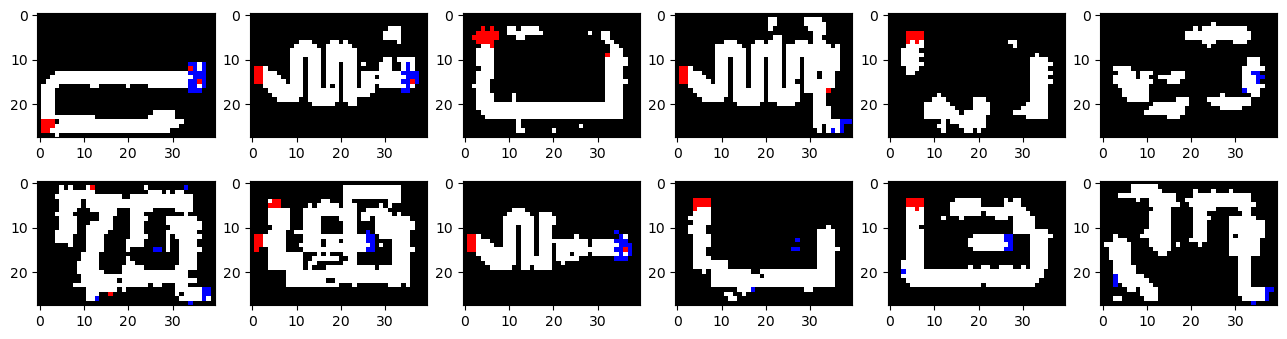

[2301/200]: loss_d: 0.003, loss_g: 2.947
[2302/200]: loss_d: 0.000, loss_g: 3.018
[2303/200]: loss_d: 0.000, loss_g: 3.032
[2304/200]: loss_d: 0.000, loss_g: 3.199
[2305/200]: loss_d: 0.000, loss_g: 2.651
[2306/200]: loss_d: 0.000, loss_g: 2.868
[2307/200]: loss_d: 0.000, loss_g: 2.991
[2308/200]: loss_d: 0.000, loss_g: 2.632
[2309/200]: loss_d: 0.000, loss_g: 2.414
[2310/200]: loss_d: 0.000, loss_g: 2.656
[2311/200]: loss_d: 0.000, loss_g: 2.611
[2312/200]: loss_d: 0.000, loss_g: 2.837
[2313/200]: loss_d: 0.000, loss_g: 2.726
[2314/200]: loss_d: 0.000, loss_g: 2.668
[2315/200]: loss_d: 0.000, loss_g: 3.094
[2316/200]: loss_d: 0.000, loss_g: 2.979
[2317/200]: loss_d: 0.000, loss_g: 2.838
[2318/200]: loss_d: 0.000, loss_g: 2.837
[2319/200]: loss_d: 0.000, loss_g: 3.019
[2320/200]: loss_d: 0.000, loss_g: 2.966
[2321/200]: loss_d: 0.000, loss_g: 3.365
[2322/200]: loss_d: 0.000, loss_g: 3.016
[2323/200]: loss_d: 0.000, loss_g: 2.568
[2324/200]: loss_d: 0.000, loss_g: 3.056
[2325/200]: loss

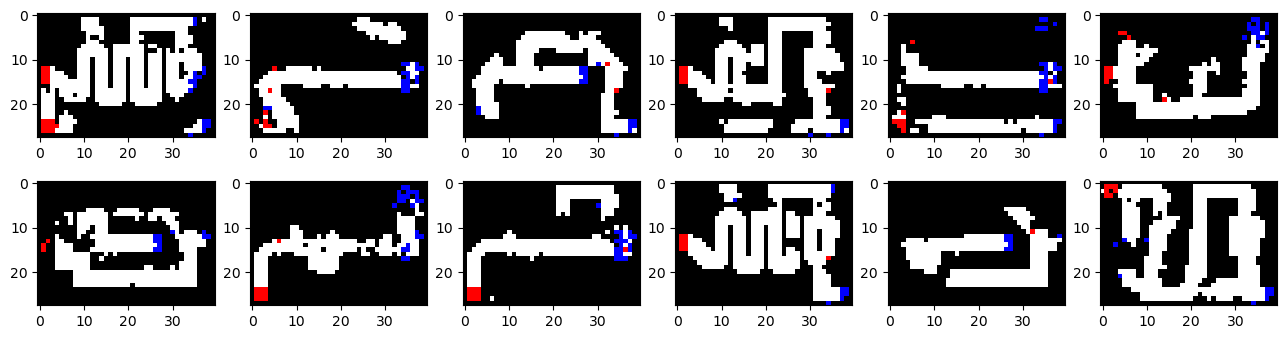

[2401/200]: loss_d: 0.000, loss_g: 3.126
[2402/200]: loss_d: 0.000, loss_g: 3.346
[2403/200]: loss_d: 0.000, loss_g: 3.305
[2404/200]: loss_d: 0.000, loss_g: 3.323
[2405/200]: loss_d: 0.000, loss_g: 2.859
[2406/200]: loss_d: 0.000, loss_g: 2.924
[2407/200]: loss_d: 0.000, loss_g: 2.784
[2408/200]: loss_d: 0.000, loss_g: 2.874
[2409/200]: loss_d: 0.000, loss_g: 2.694
[2410/200]: loss_d: 0.000, loss_g: 2.657
[2411/200]: loss_d: 0.000, loss_g: 2.968
[2412/200]: loss_d: 0.000, loss_g: 2.974
[2413/200]: loss_d: 0.000, loss_g: 2.866
[2414/200]: loss_d: 0.000, loss_g: 2.854
[2415/200]: loss_d: 0.000, loss_g: 2.822
[2416/200]: loss_d: 0.000, loss_g: 2.649
[2417/200]: loss_d: 0.000, loss_g: 2.788
[2418/200]: loss_d: 0.000, loss_g: 2.356
[2419/200]: loss_d: 0.000, loss_g: 2.431
[2420/200]: loss_d: 0.000, loss_g: 2.586
[2421/200]: loss_d: 0.000, loss_g: 2.336
[2422/200]: loss_d: 0.000, loss_g: 2.398
[2423/200]: loss_d: 0.000, loss_g: 2.419
[2424/200]: loss_d: 0.000, loss_g: 2.592
[2425/200]: loss

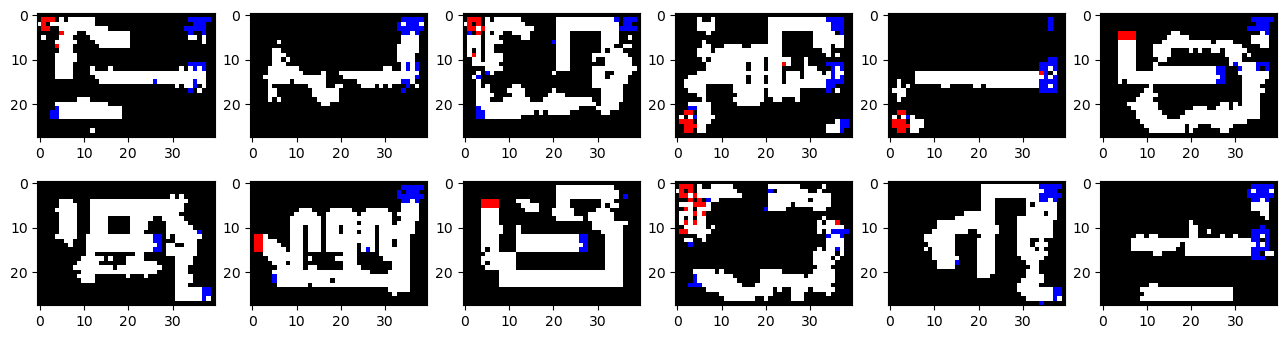

[2501/200]: loss_d: 0.000, loss_g: 2.529
[2502/200]: loss_d: 0.000, loss_g: 2.378
[2503/200]: loss_d: 0.000, loss_g: 2.696
[2504/200]: loss_d: 0.000, loss_g: 2.451
[2505/200]: loss_d: 0.000, loss_g: 2.108
[2506/200]: loss_d: 0.000, loss_g: 2.471
[2507/200]: loss_d: 0.000, loss_g: 2.535
[2508/200]: loss_d: 0.000, loss_g: 2.439
[2509/200]: loss_d: 0.000, loss_g: 2.766
[2510/200]: loss_d: 0.000, loss_g: 2.206
[2511/200]: loss_d: 0.000, loss_g: 2.709
[2512/200]: loss_d: 0.000, loss_g: 2.678
[2513/200]: loss_d: 0.000, loss_g: 2.589
[2514/200]: loss_d: 0.000, loss_g: 2.352
[2515/200]: loss_d: 0.000, loss_g: 2.359
[2516/200]: loss_d: 0.000, loss_g: 2.247
[2517/200]: loss_d: 0.000, loss_g: 2.732
[2518/200]: loss_d: 0.000, loss_g: 2.521
[2519/200]: loss_d: 0.001, loss_g: 2.473
[2520/200]: loss_d: 0.004, loss_g: 2.691
[2521/200]: loss_d: 0.000, loss_g: 2.868
[2522/200]: loss_d: 0.020, loss_g: 2.518
[2523/200]: loss_d: 0.000, loss_g: 2.552
[2524/200]: loss_d: 0.000, loss_g: 2.840
[2525/200]: loss

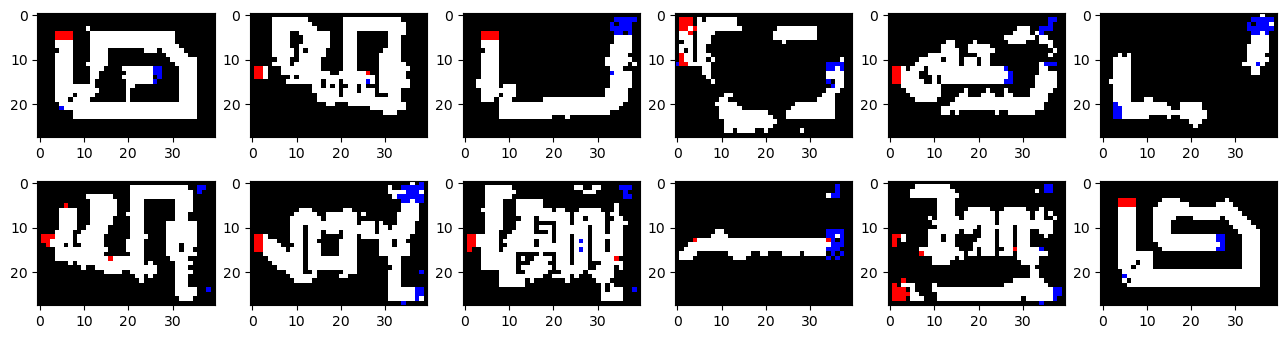

[2601/200]: loss_d: 0.000, loss_g: 2.811
[2602/200]: loss_d: 0.000, loss_g: 2.874
[2603/200]: loss_d: 0.000, loss_g: 2.476
[2604/200]: loss_d: 0.000, loss_g: 2.945
[2605/200]: loss_d: 0.000, loss_g: 2.477
[2606/200]: loss_d: 0.000, loss_g: 2.539
[2607/200]: loss_d: 0.000, loss_g: 3.124
[2608/200]: loss_d: 0.000, loss_g: 2.857
[2609/200]: loss_d: 0.000, loss_g: 3.267
[2610/200]: loss_d: 0.000, loss_g: 2.756
[2611/200]: loss_d: 0.007, loss_g: 2.710
[2612/200]: loss_d: 0.004, loss_g: 2.601
[2613/200]: loss_d: 0.000, loss_g: 2.221
[2614/200]: loss_d: 0.000, loss_g: 2.231
[2615/200]: loss_d: 0.000, loss_g: 2.289
[2616/200]: loss_d: 0.000, loss_g: 1.975
[2617/200]: loss_d: 0.000, loss_g: 2.223
[2618/200]: loss_d: 0.016, loss_g: 2.922
[2619/200]: loss_d: 0.004, loss_g: 3.305
[2620/200]: loss_d: 0.005, loss_g: 2.787
[2621/200]: loss_d: 0.000, loss_g: 2.636
[2622/200]: loss_d: 0.000, loss_g: 2.937
[2623/200]: loss_d: 0.000, loss_g: 2.700
[2624/200]: loss_d: 0.000, loss_g: 2.607
[2625/200]: loss

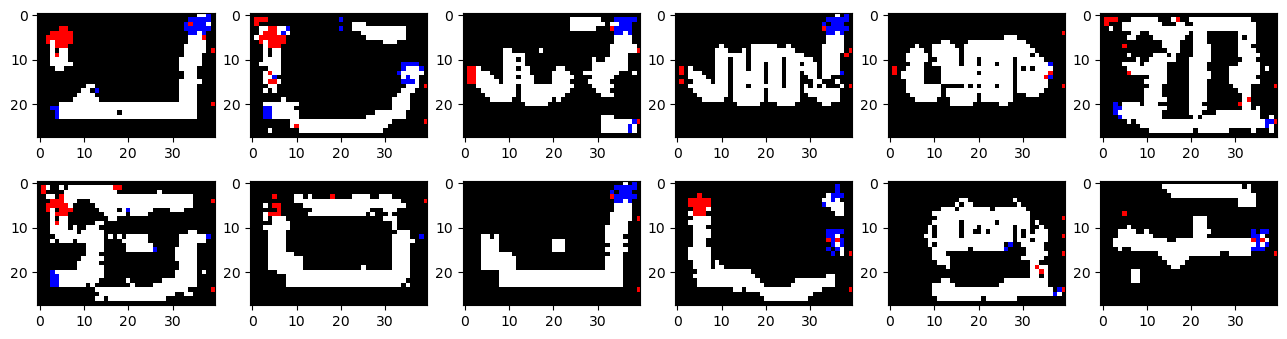

[2701/200]: loss_d: 0.000, loss_g: 3.161
[2702/200]: loss_d: 0.000, loss_g: 2.797
[2703/200]: loss_d: 0.000, loss_g: 2.875
[2704/200]: loss_d: 0.000, loss_g: 2.503
[2705/200]: loss_d: 0.000, loss_g: 2.917
[2706/200]: loss_d: 0.000, loss_g: 2.644
[2707/200]: loss_d: 0.000, loss_g: 2.180
[2708/200]: loss_d: 0.000, loss_g: 2.146
[2709/200]: loss_d: 0.003, loss_g: 2.415
[2710/200]: loss_d: 0.014, loss_g: 2.404
[2711/200]: loss_d: 0.000, loss_g: 2.048
[2712/200]: loss_d: 0.002, loss_g: 2.228
[2713/200]: loss_d: 0.022, loss_g: 1.818
[2714/200]: loss_d: 0.033, loss_g: 1.983
[2715/200]: loss_d: 0.022, loss_g: 2.825
[2716/200]: loss_d: 0.176, loss_g: 0.886
[2717/200]: loss_d: 0.361, loss_g: 4.743
[2718/200]: loss_d: 0.587, loss_g: 1.525
[2719/200]: loss_d: 0.090, loss_g: 1.982
[2720/200]: loss_d: 0.010, loss_g: 2.270
[2721/200]: loss_d: 0.041, loss_g: 1.847
[2722/200]: loss_d: 0.073, loss_g: 2.720
[2723/200]: loss_d: 0.012, loss_g: 2.020
[2724/200]: loss_d: 0.005, loss_g: 2.367
[2725/200]: loss

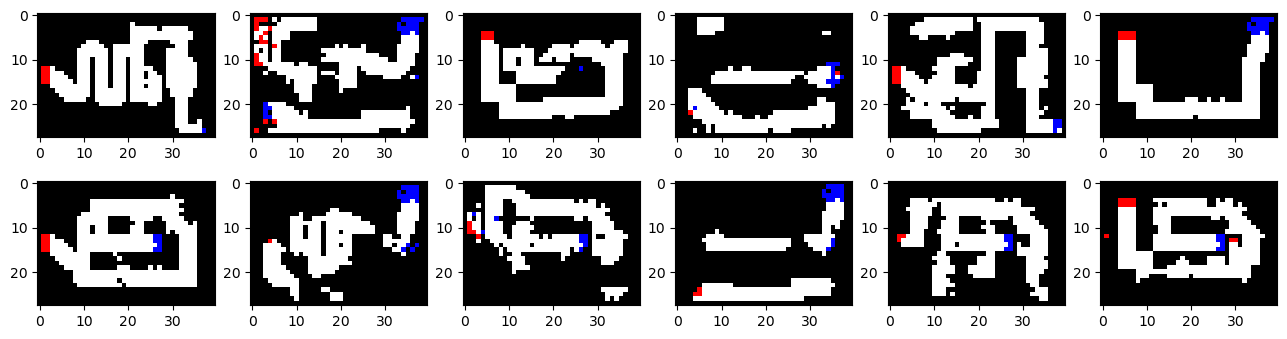

[2801/200]: loss_d: 0.000, loss_g: 2.531
[2802/200]: loss_d: 0.000, loss_g: 2.531
[2803/200]: loss_d: 0.007, loss_g: 2.735
[2804/200]: loss_d: 0.003, loss_g: 3.015
[2805/200]: loss_d: 0.000, loss_g: 2.965
[2806/200]: loss_d: 0.000, loss_g: 2.948
[2807/200]: loss_d: 0.000, loss_g: 2.702
[2808/200]: loss_d: 0.000, loss_g: 2.825
[2809/200]: loss_d: 0.000, loss_g: 2.705
[2810/200]: loss_d: 0.000, loss_g: 2.472
[2811/200]: loss_d: 0.000, loss_g: 2.623
[2812/200]: loss_d: 0.000, loss_g: 2.707
[2813/200]: loss_d: 0.000, loss_g: 2.728
[2814/200]: loss_d: 0.000, loss_g: 2.764
[2815/200]: loss_d: 0.000, loss_g: 2.303
[2816/200]: loss_d: 0.000, loss_g: 2.499
[2817/200]: loss_d: 0.000, loss_g: 2.624
[2818/200]: loss_d: 0.000, loss_g: 2.854
[2819/200]: loss_d: 0.003, loss_g: 3.238
[2820/200]: loss_d: 0.001, loss_g: 2.859
[2821/200]: loss_d: 0.000, loss_g: 2.793
[2822/200]: loss_d: 0.000, loss_g: 2.693
[2823/200]: loss_d: 0.000, loss_g: 2.949
[2824/200]: loss_d: 0.000, loss_g: 2.884
[2825/200]: loss

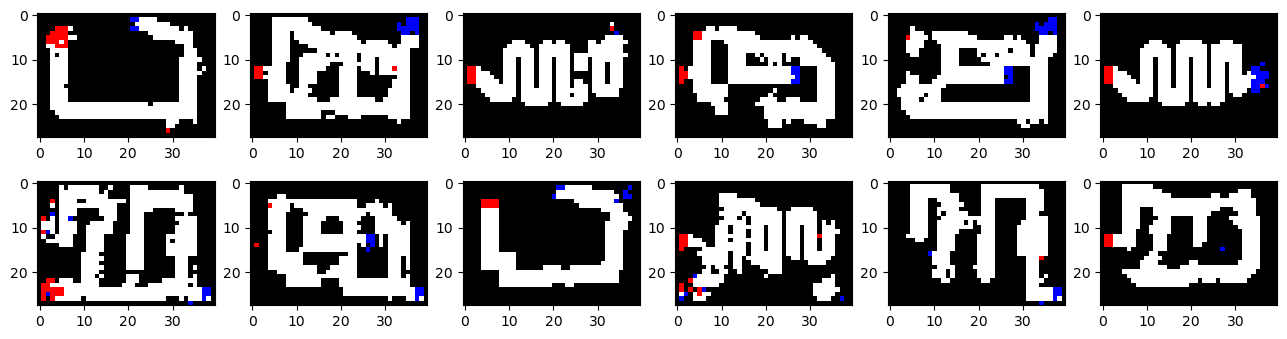

[2901/200]: loss_d: 0.000, loss_g: 2.505
[2902/200]: loss_d: 0.000, loss_g: 3.383
[2903/200]: loss_d: 0.000, loss_g: 3.324
[2904/200]: loss_d: 0.000, loss_g: 3.225
[2905/200]: loss_d: 0.000, loss_g: 2.715
[2906/200]: loss_d: 0.000, loss_g: 2.800
[2907/200]: loss_d: 0.000, loss_g: 3.178
[2908/200]: loss_d: 0.000, loss_g: 2.958
[2909/200]: loss_d: 0.000, loss_g: 3.160
[2910/200]: loss_d: 0.000, loss_g: 2.777
[2911/200]: loss_d: 0.000, loss_g: 2.523
[2912/200]: loss_d: 0.000, loss_g: 2.790
[2913/200]: loss_d: 0.000, loss_g: 2.429
[2914/200]: loss_d: 0.000, loss_g: 2.780
[2915/200]: loss_d: 0.000, loss_g: 3.132
[2916/200]: loss_d: 0.000, loss_g: 3.143
[2917/200]: loss_d: 0.000, loss_g: 2.791
[2918/200]: loss_d: 0.000, loss_g: 2.585
[2919/200]: loss_d: 0.000, loss_g: 2.786
[2920/200]: loss_d: 0.000, loss_g: 2.898
[2921/200]: loss_d: 0.000, loss_g: 2.806
[2922/200]: loss_d: 0.002, loss_g: 3.290
[2923/200]: loss_d: 0.030, loss_g: 1.472
[2924/200]: loss_d: 0.099, loss_g: 2.435
[2925/200]: loss

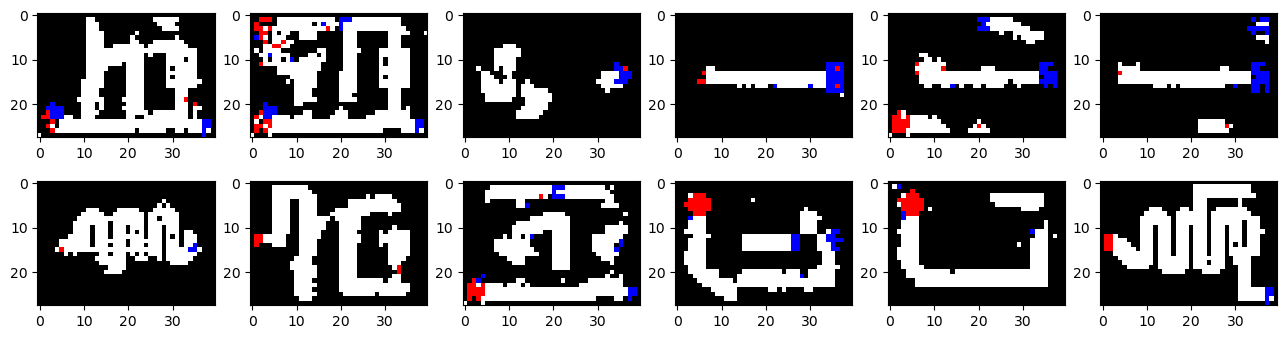

[3001/200]: loss_d: 0.014, loss_g: 2.008
[3002/200]: loss_d: 0.002, loss_g: 2.530
[3003/200]: loss_d: 0.000, loss_g: 2.712
[3004/200]: loss_d: 0.009, loss_g: 2.559
[3005/200]: loss_d: 0.000, loss_g: 2.116
[3006/200]: loss_d: 0.003, loss_g: 2.488
[3007/200]: loss_d: 0.000, loss_g: 2.852
[3008/200]: loss_d: 0.016, loss_g: 2.617
[3009/200]: loss_d: 0.000, loss_g: 2.637
[3010/200]: loss_d: 0.000, loss_g: 2.787
[3011/200]: loss_d: 0.000, loss_g: 2.521
[3012/200]: loss_d: 0.000, loss_g: 3.075
[3013/200]: loss_d: 0.000, loss_g: 2.522
[3014/200]: loss_d: 0.000, loss_g: 2.414
[3015/200]: loss_d: 0.000, loss_g: 2.692
[3016/200]: loss_d: 0.000, loss_g: 2.662
[3017/200]: loss_d: 0.000, loss_g: 2.115
[3018/200]: loss_d: 0.000, loss_g: 2.253
[3019/200]: loss_d: 0.000, loss_g: 2.301
[3020/200]: loss_d: 0.049, loss_g: 2.648
[3021/200]: loss_d: 0.065, loss_g: 1.586
[3022/200]: loss_d: 0.145, loss_g: 2.815
[3023/200]: loss_d: 0.000, loss_g: 3.139
[3024/200]: loss_d: 0.050, loss_g: 1.950
[3025/200]: loss

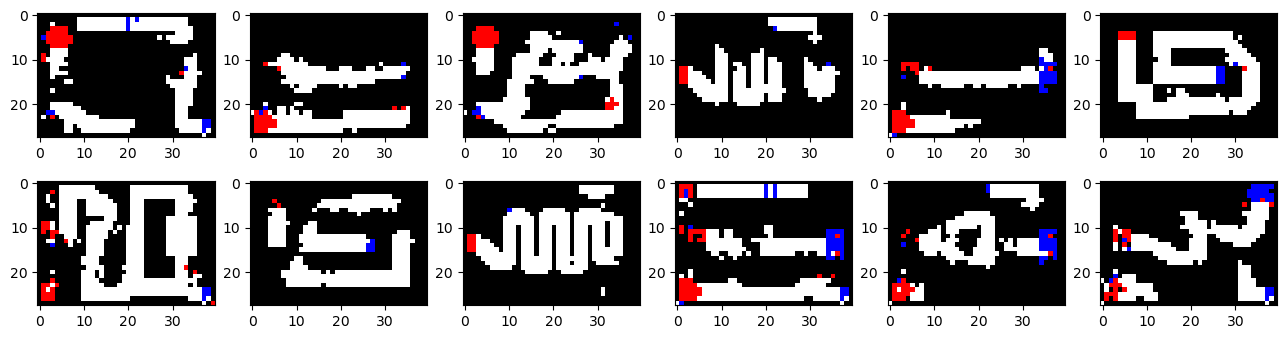

[3101/200]: loss_d: 0.000, loss_g: 3.086
[3102/200]: loss_d: 0.000, loss_g: 2.790
[3103/200]: loss_d: 0.000, loss_g: 2.744
[3104/200]: loss_d: 0.002, loss_g: 2.566
[3105/200]: loss_d: 0.000, loss_g: 2.913
[3106/200]: loss_d: 0.002, loss_g: 2.779
[3107/200]: loss_d: 0.000, loss_g: 2.632
[3108/200]: loss_d: 0.000, loss_g: 2.590
[3109/200]: loss_d: 0.000, loss_g: 2.393
[3110/200]: loss_d: 0.000, loss_g: 2.420
[3111/200]: loss_d: 0.000, loss_g: 2.578
[3112/200]: loss_d: 0.005, loss_g: 2.341
[3113/200]: loss_d: 0.000, loss_g: 3.055
[3114/200]: loss_d: 0.000, loss_g: 2.647
[3115/200]: loss_d: 0.000, loss_g: 2.296
[3116/200]: loss_d: 0.000, loss_g: 2.756
[3117/200]: loss_d: 0.000, loss_g: 2.357
[3118/200]: loss_d: 0.000, loss_g: 2.481
[3119/200]: loss_d: 0.000, loss_g: 2.373
[3120/200]: loss_d: 0.000, loss_g: 2.248
[3121/200]: loss_d: 0.000, loss_g: 2.281
[3122/200]: loss_d: 0.000, loss_g: 2.157
[3123/200]: loss_d: 0.000, loss_g: 2.443
[3124/200]: loss_d: 0.000, loss_g: 2.237
[3125/200]: loss

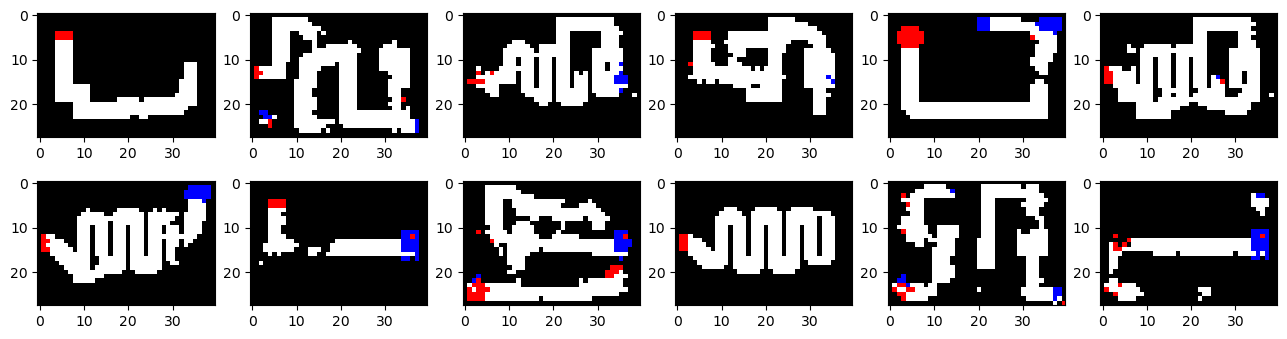

[3201/200]: loss_d: 0.191, loss_g: 2.336
[3202/200]: loss_d: 0.035, loss_g: 3.258
[3203/200]: loss_d: 0.381, loss_g: 0.853
[3204/200]: loss_d: 0.138, loss_g: 2.675
[3205/200]: loss_d: 0.010, loss_g: 2.933
[3206/200]: loss_d: 0.041, loss_g: 2.402
[3207/200]: loss_d: 0.022, loss_g: 1.829
[3208/200]: loss_d: 0.001, loss_g: 2.825
[3209/200]: loss_d: 0.000, loss_g: 2.647
[3210/200]: loss_d: 0.000, loss_g: 2.819
[3211/200]: loss_d: 0.000, loss_g: 2.538
[3212/200]: loss_d: 0.000, loss_g: 2.612
[3213/200]: loss_d: 0.004, loss_g: 2.484
[3214/200]: loss_d: 0.005, loss_g: 2.457
[3215/200]: loss_d: 0.000, loss_g: 2.572
[3216/200]: loss_d: 0.000, loss_g: 2.780
[3217/200]: loss_d: 0.003, loss_g: 2.618
[3218/200]: loss_d: 0.004, loss_g: 2.359
[3219/200]: loss_d: 0.000, loss_g: 2.671
[3220/200]: loss_d: 0.000, loss_g: 2.384
[3221/200]: loss_d: 0.000, loss_g: 2.664
[3222/200]: loss_d: 0.000, loss_g: 2.128
[3223/200]: loss_d: 0.000, loss_g: 2.661
[3224/200]: loss_d: 0.000, loss_g: 2.690
[3225/200]: loss

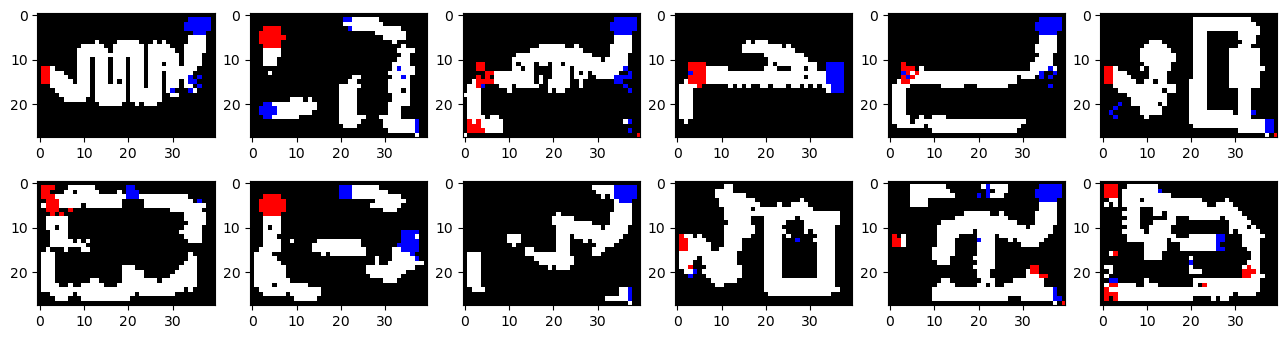

[3301/200]: loss_d: 0.001, loss_g: 2.189
[3302/200]: loss_d: 0.000, loss_g: 2.281
[3303/200]: loss_d: 0.000, loss_g: 2.885
[3304/200]: loss_d: 0.013, loss_g: 2.453
[3305/200]: loss_d: 0.000, loss_g: 3.076
[3306/200]: loss_d: 0.000, loss_g: 3.335
[3307/200]: loss_d: 0.011, loss_g: 2.829
[3308/200]: loss_d: 0.003, loss_g: 2.527
[3309/200]: loss_d: 0.000, loss_g: 2.874
[3310/200]: loss_d: 0.000, loss_g: 2.411
[3311/200]: loss_d: 0.000, loss_g: 2.702
[3312/200]: loss_d: 0.000, loss_g: 2.698
[3313/200]: loss_d: 0.000, loss_g: 2.260
[3314/200]: loss_d: 0.027, loss_g: 2.584
[3315/200]: loss_d: 0.008, loss_g: 2.962
[3316/200]: loss_d: 0.011, loss_g: 3.153
[3317/200]: loss_d: 0.002, loss_g: 3.318
[3318/200]: loss_d: 0.000, loss_g: 2.499
[3319/200]: loss_d: 0.000, loss_g: 2.771
[3320/200]: loss_d: 0.000, loss_g: 2.766
[3321/200]: loss_d: 0.000, loss_g: 3.418
[3322/200]: loss_d: 0.000, loss_g: 2.670
[3323/200]: loss_d: 0.000, loss_g: 2.801
[3324/200]: loss_d: 0.000, loss_g: 2.917
[3325/200]: loss

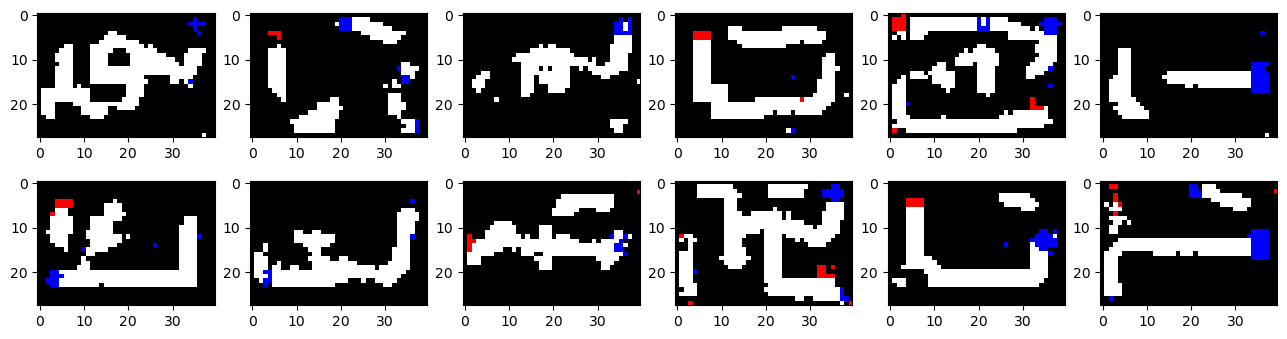

[3401/200]: loss_d: 0.000, loss_g: 2.446
[3402/200]: loss_d: 0.003, loss_g: 2.720
[3403/200]: loss_d: 0.001, loss_g: 2.290
[3404/200]: loss_d: 0.000, loss_g: 2.315
[3405/200]: loss_d: 0.005, loss_g: 2.459
[3406/200]: loss_d: 0.000, loss_g: 2.620
[3407/200]: loss_d: 0.000, loss_g: 3.032
[3408/200]: loss_d: 0.006, loss_g: 2.978
[3409/200]: loss_d: 0.003, loss_g: 3.299
[3410/200]: loss_d: 0.000, loss_g: 3.145
[3411/200]: loss_d: 0.000, loss_g: 2.801
[3412/200]: loss_d: 0.000, loss_g: 2.542
[3413/200]: loss_d: 0.000, loss_g: 3.057
[3414/200]: loss_d: 0.004, loss_g: 2.538
[3415/200]: loss_d: 0.005, loss_g: 2.697
[3416/200]: loss_d: 0.000, loss_g: 3.383
[3417/200]: loss_d: 0.001, loss_g: 3.366
[3418/200]: loss_d: 0.000, loss_g: 2.760
[3419/200]: loss_d: 0.000, loss_g: 2.756
[3420/200]: loss_d: 0.000, loss_g: 3.025
[3421/200]: loss_d: 0.000, loss_g: 3.323
[3422/200]: loss_d: 0.000, loss_g: 2.497
[3423/200]: loss_d: 0.000, loss_g: 3.008
[3424/200]: loss_d: 0.000, loss_g: 3.002
[3425/200]: loss

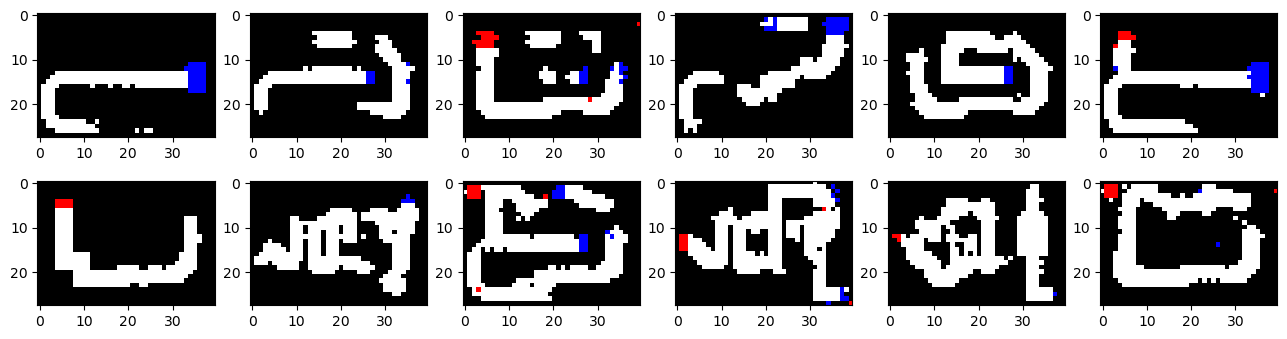

[3501/200]: loss_d: 0.000, loss_g: 3.053
[3502/200]: loss_d: 0.000, loss_g: 3.008
[3503/200]: loss_d: 0.000, loss_g: 3.583
[3504/200]: loss_d: 0.000, loss_g: 3.254
[3505/200]: loss_d: 0.000, loss_g: 3.316
[3506/200]: loss_d: 0.000, loss_g: 3.058
[3507/200]: loss_d: 0.000, loss_g: 2.780
[3508/200]: loss_d: 0.000, loss_g: 3.693
[3509/200]: loss_d: 0.000, loss_g: 3.284
[3510/200]: loss_d: 0.000, loss_g: 3.358
[3511/200]: loss_d: 0.000, loss_g: 3.096
[3512/200]: loss_d: 0.000, loss_g: 2.751
[3513/200]: loss_d: 0.000, loss_g: 3.045
[3514/200]: loss_d: 0.000, loss_g: 2.919
[3515/200]: loss_d: 0.000, loss_g: 2.837
[3516/200]: loss_d: 0.000, loss_g: 2.806
[3517/200]: loss_d: 0.000, loss_g: 3.331
[3518/200]: loss_d: 0.000, loss_g: 3.096
[3519/200]: loss_d: 0.000, loss_g: 3.089
[3520/200]: loss_d: 0.000, loss_g: 2.830
[3521/200]: loss_d: 0.000, loss_g: 2.852
[3522/200]: loss_d: 0.000, loss_g: 3.107
[3523/200]: loss_d: 0.000, loss_g: 3.174
[3524/200]: loss_d: 0.000, loss_g: 3.065
[3525/200]: loss

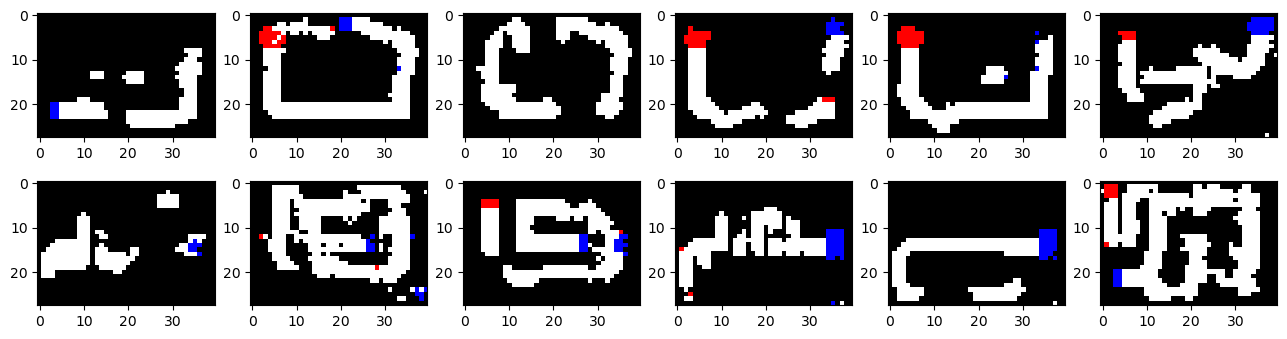

[3601/200]: loss_d: 0.000, loss_g: 3.035
[3602/200]: loss_d: 0.000, loss_g: 3.007
[3603/200]: loss_d: 0.000, loss_g: 2.577
[3604/200]: loss_d: 0.000, loss_g: 2.519
[3605/200]: loss_d: 0.027, loss_g: 2.910
[3606/200]: loss_d: 0.000, loss_g: 3.695
[3607/200]: loss_d: 0.051, loss_g: 2.744
[3608/200]: loss_d: 0.000, loss_g: 1.965
[3609/200]: loss_d: 0.000, loss_g: 2.133
[3610/200]: loss_d: 0.000, loss_g: 2.039
[3611/200]: loss_d: 0.048, loss_g: 3.255
[3612/200]: loss_d: 0.002, loss_g: 3.101
[3613/200]: loss_d: 0.017, loss_g: 3.184
[3614/200]: loss_d: 0.000, loss_g: 3.057
[3615/200]: loss_d: 0.000, loss_g: 3.020
[3616/200]: loss_d: 0.006, loss_g: 3.194
[3617/200]: loss_d: 0.000, loss_g: 2.943
[3618/200]: loss_d: 0.000, loss_g: 2.706
[3619/200]: loss_d: 0.000, loss_g: 3.273
[3620/200]: loss_d: 0.000, loss_g: 3.268
[3621/200]: loss_d: 0.001, loss_g: 2.751
[3622/200]: loss_d: 0.000, loss_g: 2.256
[3623/200]: loss_d: 0.000, loss_g: 2.547
[3624/200]: loss_d: 0.000, loss_g: 2.931
[3625/200]: loss

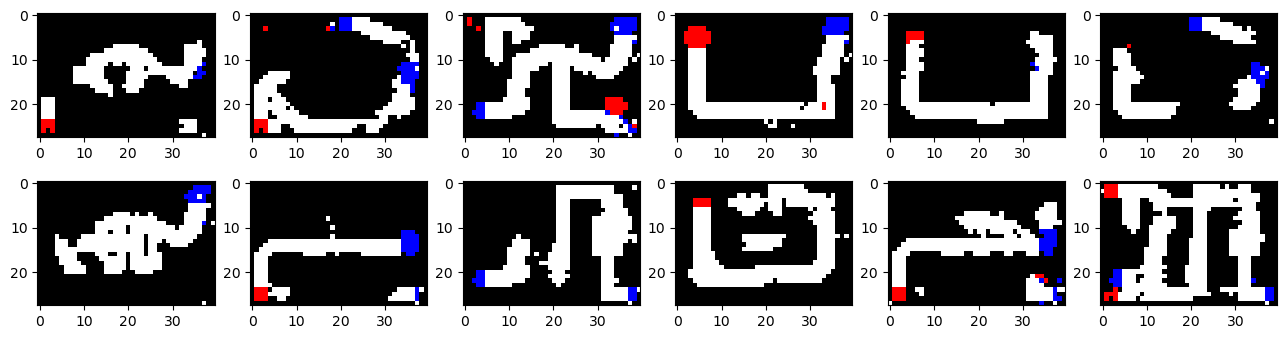

[3701/200]: loss_d: 0.000, loss_g: 3.355
[3702/200]: loss_d: 0.022, loss_g: 3.089
[3703/200]: loss_d: 0.000, loss_g: 3.286
[3704/200]: loss_d: 0.000, loss_g: 2.816
[3705/200]: loss_d: 0.000, loss_g: 2.866
[3706/200]: loss_d: 0.042, loss_g: 3.158
[3707/200]: loss_d: 0.000, loss_g: 3.495
[3708/200]: loss_d: 0.029, loss_g: 2.926
[3709/200]: loss_d: 0.005, loss_g: 2.462
[3710/200]: loss_d: 0.000, loss_g: 2.736
[3711/200]: loss_d: 0.009, loss_g: 2.966
[3712/200]: loss_d: 0.000, loss_g: 3.385
[3713/200]: loss_d: 0.001, loss_g: 3.193
[3714/200]: loss_d: 0.000, loss_g: 2.848
[3715/200]: loss_d: 0.001, loss_g: 2.905
[3716/200]: loss_d: 0.000, loss_g: 2.862
[3717/200]: loss_d: 0.009, loss_g: 3.344
[3718/200]: loss_d: 0.039, loss_g: 3.573
[3719/200]: loss_d: 0.000, loss_g: 3.293
[3720/200]: loss_d: 0.000, loss_g: 3.369
[3721/200]: loss_d: 0.000, loss_g: 2.791
[3722/200]: loss_d: 0.000, loss_g: 3.408
[3723/200]: loss_d: 0.000, loss_g: 3.095
[3724/200]: loss_d: 0.000, loss_g: 3.158
[3725/200]: loss

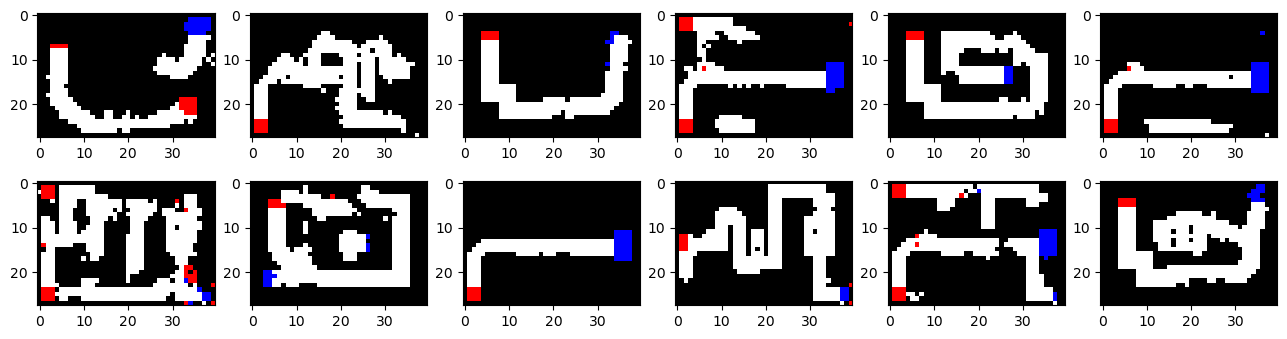

[3801/200]: loss_d: 0.000, loss_g: 2.587
[3802/200]: loss_d: 0.000, loss_g: 2.455
[3803/200]: loss_d: 0.000, loss_g: 2.274
[3804/200]: loss_d: 0.009, loss_g: 2.353
[3805/200]: loss_d: 0.000, loss_g: 2.891
[3806/200]: loss_d: 0.000, loss_g: 2.446
[3807/200]: loss_d: 0.000, loss_g: 2.653
[3808/200]: loss_d: 0.000, loss_g: 2.661
[3809/200]: loss_d: 0.001, loss_g: 2.395
[3810/200]: loss_d: 0.000, loss_g: 2.658
[3811/200]: loss_d: 0.000, loss_g: 3.005
[3812/200]: loss_d: 0.004, loss_g: 2.638
[3813/200]: loss_d: 0.013, loss_g: 2.758
[3814/200]: loss_d: 0.000, loss_g: 2.589
[3815/200]: loss_d: 0.000, loss_g: 2.495
[3816/200]: loss_d: 0.001, loss_g: 2.611
[3817/200]: loss_d: 0.000, loss_g: 2.870
[3818/200]: loss_d: 0.004, loss_g: 2.636
[3819/200]: loss_d: 0.009, loss_g: 2.309
[3820/200]: loss_d: 0.000, loss_g: 2.723
[3821/200]: loss_d: 0.067, loss_g: 2.864
[3822/200]: loss_d: 0.028, loss_g: 2.644
[3823/200]: loss_d: 0.000, loss_g: 2.499
[3824/200]: loss_d: 0.000, loss_g: 2.198
[3825/200]: loss

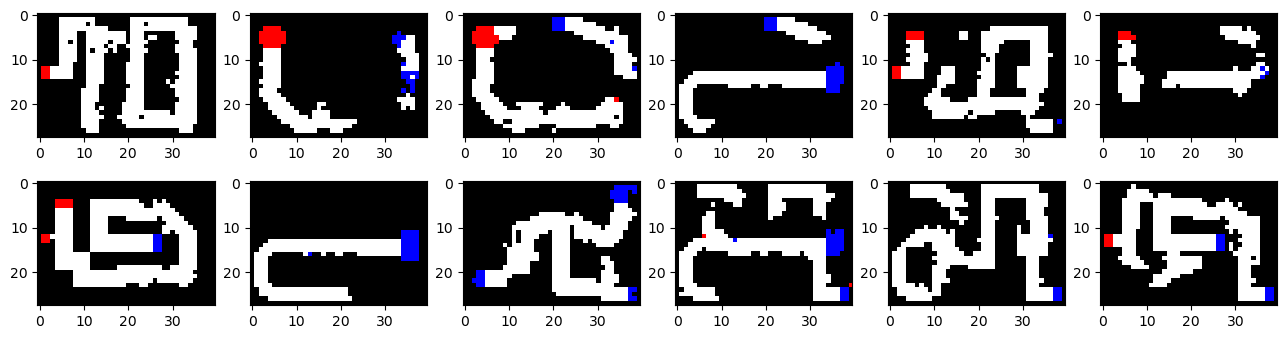

[3901/200]: loss_d: 0.004, loss_g: 2.552
[3902/200]: loss_d: 0.006, loss_g: 2.526
[3903/200]: loss_d: 0.000, loss_g: 2.142
[3904/200]: loss_d: 0.005, loss_g: 2.441
[3905/200]: loss_d: 0.020, loss_g: 2.075
[3906/200]: loss_d: 0.000, loss_g: 2.668
[3907/200]: loss_d: 0.000, loss_g: 2.497
[3908/200]: loss_d: 0.000, loss_g: 2.763
[3909/200]: loss_d: 0.002, loss_g: 2.423
[3910/200]: loss_d: 0.000, loss_g: 2.797
[3911/200]: loss_d: 0.000, loss_g: 2.826
[3912/200]: loss_d: 0.000, loss_g: 2.573
[3913/200]: loss_d: 0.000, loss_g: 3.081
[3914/200]: loss_d: 0.000, loss_g: 1.965
[3915/200]: loss_d: 0.002, loss_g: 2.657
[3916/200]: loss_d: 0.000, loss_g: 3.389
[3917/200]: loss_d: 0.000, loss_g: 3.057
[3918/200]: loss_d: 0.001, loss_g: 2.848
[3919/200]: loss_d: 0.000, loss_g: 2.671
[3920/200]: loss_d: 0.000, loss_g: 2.636
[3921/200]: loss_d: 0.000, loss_g: 2.448
[3922/200]: loss_d: 0.006, loss_g: 2.605
[3923/200]: loss_d: 0.000, loss_g: 2.628
[3924/200]: loss_d: 0.000, loss_g: 2.914
[3925/200]: loss

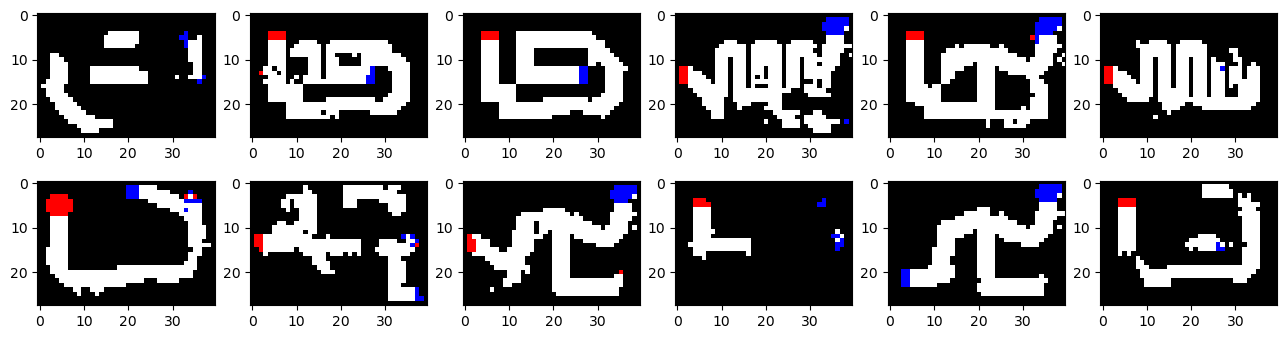

[4001/200]: loss_d: 0.000, loss_g: 3.068
[4002/200]: loss_d: 0.000, loss_g: 2.713
[4003/200]: loss_d: 0.000, loss_g: 2.405
[4004/200]: loss_d: 0.000, loss_g: 2.705
[4005/200]: loss_d: 0.000, loss_g: 2.951
[4006/200]: loss_d: 0.000, loss_g: 2.691
[4007/200]: loss_d: 0.000, loss_g: 2.873
[4008/200]: loss_d: 0.000, loss_g: 2.677
[4009/200]: loss_d: 0.000, loss_g: 3.021
[4010/200]: loss_d: 0.002, loss_g: 2.555
[4011/200]: loss_d: 0.000, loss_g: 3.263
[4012/200]: loss_d: 0.008, loss_g: 2.634
[4013/200]: loss_d: 0.000, loss_g: 3.185
[4014/200]: loss_d: 0.000, loss_g: 3.070
[4015/200]: loss_d: 0.000, loss_g: 2.476
[4016/200]: loss_d: 0.000, loss_g: 2.596
[4017/200]: loss_d: 0.000, loss_g: 2.427
[4018/200]: loss_d: 0.000, loss_g: 2.689
[4019/200]: loss_d: 0.001, loss_g: 2.401
[4020/200]: loss_d: 0.000, loss_g: 3.217
[4021/200]: loss_d: 0.004, loss_g: 2.885
[4022/200]: loss_d: 0.000, loss_g: 2.885
[4023/200]: loss_d: 0.000, loss_g: 2.505
[4024/200]: loss_d: 0.000, loss_g: 2.609
[4025/200]: loss

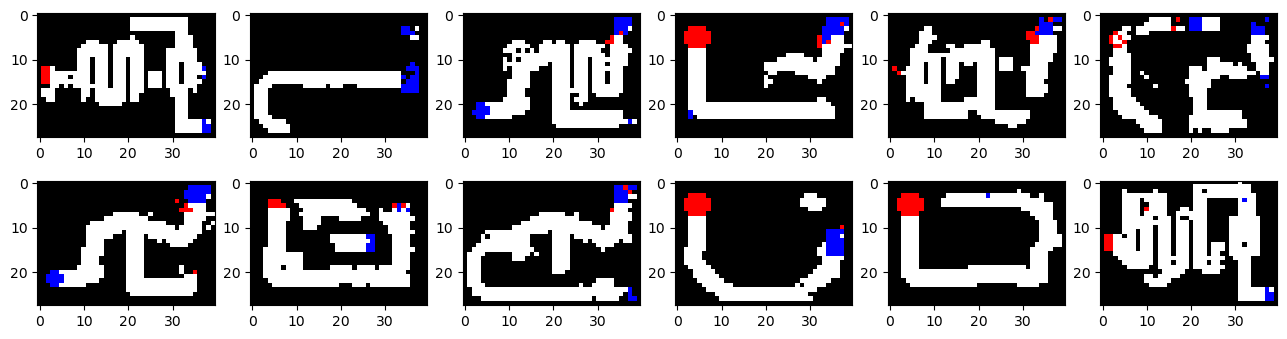

[4101/200]: loss_d: 0.000, loss_g: 3.051
[4102/200]: loss_d: 0.000, loss_g: 2.917
[4103/200]: loss_d: 0.000, loss_g: 3.083
[4104/200]: loss_d: 0.000, loss_g: 3.583
[4105/200]: loss_d: 0.000, loss_g: 2.832
[4106/200]: loss_d: 0.000, loss_g: 2.772
[4107/200]: loss_d: 0.000, loss_g: 3.415
[4108/200]: loss_d: 0.000, loss_g: 3.294
[4109/200]: loss_d: 0.000, loss_g: 3.145
[4110/200]: loss_d: 0.000, loss_g: 3.137
[4111/200]: loss_d: 0.000, loss_g: 3.266
[4112/200]: loss_d: 0.000, loss_g: 3.124
[4113/200]: loss_d: 0.004, loss_g: 2.868
[4114/200]: loss_d: 0.003, loss_g: 3.150
[4115/200]: loss_d: 0.000, loss_g: 3.178
[4116/200]: loss_d: 0.000, loss_g: 3.591
[4117/200]: loss_d: 0.000, loss_g: 3.334
[4118/200]: loss_d: 0.001, loss_g: 3.464
[4119/200]: loss_d: 0.000, loss_g: 2.893
[4120/200]: loss_d: 0.000, loss_g: 3.309
[4121/200]: loss_d: 0.000, loss_g: 3.125
[4122/200]: loss_d: 0.000, loss_g: 2.825
[4123/200]: loss_d: 0.000, loss_g: 3.286
[4124/200]: loss_d: 0.000, loss_g: 3.187
[4125/200]: loss

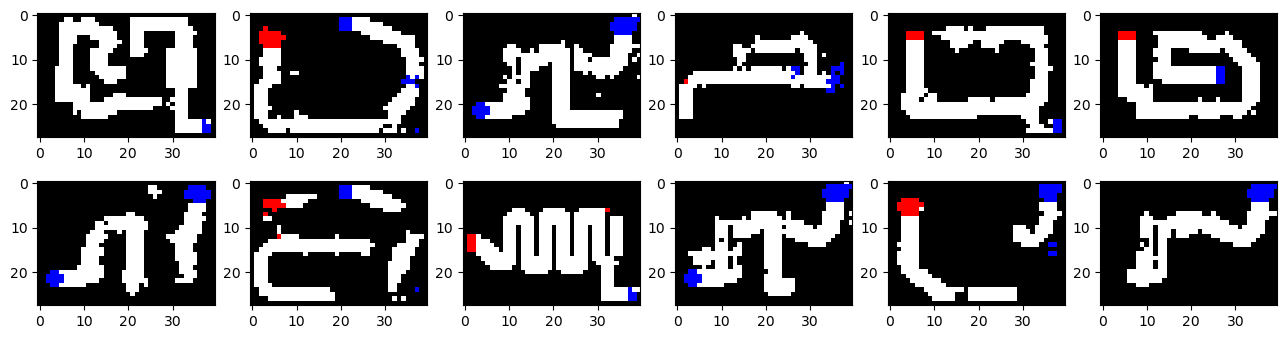

[4201/200]: loss_d: 0.007, loss_g: 2.970
[4202/200]: loss_d: 0.032, loss_g: 2.340
[4203/200]: loss_d: 0.000, loss_g: 1.885
[4204/200]: loss_d: 0.117, loss_g: 2.503
[4205/200]: loss_d: 0.005, loss_g: 3.035
[4206/200]: loss_d: 0.029, loss_g: 2.922
[4207/200]: loss_d: 0.004, loss_g: 2.872
[4208/200]: loss_d: 0.004, loss_g: 2.763
[4209/200]: loss_d: 0.000, loss_g: 2.243
[4210/200]: loss_d: 0.000, loss_g: 2.742
[4211/200]: loss_d: 0.000, loss_g: 3.037
[4212/200]: loss_d: 0.000, loss_g: 2.822
[4213/200]: loss_d: 0.000, loss_g: 2.312
[4214/200]: loss_d: 0.000, loss_g: 3.059
[4215/200]: loss_d: 0.000, loss_g: 2.888
[4216/200]: loss_d: 0.000, loss_g: 3.105
[4217/200]: loss_d: 0.000, loss_g: 2.881
[4218/200]: loss_d: 0.011, loss_g: 2.630
[4219/200]: loss_d: 0.006, loss_g: 2.757
[4220/200]: loss_d: 0.000, loss_g: 2.795
[4221/200]: loss_d: 0.000, loss_g: 2.599
[4222/200]: loss_d: 0.000, loss_g: 2.578
[4223/200]: loss_d: 0.004, loss_g: 2.573
[4224/200]: loss_d: 0.000, loss_g: 2.740
[4225/200]: loss

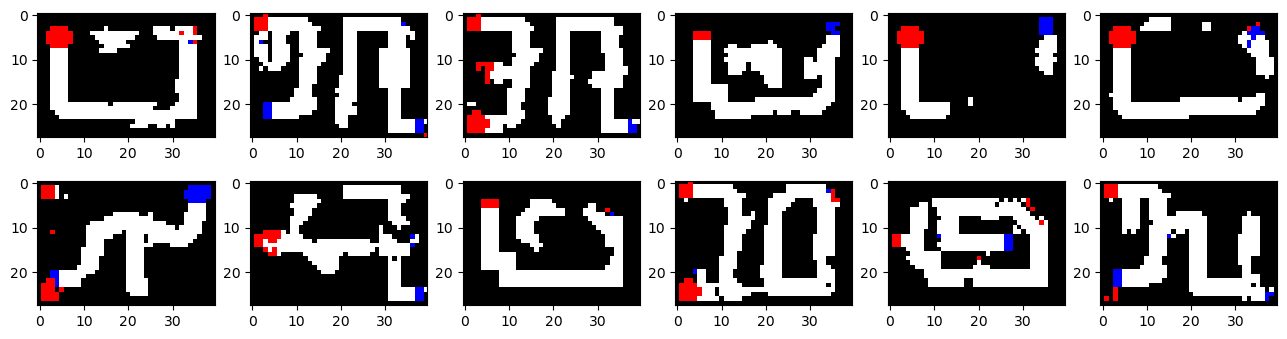

[4301/200]: loss_d: 0.003, loss_g: 3.122
[4302/200]: loss_d: 0.000, loss_g: 3.199
[4303/200]: loss_d: 0.000, loss_g: 3.332
[4304/200]: loss_d: 0.000, loss_g: 2.901
[4305/200]: loss_d: 0.000, loss_g: 3.290
[4306/200]: loss_d: 0.000, loss_g: 2.850
[4307/200]: loss_d: 0.000, loss_g: 3.119
[4308/200]: loss_d: 0.000, loss_g: 2.775
[4309/200]: loss_d: 0.000, loss_g: 2.662
[4310/200]: loss_d: 0.035, loss_g: 3.303
[4311/200]: loss_d: 0.020, loss_g: 3.757
[4312/200]: loss_d: 0.000, loss_g: 3.448
[4313/200]: loss_d: 0.008, loss_g: 2.484
[4314/200]: loss_d: 0.064, loss_g: 3.442
[4315/200]: loss_d: 0.013, loss_g: 3.611
[4316/200]: loss_d: 0.051, loss_g: 2.804
[4317/200]: loss_d: 0.000, loss_g: 3.086
[4318/200]: loss_d: 0.028, loss_g: 2.982
[4319/200]: loss_d: 0.000, loss_g: 3.356
[4320/200]: loss_d: 0.000, loss_g: 3.285
[4321/200]: loss_d: 0.000, loss_g: 3.220
[4322/200]: loss_d: 0.000, loss_g: 3.296
[4323/200]: loss_d: 0.000, loss_g: 3.558
[4324/200]: loss_d: 0.001, loss_g: 2.878
[4325/200]: loss

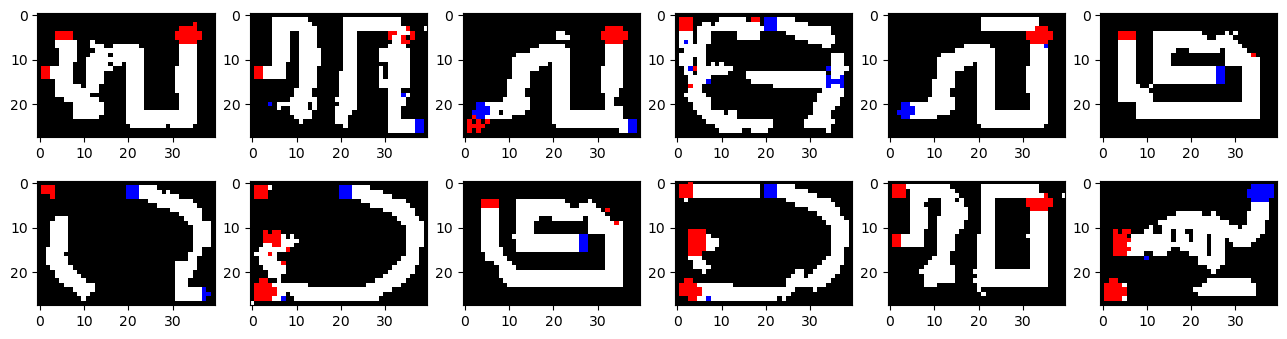

[4401/200]: loss_d: 0.013, loss_g: 3.076
[4402/200]: loss_d: 0.000, loss_g: 3.377
[4403/200]: loss_d: 0.000, loss_g: 3.267
[4404/200]: loss_d: 0.000, loss_g: 3.689
[4405/200]: loss_d: 0.000, loss_g: 3.982
[4406/200]: loss_d: 0.000, loss_g: 3.808
[4407/200]: loss_d: 0.000, loss_g: 3.610
[4408/200]: loss_d: 0.000, loss_g: 3.106
[4409/200]: loss_d: 0.000, loss_g: 3.844
[4410/200]: loss_d: 0.000, loss_g: 3.848
[4411/200]: loss_d: 0.000, loss_g: 3.520
[4412/200]: loss_d: 0.000, loss_g: 4.355
[4413/200]: loss_d: 0.000, loss_g: 3.688
[4414/200]: loss_d: 0.000, loss_g: 3.987
[4415/200]: loss_d: 0.000, loss_g: 3.766
[4416/200]: loss_d: 0.000, loss_g: 3.158
[4417/200]: loss_d: 0.000, loss_g: 3.514
[4418/200]: loss_d: 0.000, loss_g: 3.796
[4419/200]: loss_d: 0.000, loss_g: 3.693
[4420/200]: loss_d: 0.000, loss_g: 3.578
[4421/200]: loss_d: 0.000, loss_g: 3.922
[4422/200]: loss_d: 0.000, loss_g: 3.546
[4423/200]: loss_d: 0.000, loss_g: 3.192
[4424/200]: loss_d: 0.000, loss_g: 3.978
[4425/200]: loss

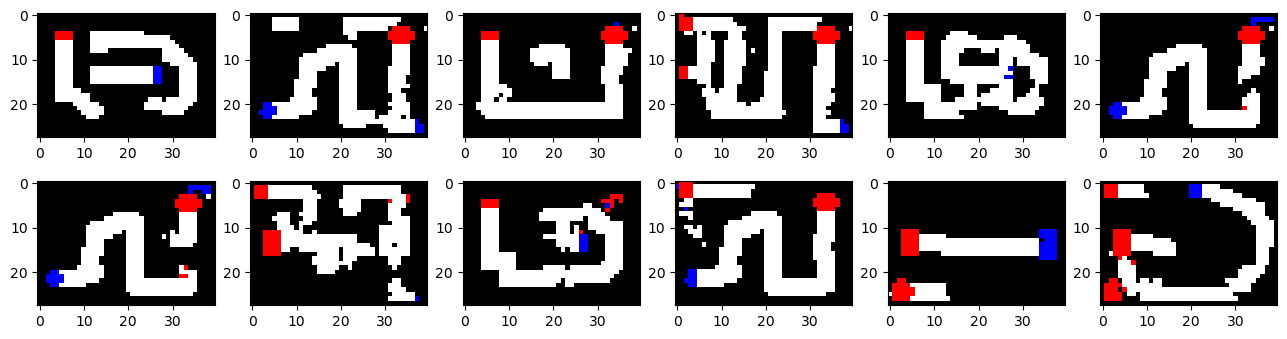

[4501/200]: loss_d: 0.000, loss_g: 3.256
[4502/200]: loss_d: 0.000, loss_g: 2.667
[4503/200]: loss_d: 0.000, loss_g: 3.258
[4504/200]: loss_d: 0.000, loss_g: 2.840
[4505/200]: loss_d: 0.000, loss_g: 2.405
[4506/200]: loss_d: 0.000, loss_g: 3.023
[4507/200]: loss_d: 0.000, loss_g: 3.287
[4508/200]: loss_d: 0.000, loss_g: 3.150
[4509/200]: loss_d: 0.000, loss_g: 3.388
[4510/200]: loss_d: 0.001, loss_g: 2.944
[4511/200]: loss_d: 0.060, loss_g: 2.125
[4512/200]: loss_d: 0.069, loss_g: 3.262
[4513/200]: loss_d: 0.035, loss_g: 2.859
[4514/200]: loss_d: 0.000, loss_g: 2.905
[4515/200]: loss_d: 0.006, loss_g: 2.966
[4516/200]: loss_d: 0.014, loss_g: 3.088
[4517/200]: loss_d: 0.000, loss_g: 3.558
[4518/200]: loss_d: 0.000, loss_g: 3.400
[4519/200]: loss_d: 0.004, loss_g: 2.802
[4520/200]: loss_d: 0.000, loss_g: 2.501
[4521/200]: loss_d: 0.033, loss_g: 2.950
[4522/200]: loss_d: 0.001, loss_g: 3.304
[4523/200]: loss_d: 0.019, loss_g: 3.235
[4524/200]: loss_d: 0.013, loss_g: 2.991
[4525/200]: loss

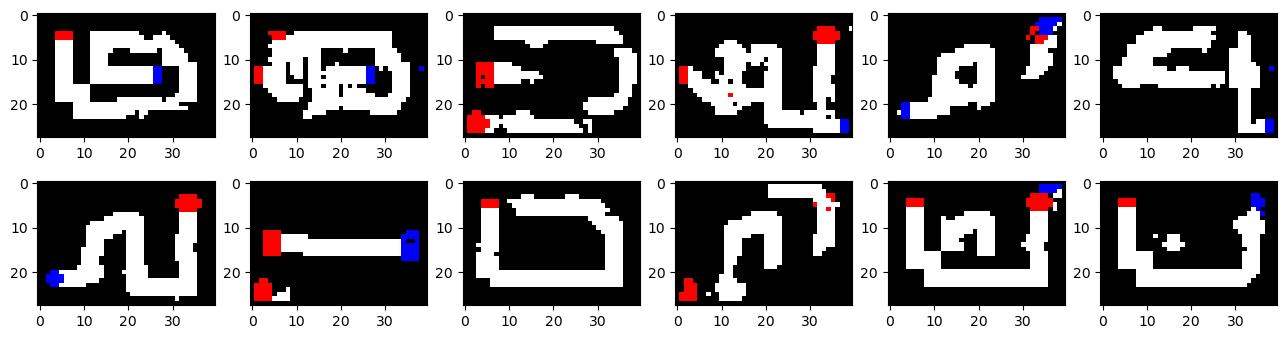

[4601/200]: loss_d: 0.000, loss_g: 3.367
[4602/200]: loss_d: 0.000, loss_g: 3.318
[4603/200]: loss_d: 0.000, loss_g: 3.833
[4604/200]: loss_d: 0.007, loss_g: 3.393
[4605/200]: loss_d: 0.000, loss_g: 4.420
[4606/200]: loss_d: 0.007, loss_g: 3.568
[4607/200]: loss_d: 0.000, loss_g: 3.041
[4608/200]: loss_d: 0.000, loss_g: 3.427
[4609/200]: loss_d: 0.000, loss_g: 3.100
[4610/200]: loss_d: 0.000, loss_g: 3.271
[4611/200]: loss_d: 0.000, loss_g: 2.696
[4612/200]: loss_d: 0.000, loss_g: 2.973
[4613/200]: loss_d: 0.000, loss_g: 2.948
[4614/200]: loss_d: 0.000, loss_g: 3.000
[4615/200]: loss_d: 0.000, loss_g: 2.718
[4616/200]: loss_d: 0.000, loss_g: 2.601
[4617/200]: loss_d: 0.000, loss_g: 2.663
[4618/200]: loss_d: 0.000, loss_g: 3.324
[4619/200]: loss_d: 0.000, loss_g: 3.316
[4620/200]: loss_d: 0.000, loss_g: 3.295
[4621/200]: loss_d: 0.000, loss_g: 2.801
[4622/200]: loss_d: 0.007, loss_g: 3.147
[4623/200]: loss_d: 0.000, loss_g: 3.407
[4624/200]: loss_d: 0.000, loss_g: 3.299
[4625/200]: loss

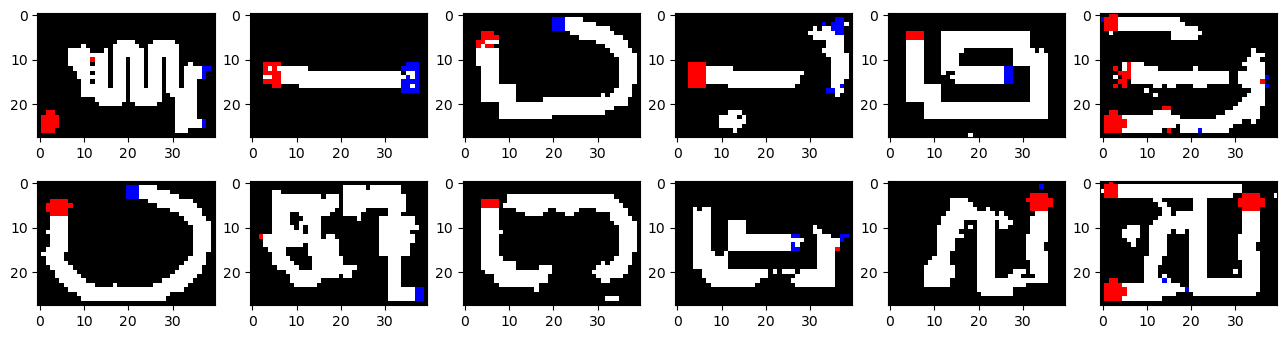

[4701/200]: loss_d: 0.000, loss_g: 3.481
[4702/200]: loss_d: 0.000, loss_g: 3.791
[4703/200]: loss_d: 0.000, loss_g: 3.289
[4704/200]: loss_d: 0.000, loss_g: 3.771
[4705/200]: loss_d: 0.000, loss_g: 2.846
[4706/200]: loss_d: 0.000, loss_g: 3.582
[4707/200]: loss_d: 0.000, loss_g: 3.827
[4708/200]: loss_d: 0.000, loss_g: 3.456
[4709/200]: loss_d: 0.000, loss_g: 3.253
[4710/200]: loss_d: 0.000, loss_g: 2.837
[4711/200]: loss_d: 0.000, loss_g: 3.491
[4712/200]: loss_d: 0.000, loss_g: 3.275
[4713/200]: loss_d: 0.000, loss_g: 3.525
[4714/200]: loss_d: 0.000, loss_g: 3.261
[4715/200]: loss_d: 0.000, loss_g: 3.215
[4716/200]: loss_d: 0.000, loss_g: 3.321
[4717/200]: loss_d: 0.000, loss_g: 3.246
[4718/200]: loss_d: 0.000, loss_g: 3.205
[4719/200]: loss_d: 0.000, loss_g: 3.376
[4720/200]: loss_d: 0.000, loss_g: 3.660
[4721/200]: loss_d: 0.000, loss_g: 3.089
[4722/200]: loss_d: 0.000, loss_g: 3.005
[4723/200]: loss_d: 0.000, loss_g: 3.205
[4724/200]: loss_d: 0.000, loss_g: 2.629
[4725/200]: loss

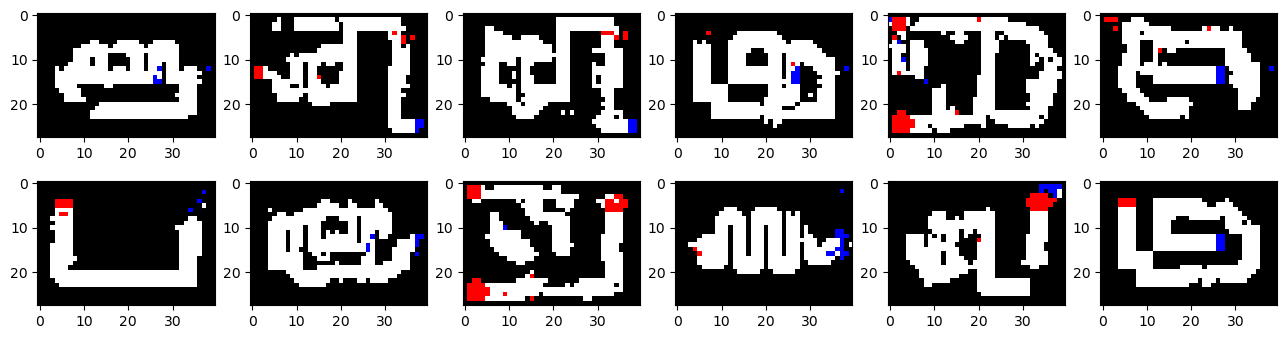

[4801/200]: loss_d: 0.000, loss_g: 2.695
[4802/200]: loss_d: 0.000, loss_g: 2.876
[4803/200]: loss_d: 0.000, loss_g: 2.999
[4804/200]: loss_d: 0.000, loss_g: 3.016
[4805/200]: loss_d: 0.000, loss_g: 2.925
[4806/200]: loss_d: 0.001, loss_g: 3.315
[4807/200]: loss_d: 0.000, loss_g: 3.689
[4808/200]: loss_d: 0.000, loss_g: 4.430
[4809/200]: loss_d: 0.011, loss_g: 2.756
[4810/200]: loss_d: 0.000, loss_g: 2.432
[4811/200]: loss_d: 0.000, loss_g: 2.676
[4812/200]: loss_d: 0.024, loss_g: 2.754
[4813/200]: loss_d: 0.000, loss_g: 2.882
[4814/200]: loss_d: 0.000, loss_g: 3.266
[4815/200]: loss_d: 0.000, loss_g: 2.813
[4816/200]: loss_d: 0.000, loss_g: 3.006
[4817/200]: loss_d: 0.000, loss_g: 3.109
[4818/200]: loss_d: 0.000, loss_g: 3.026
[4819/200]: loss_d: 0.000, loss_g: 3.170
[4820/200]: loss_d: 0.000, loss_g: 2.940
[4821/200]: loss_d: 0.008, loss_g: 2.996
[4822/200]: loss_d: 0.000, loss_g: 3.534
[4823/200]: loss_d: 0.000, loss_g: 3.745
[4824/200]: loss_d: 0.000, loss_g: 3.606
[4825/200]: loss

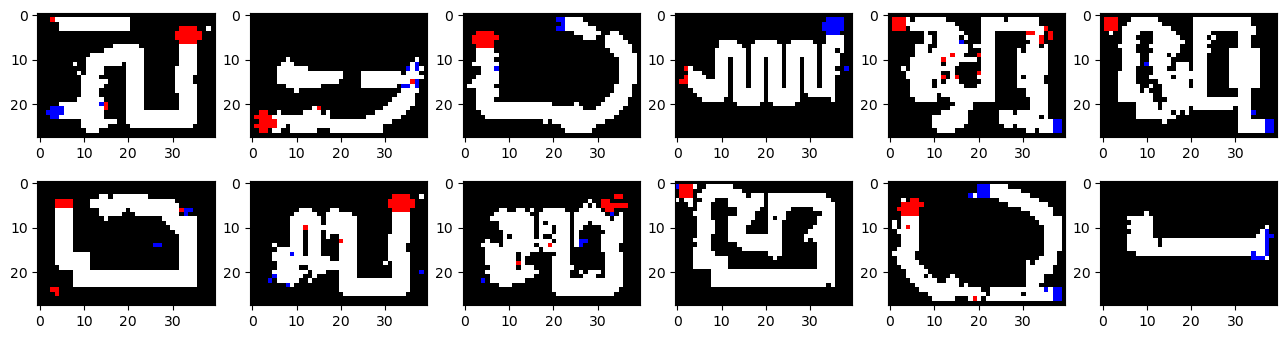

[4901/200]: loss_d: 0.000, loss_g: 3.213
[4902/200]: loss_d: 0.000, loss_g: 3.001
[4903/200]: loss_d: 0.000, loss_g: 2.870
[4904/200]: loss_d: 0.000, loss_g: 2.765
[4905/200]: loss_d: 0.000, loss_g: 2.749
[4906/200]: loss_d: 0.000, loss_g: 2.916
[4907/200]: loss_d: 0.000, loss_g: 3.199
[4908/200]: loss_d: 0.000, loss_g: 2.832
[4909/200]: loss_d: 0.000, loss_g: 3.365
[4910/200]: loss_d: 0.000, loss_g: 2.697
[4911/200]: loss_d: 0.000, loss_g: 2.968
[4912/200]: loss_d: 0.000, loss_g: 2.953
[4913/200]: loss_d: 0.000, loss_g: 2.820
[4914/200]: loss_d: 0.000, loss_g: 2.622
[4915/200]: loss_d: 0.000, loss_g: 2.549
[4916/200]: loss_d: 0.000, loss_g: 3.236
[4917/200]: loss_d: 0.000, loss_g: 2.914
[4918/200]: loss_d: 0.000, loss_g: 2.926
[4919/200]: loss_d: 0.000, loss_g: 2.400
[4920/200]: loss_d: 0.018, loss_g: 3.728
[4921/200]: loss_d: 0.134, loss_g: -0.068
[4922/200]: loss_d: 1.025, loss_g: 5.025
[4923/200]: loss_d: 1.203, loss_g: 1.678
[4924/200]: loss_d: 0.410, loss_g: 4.090
[4925/200]: los

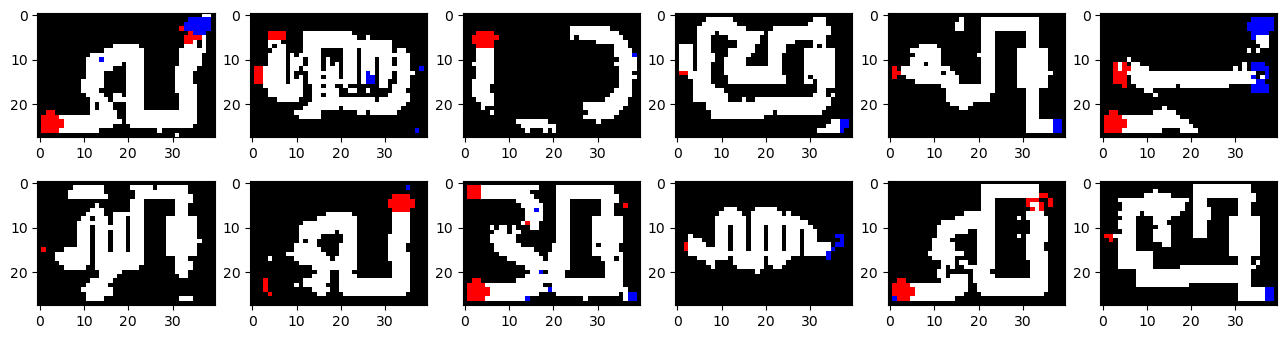

[5001/200]: loss_d: 0.004, loss_g: 3.098
[5002/200]: loss_d: 0.000, loss_g: 3.105
[5003/200]: loss_d: 0.000, loss_g: 3.584
[5004/200]: loss_d: 0.005, loss_g: 3.482
[5005/200]: loss_d: 0.000, loss_g: 3.916
[5006/200]: loss_d: 0.000, loss_g: 3.931
[5007/200]: loss_d: 0.000, loss_g: 4.060
[5008/200]: loss_d: 0.000, loss_g: 4.122
[5009/200]: loss_d: 0.000, loss_g: 4.127
[5010/200]: loss_d: 0.000, loss_g: 4.015
[5011/200]: loss_d: 0.000, loss_g: 4.167
[5012/200]: loss_d: 0.000, loss_g: 3.360
[5013/200]: loss_d: 0.000, loss_g: 4.291
[5014/200]: loss_d: 0.000, loss_g: 3.835
[5015/200]: loss_d: 0.000, loss_g: 3.759
[5016/200]: loss_d: 0.000, loss_g: 3.787
[5017/200]: loss_d: 0.000, loss_g: 3.354
[5018/200]: loss_d: 0.000, loss_g: 3.292
[5019/200]: loss_d: 0.000, loss_g: 4.183
[5020/200]: loss_d: 0.000, loss_g: 3.991
[5021/200]: loss_d: 0.000, loss_g: 3.665
[5022/200]: loss_d: 0.000, loss_g: 3.969
[5023/200]: loss_d: 0.000, loss_g: 3.742
[5024/200]: loss_d: 0.000, loss_g: 4.427
[5025/200]: loss

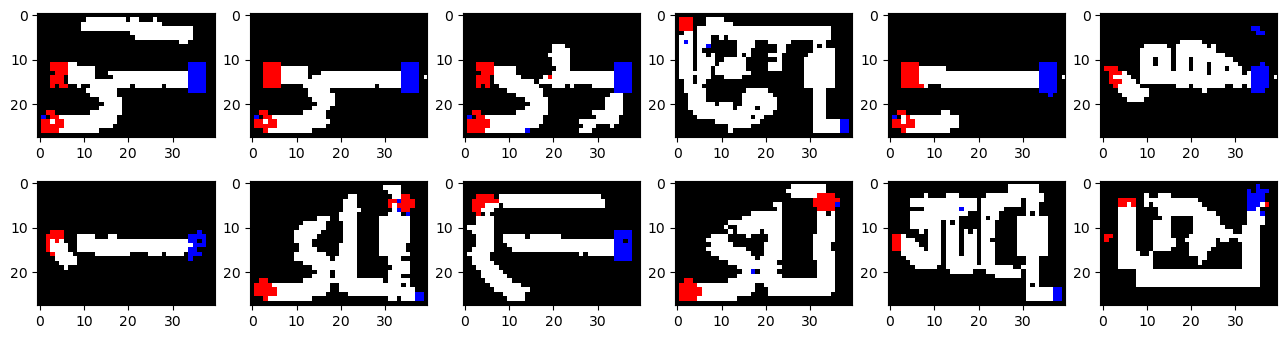

[5101/200]: loss_d: 0.042, loss_g: 3.422
[5102/200]: loss_d: 0.006, loss_g: 3.427
[5103/200]: loss_d: 0.000, loss_g: 3.524
[5104/200]: loss_d: 0.012, loss_g: 2.825
[5105/200]: loss_d: 0.000, loss_g: 2.355
[5106/200]: loss_d: 0.053, loss_g: 3.335
[5107/200]: loss_d: 0.000, loss_g: 4.163
[5108/200]: loss_d: 0.015, loss_g: 3.299
[5109/200]: loss_d: 0.015, loss_g: 3.108
[5110/200]: loss_d: 0.029, loss_g: 2.971
[5111/200]: loss_d: 0.000, loss_g: 3.381
[5112/200]: loss_d: 0.000, loss_g: 4.332
[5113/200]: loss_d: 0.011, loss_g: 3.156
[5114/200]: loss_d: 0.000, loss_g: 3.408
[5115/200]: loss_d: 0.001, loss_g: 3.482
[5116/200]: loss_d: 0.000, loss_g: 3.635
[5117/200]: loss_d: 0.000, loss_g: 3.272
[5118/200]: loss_d: 0.000, loss_g: 3.680
[5119/200]: loss_d: 0.000, loss_g: 3.303
[5120/200]: loss_d: 0.000, loss_g: 3.283
[5121/200]: loss_d: 0.000, loss_g: 3.369
[5122/200]: loss_d: 0.016, loss_g: 3.886
[5123/200]: loss_d: 0.044, loss_g: 3.790
[5124/200]: loss_d: 0.016, loss_g: 3.625
[5125/200]: loss

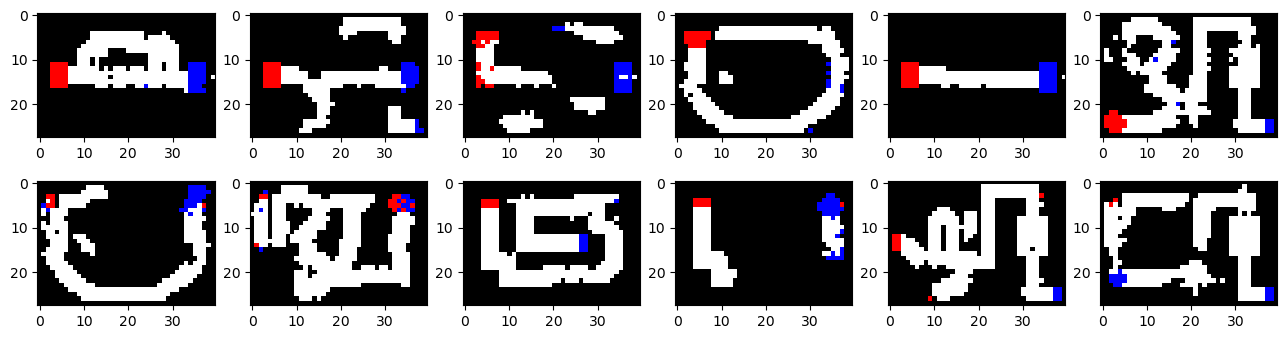

[5201/200]: loss_d: 0.000, loss_g: 2.942
[5202/200]: loss_d: 0.000, loss_g: 2.973
[5203/200]: loss_d: 0.000, loss_g: 3.347
[5204/200]: loss_d: 0.000, loss_g: 3.484
[5205/200]: loss_d: 0.000, loss_g: 2.985
[5206/200]: loss_d: 0.000, loss_g: 3.520
[5207/200]: loss_d: 0.000, loss_g: 3.473
[5208/200]: loss_d: 0.000, loss_g: 3.086
[5209/200]: loss_d: 0.000, loss_g: 2.931
[5210/200]: loss_d: 0.000, loss_g: 3.050
[5211/200]: loss_d: 0.000, loss_g: 3.006
[5212/200]: loss_d: 0.000, loss_g: 3.133
[5213/200]: loss_d: 0.000, loss_g: 3.434
[5214/200]: loss_d: 0.000, loss_g: 3.095
[5215/200]: loss_d: 0.000, loss_g: 2.767
[5216/200]: loss_d: 0.000, loss_g: 3.016
[5217/200]: loss_d: 0.000, loss_g: 3.402
[5218/200]: loss_d: 0.000, loss_g: 2.817
[5219/200]: loss_d: 0.000, loss_g: 3.095
[5220/200]: loss_d: 0.000, loss_g: 3.984
[5221/200]: loss_d: 0.000, loss_g: 3.506
[5222/200]: loss_d: 0.000, loss_g: 2.806
[5223/200]: loss_d: 0.000, loss_g: 3.039
[5224/200]: loss_d: 0.000, loss_g: 2.901
[5225/200]: loss

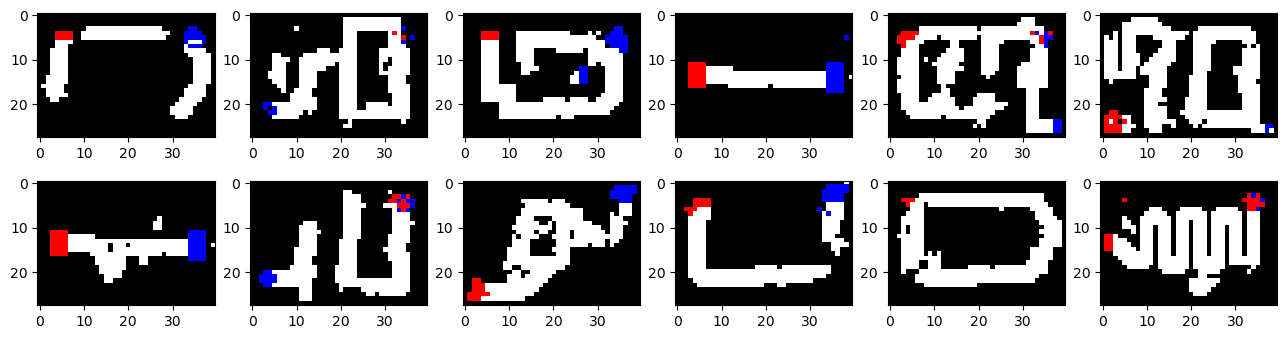

[5301/200]: loss_d: 0.000, loss_g: 3.081
[5302/200]: loss_d: 0.000, loss_g: 3.783
[5303/200]: loss_d: 0.000, loss_g: 3.213
[5304/200]: loss_d: 0.002, loss_g: 3.453
[5305/200]: loss_d: 0.000, loss_g: 3.132
[5306/200]: loss_d: 0.028, loss_g: 2.424
[5307/200]: loss_d: 0.000, loss_g: 2.385
[5308/200]: loss_d: 0.085, loss_g: 3.170
[5309/200]: loss_d: 0.028, loss_g: 2.848
[5310/200]: loss_d: 0.000, loss_g: 2.970
[5311/200]: loss_d: 0.000, loss_g: 3.295
[5312/200]: loss_d: 0.000, loss_g: 2.852
[5313/200]: loss_d: 0.000, loss_g: 3.364
[5314/200]: loss_d: 0.000, loss_g: 3.317
[5315/200]: loss_d: 0.010, loss_g: 3.456
[5316/200]: loss_d: 0.000, loss_g: 3.761
[5317/200]: loss_d: 0.000, loss_g: 4.020
[5318/200]: loss_d: 0.000, loss_g: 3.615
[5319/200]: loss_d: 0.000, loss_g: 4.164
[5320/200]: loss_d: 0.000, loss_g: 3.916
[5321/200]: loss_d: 0.000, loss_g: 4.180
[5322/200]: loss_d: 0.000, loss_g: 4.392
[5323/200]: loss_d: 0.000, loss_g: 3.727
[5324/200]: loss_d: 0.000, loss_g: 3.846
[5325/200]: loss

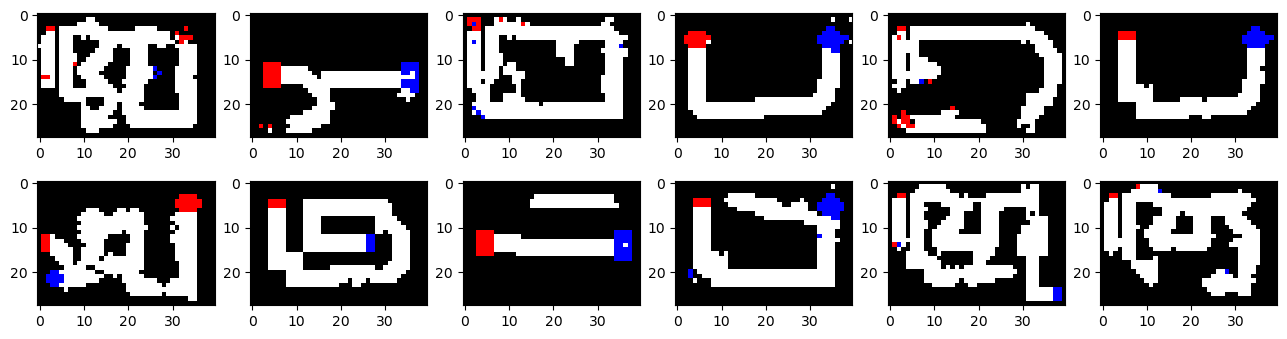

[5401/200]: loss_d: 0.000, loss_g: 3.749
[5402/200]: loss_d: 0.000, loss_g: 3.472
[5403/200]: loss_d: 0.000, loss_g: 3.792
[5404/200]: loss_d: 0.000, loss_g: 3.927
[5405/200]: loss_d: 0.000, loss_g: 3.804
[5406/200]: loss_d: 0.000, loss_g: 3.488
[5407/200]: loss_d: 0.000, loss_g: 3.752
[5408/200]: loss_d: 0.000, loss_g: 3.887
[5409/200]: loss_d: 0.000, loss_g: 3.717
[5410/200]: loss_d: 0.000, loss_g: 3.728
[5411/200]: loss_d: 0.000, loss_g: 3.482
[5412/200]: loss_d: 0.000, loss_g: 3.360
[5413/200]: loss_d: 0.000, loss_g: 3.666
[5414/200]: loss_d: 0.000, loss_g: 3.513
[5415/200]: loss_d: 0.000, loss_g: 3.931
[5416/200]: loss_d: 0.000, loss_g: 3.274
[5417/200]: loss_d: 0.000, loss_g: 3.830
[5418/200]: loss_d: 0.000, loss_g: 3.989
[5419/200]: loss_d: 0.000, loss_g: 3.844
[5420/200]: loss_d: 0.000, loss_g: 3.797
[5421/200]: loss_d: 0.000, loss_g: 3.611
[5422/200]: loss_d: 0.000, loss_g: 3.243
[5423/200]: loss_d: 0.000, loss_g: 3.076
[5424/200]: loss_d: 0.000, loss_g: 3.589
[5425/200]: loss

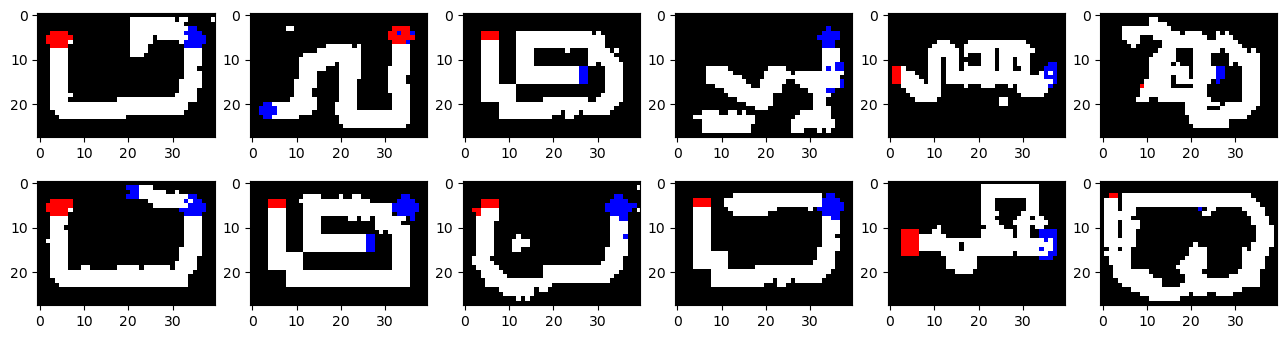

[5501/200]: loss_d: 0.000, loss_g: 3.857
[5502/200]: loss_d: 0.007, loss_g: 2.569
[5503/200]: loss_d: 0.000, loss_g: 2.603
[5504/200]: loss_d: 0.000, loss_g: 3.247
[5505/200]: loss_d: 0.000, loss_g: 3.400
[5506/200]: loss_d: 0.000, loss_g: 2.595
[5507/200]: loss_d: 0.000, loss_g: 2.697
[5508/200]: loss_d: 0.000, loss_g: 2.349
[5509/200]: loss_d: 0.011, loss_g: 3.022
[5510/200]: loss_d: 0.000, loss_g: 4.320
[5511/200]: loss_d: 0.000, loss_g: 4.387
[5512/200]: loss_d: 0.019, loss_g: 3.364
[5513/200]: loss_d: 0.019, loss_g: 2.839
[5514/200]: loss_d: 0.010, loss_g: 2.987
[5515/200]: loss_d: 0.022, loss_g: 3.025
[5516/200]: loss_d: 0.000, loss_g: 3.832
[5517/200]: loss_d: 0.000, loss_g: 3.872
[5518/200]: loss_d: 0.000, loss_g: 3.863
[5519/200]: loss_d: 0.000, loss_g: 4.411
[5520/200]: loss_d: 0.000, loss_g: 3.506
[5521/200]: loss_d: 0.001, loss_g: 3.586
[5522/200]: loss_d: 0.000, loss_g: 3.220
[5523/200]: loss_d: 0.000, loss_g: 3.309
[5524/200]: loss_d: 0.000, loss_g: 3.357
[5525/200]: loss

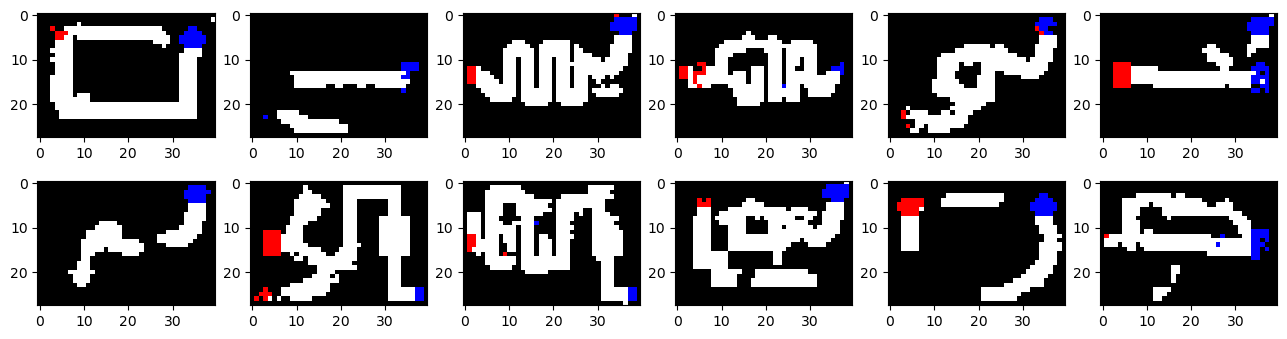

[5601/200]: loss_d: 0.014, loss_g: 3.360
[5602/200]: loss_d: 0.000, loss_g: 2.626
[5603/200]: loss_d: 0.000, loss_g: 2.838
[5604/200]: loss_d: 0.022, loss_g: 3.758
[5605/200]: loss_d: 0.037, loss_g: 3.159
[5606/200]: loss_d: 0.027, loss_g: 3.365
[5607/200]: loss_d: 0.000, loss_g: 3.409
[5608/200]: loss_d: 0.008, loss_g: 3.280
[5609/200]: loss_d: 0.000, loss_g: 2.982
[5610/200]: loss_d: 0.000, loss_g: 2.626
[5611/200]: loss_d: 0.000, loss_g: 2.907
[5612/200]: loss_d: 0.000, loss_g: 3.357
[5613/200]: loss_d: 0.000, loss_g: 3.251
[5614/200]: loss_d: 0.000, loss_g: 2.877
[5615/200]: loss_d: 0.007, loss_g: 3.236
[5616/200]: loss_d: 0.000, loss_g: 3.785
[5617/200]: loss_d: 0.000, loss_g: 3.416
[5618/200]: loss_d: 0.000, loss_g: 3.193
[5619/200]: loss_d: 0.000, loss_g: 3.497
[5620/200]: loss_d: 0.000, loss_g: 3.742
[5621/200]: loss_d: 0.000, loss_g: 3.135
[5622/200]: loss_d: 0.000, loss_g: 3.648
[5623/200]: loss_d: 0.000, loss_g: 3.815
[5624/200]: loss_d: 0.000, loss_g: 3.007
[5625/200]: loss

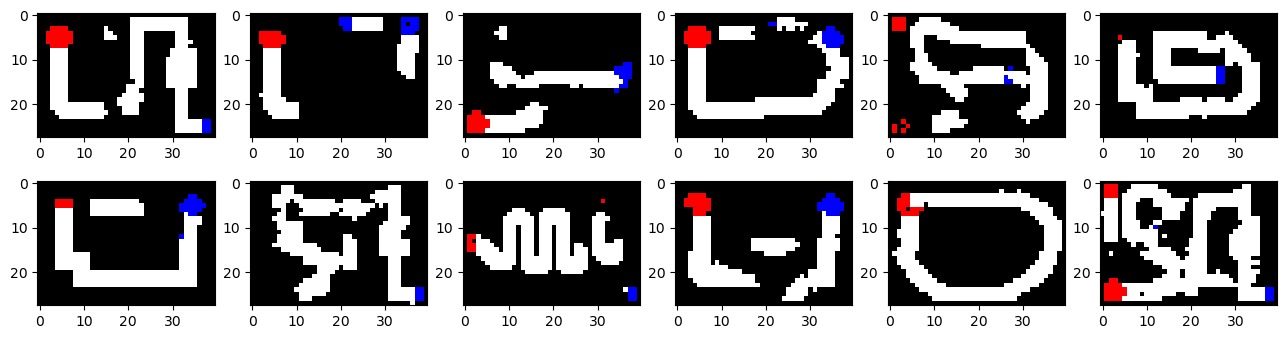

[5701/200]: loss_d: 0.000, loss_g: 4.003
[5702/200]: loss_d: 0.000, loss_g: 3.815
[5703/200]: loss_d: 0.000, loss_g: 3.836
[5704/200]: loss_d: 0.000, loss_g: 3.881
[5705/200]: loss_d: 0.000, loss_g: 3.960
[5706/200]: loss_d: 0.000, loss_g: 3.452
[5707/200]: loss_d: 0.000, loss_g: 3.703
[5708/200]: loss_d: 0.000, loss_g: 3.919
[5709/200]: loss_d: 0.000, loss_g: 3.550
[5710/200]: loss_d: 0.026, loss_g: 3.463
[5711/200]: loss_d: 0.046, loss_g: 2.277
[5712/200]: loss_d: 0.176, loss_g: 3.100
[5713/200]: loss_d: 0.028, loss_g: 4.233
[5714/200]: loss_d: 0.031, loss_g: 3.537
[5715/200]: loss_d: 0.000, loss_g: 3.020
[5716/200]: loss_d: 0.006, loss_g: 3.220
[5717/200]: loss_d: 0.009, loss_g: 3.234
[5718/200]: loss_d: 0.000, loss_g: 2.944
[5719/200]: loss_d: 0.001, loss_g: 2.741
[5720/200]: loss_d: 0.008, loss_g: 3.061
[5721/200]: loss_d: 0.000, loss_g: 3.956
[5722/200]: loss_d: 0.007, loss_g: 3.223
[5723/200]: loss_d: 0.000, loss_g: 3.150
[5724/200]: loss_d: 0.000, loss_g: 3.185
[5725/200]: loss

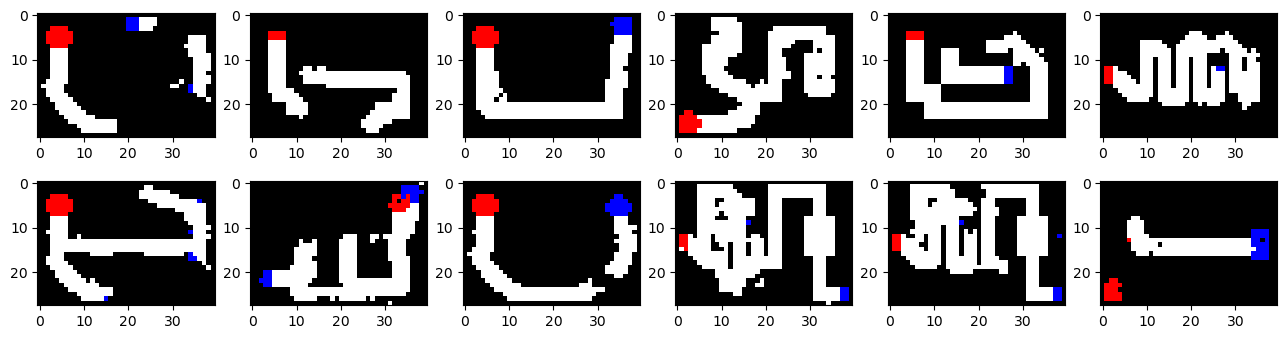

[5801/200]: loss_d: 0.000, loss_g: 3.673
[5802/200]: loss_d: 0.000, loss_g: 3.377
[5803/200]: loss_d: 0.000, loss_g: 3.785
[5804/200]: loss_d: 0.000, loss_g: 3.238
[5805/200]: loss_d: 0.000, loss_g: 3.513
[5806/200]: loss_d: 0.000, loss_g: 3.179
[5807/200]: loss_d: 0.000, loss_g: 3.424
[5808/200]: loss_d: 0.000, loss_g: 2.836
[5809/200]: loss_d: 0.000, loss_g: 3.206
[5810/200]: loss_d: 0.000, loss_g: 3.417
[5811/200]: loss_d: 0.000, loss_g: 3.400
[5812/200]: loss_d: 0.000, loss_g: 3.135
[5813/200]: loss_d: 0.000, loss_g: 3.163
[5814/200]: loss_d: 0.000, loss_g: 3.659
[5815/200]: loss_d: 0.000, loss_g: 3.449
[5816/200]: loss_d: 0.000, loss_g: 3.611
[5817/200]: loss_d: 0.006, loss_g: 3.252
[5818/200]: loss_d: 0.000, loss_g: 4.136
[5819/200]: loss_d: 0.001, loss_g: 3.365
[5820/200]: loss_d: 0.000, loss_g: 3.527
[5821/200]: loss_d: 0.000, loss_g: 2.564
[5822/200]: loss_d: 0.000, loss_g: 2.692
[5823/200]: loss_d: 0.000, loss_g: 3.060
[5824/200]: loss_d: 0.000, loss_g: 3.075
[5825/200]: loss

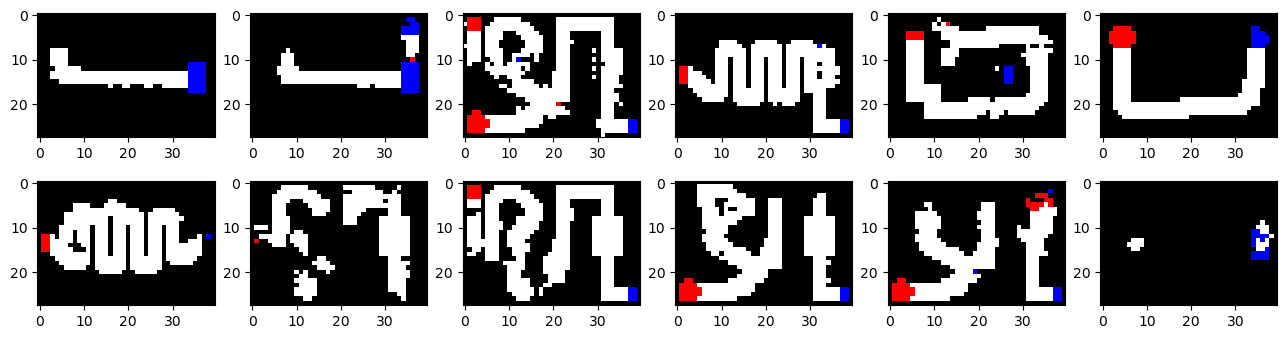

[5901/200]: loss_d: 0.000, loss_g: 3.444
[5902/200]: loss_d: 0.000, loss_g: 3.637
[5903/200]: loss_d: 0.000, loss_g: 4.090
[5904/200]: loss_d: 0.000, loss_g: 4.472
[5905/200]: loss_d: 0.000, loss_g: 3.909
[5906/200]: loss_d: 0.000, loss_g: 2.765
[5907/200]: loss_d: 0.000, loss_g: 3.778
[5908/200]: loss_d: 0.000, loss_g: 3.429
[5909/200]: loss_d: 0.000, loss_g: 3.474
[5910/200]: loss_d: 0.000, loss_g: 3.297
[5911/200]: loss_d: 0.000, loss_g: 3.328
[5912/200]: loss_d: 0.000, loss_g: 3.399
[5913/200]: loss_d: 0.001, loss_g: 3.177
[5914/200]: loss_d: 0.000, loss_g: 4.164
[5915/200]: loss_d: 0.000, loss_g: 4.181
[5916/200]: loss_d: 0.000, loss_g: 4.349
[5917/200]: loss_d: 0.000, loss_g: 4.379
[5918/200]: loss_d: 0.000, loss_g: 3.968
[5919/200]: loss_d: 0.000, loss_g: 4.431
[5920/200]: loss_d: 0.000, loss_g: 3.859
[5921/200]: loss_d: 0.000, loss_g: 3.975
[5922/200]: loss_d: 0.000, loss_g: 3.740
[5923/200]: loss_d: 0.000, loss_g: 3.810
[5924/200]: loss_d: 0.000, loss_g: 3.907
[5925/200]: loss

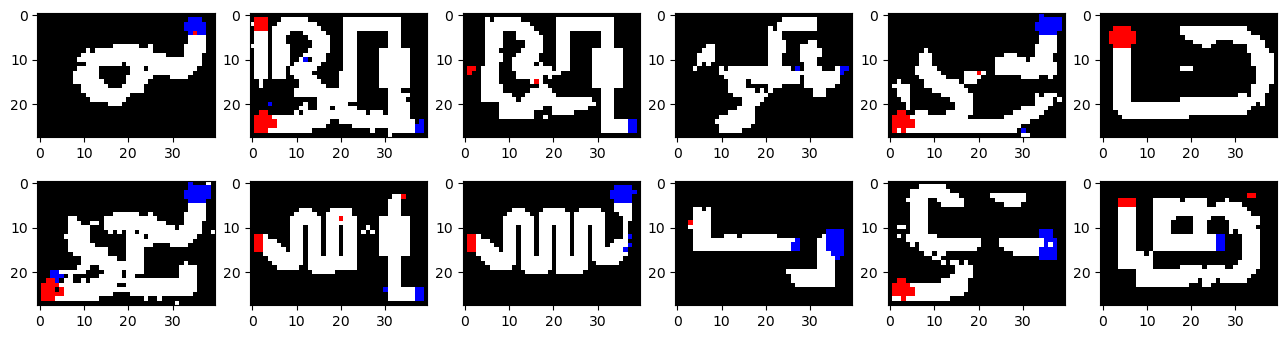

[6001/200]: loss_d: 0.000, loss_g: 3.360
[6002/200]: loss_d: 0.000, loss_g: 2.979
[6003/200]: loss_d: 0.000, loss_g: 3.437
[6004/200]: loss_d: 0.000, loss_g: 3.056
[6005/200]: loss_d: 0.006, loss_g: 3.360
[6006/200]: loss_d: 0.011, loss_g: 3.523
[6007/200]: loss_d: 0.000, loss_g: 4.220
[6008/200]: loss_d: 0.000, loss_g: 3.832
[6009/200]: loss_d: 0.000, loss_g: 3.354
[6010/200]: loss_d: 0.000, loss_g: 3.682
[6011/200]: loss_d: 0.000, loss_g: 3.149
[6012/200]: loss_d: 0.000, loss_g: 4.544
[6013/200]: loss_d: 0.000, loss_g: 4.086
[6014/200]: loss_d: 0.000, loss_g: 3.742
[6015/200]: loss_d: 0.000, loss_g: 3.907
[6016/200]: loss_d: 0.000, loss_g: 3.571
[6017/200]: loss_d: 0.000, loss_g: 3.371
[6018/200]: loss_d: 0.000, loss_g: 3.912
[6019/200]: loss_d: 0.000, loss_g: 3.501
[6020/200]: loss_d: 0.000, loss_g: 4.019
[6021/200]: loss_d: 0.000, loss_g: 3.429
[6022/200]: loss_d: 0.000, loss_g: 3.867
[6023/200]: loss_d: 0.000, loss_g: 3.530
[6024/200]: loss_d: 0.000, loss_g: 3.735
[6025/200]: loss

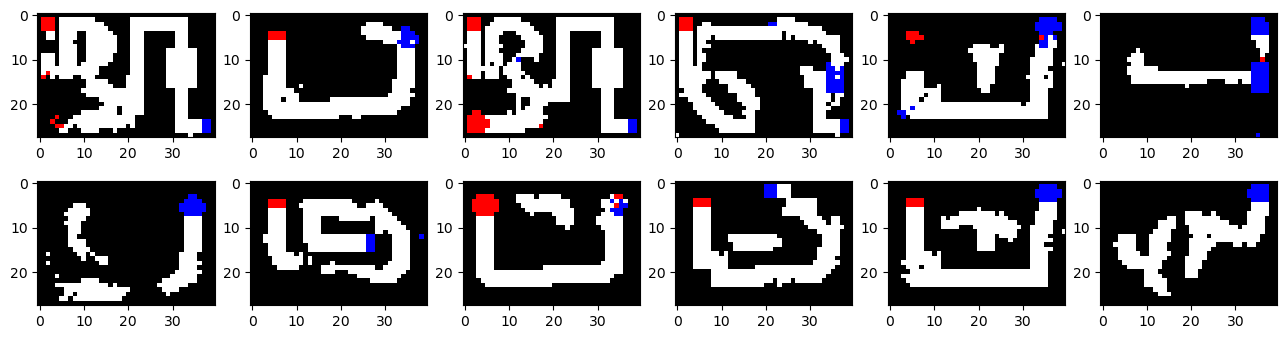

[6101/200]: loss_d: 0.000, loss_g: 3.555
[6102/200]: loss_d: 0.000, loss_g: 3.176
[6103/200]: loss_d: 0.004, loss_g: 3.421
[6104/200]: loss_d: 0.000, loss_g: 3.704
[6105/200]: loss_d: 0.000, loss_g: 4.146
[6106/200]: loss_d: 0.006, loss_g: 3.780
[6107/200]: loss_d: 0.000, loss_g: 3.302
[6108/200]: loss_d: 0.005, loss_g: 3.657
[6109/200]: loss_d: 0.000, loss_g: 3.662
[6110/200]: loss_d: 0.000, loss_g: 3.263
[6111/200]: loss_d: 0.000, loss_g: 3.395
[6112/200]: loss_d: 0.000, loss_g: 4.119
[6113/200]: loss_d: 0.000, loss_g: 3.312
[6114/200]: loss_d: 0.000, loss_g: 3.427
[6115/200]: loss_d: 0.000, loss_g: 3.561
[6116/200]: loss_d: 0.000, loss_g: 2.873
[6117/200]: loss_d: 0.000, loss_g: 3.524
[6118/200]: loss_d: 0.000, loss_g: 3.470
[6119/200]: loss_d: 0.000, loss_g: 3.675
[6120/200]: loss_d: 0.000, loss_g: 3.295
[6121/200]: loss_d: 0.000, loss_g: 3.180
[6122/200]: loss_d: 0.000, loss_g: 3.481
[6123/200]: loss_d: 0.008, loss_g: 3.108
[6124/200]: loss_d: 0.000, loss_g: 3.490
[6125/200]: loss

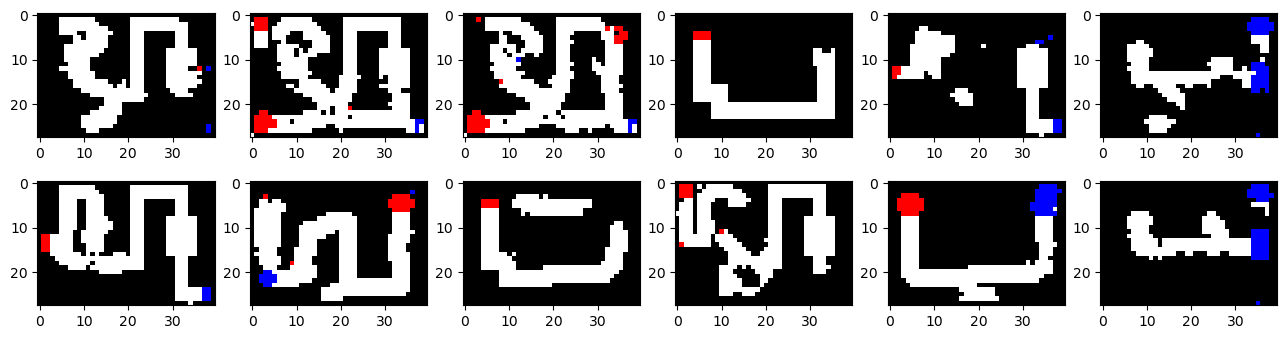

[6201/200]: loss_d: 0.000, loss_g: 4.507
[6202/200]: loss_d: 0.000, loss_g: 4.052
[6203/200]: loss_d: 0.000, loss_g: 3.438
[6204/200]: loss_d: 0.000, loss_g: 3.654
[6205/200]: loss_d: 0.000, loss_g: 3.805
[6206/200]: loss_d: 0.000, loss_g: 4.338
[6207/200]: loss_d: 0.000, loss_g: 4.005
[6208/200]: loss_d: 0.000, loss_g: 3.647
[6209/200]: loss_d: 0.000, loss_g: 3.917
[6210/200]: loss_d: 0.000, loss_g: 4.119
[6211/200]: loss_d: 0.000, loss_g: 3.782
[6212/200]: loss_d: 0.000, loss_g: 4.216
[6213/200]: loss_d: 0.000, loss_g: 4.031
[6214/200]: loss_d: 0.000, loss_g: 3.871
[6215/200]: loss_d: 0.000, loss_g: 3.623
[6216/200]: loss_d: 0.000, loss_g: 3.912
[6217/200]: loss_d: 0.000, loss_g: 3.793
[6218/200]: loss_d: 0.000, loss_g: 3.532
[6219/200]: loss_d: 0.000, loss_g: 3.163
[6220/200]: loss_d: 0.000, loss_g: 3.295
[6221/200]: loss_d: 0.000, loss_g: 3.949
[6222/200]: loss_d: 0.000, loss_g: 3.646
[6223/200]: loss_d: 0.000, loss_g: 4.248
[6224/200]: loss_d: 0.000, loss_g: 4.087
[6225/200]: loss

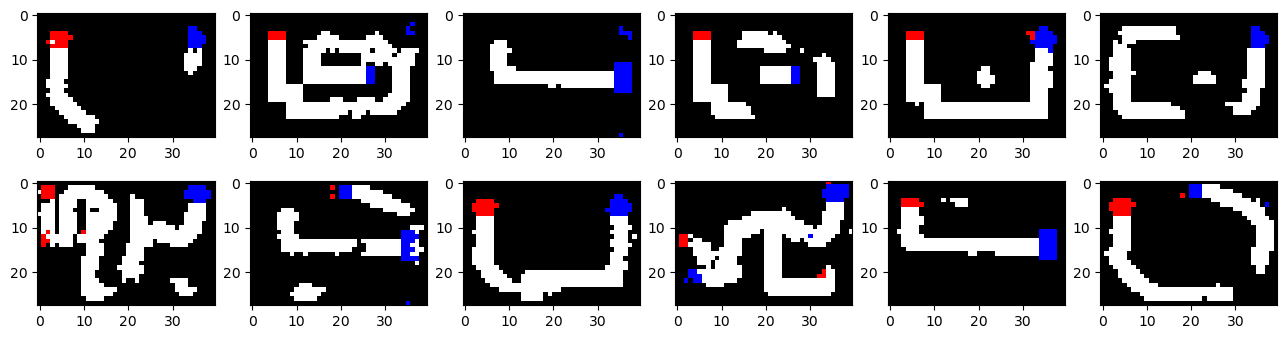

[6301/200]: loss_d: 0.000, loss_g: 4.062
[6302/200]: loss_d: 0.000, loss_g: 3.600
[6303/200]: loss_d: 0.000, loss_g: 3.676
[6304/200]: loss_d: 0.000, loss_g: 3.851
[6305/200]: loss_d: 0.000, loss_g: 4.302
[6306/200]: loss_d: 0.000, loss_g: 4.039
[6307/200]: loss_d: 0.000, loss_g: 3.449
[6308/200]: loss_d: 0.000, loss_g: 3.692
[6309/200]: loss_d: 0.000, loss_g: 3.998
[6310/200]: loss_d: 0.000, loss_g: 4.219
[6311/200]: loss_d: 0.000, loss_g: 4.332
[6312/200]: loss_d: 0.000, loss_g: 3.570
[6313/200]: loss_d: 0.000, loss_g: 3.864
[6314/200]: loss_d: 0.007, loss_g: 3.545
[6315/200]: loss_d: 0.000, loss_g: 4.259
[6316/200]: loss_d: 0.000, loss_g: 5.503
[6317/200]: loss_d: 0.000, loss_g: 3.918
[6318/200]: loss_d: 0.000, loss_g: 4.920
[6319/200]: loss_d: 0.001, loss_g: 3.429
[6320/200]: loss_d: 0.000, loss_g: 3.019
[6321/200]: loss_d: 0.008, loss_g: 3.287
[6322/200]: loss_d: 0.013, loss_g: 4.260
[6323/200]: loss_d: 0.033, loss_g: 4.424
[6324/200]: loss_d: 0.000, loss_g: 3.754
[6325/200]: loss

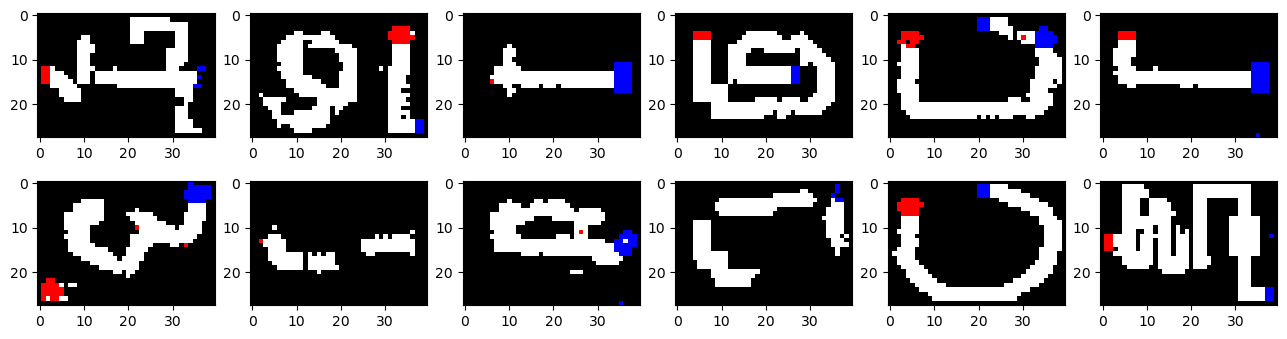

[6401/200]: loss_d: 0.000, loss_g: 3.678
[6402/200]: loss_d: 0.000, loss_g: 4.329
[6403/200]: loss_d: 0.000, loss_g: 3.840
[6404/200]: loss_d: 0.000, loss_g: 3.774
[6405/200]: loss_d: 0.000, loss_g: 3.875
[6406/200]: loss_d: 0.000, loss_g: 4.224
[6407/200]: loss_d: 0.000, loss_g: 3.722
[6408/200]: loss_d: 0.000, loss_g: 3.430
[6409/200]: loss_d: 0.000, loss_g: 3.821
[6410/200]: loss_d: 0.000, loss_g: 4.270
[6411/200]: loss_d: 0.000, loss_g: 4.578
[6412/200]: loss_d: 0.000, loss_g: 3.965
[6413/200]: loss_d: 0.000, loss_g: 4.124
[6414/200]: loss_d: 0.000, loss_g: 4.461
[6415/200]: loss_d: 0.000, loss_g: 4.027
[6416/200]: loss_d: 0.000, loss_g: 3.759
[6417/200]: loss_d: 0.000, loss_g: 3.958
[6418/200]: loss_d: 0.000, loss_g: 3.701
[6419/200]: loss_d: 0.000, loss_g: 4.649
[6420/200]: loss_d: 0.000, loss_g: 4.074
[6421/200]: loss_d: 0.000, loss_g: 3.590
[6422/200]: loss_d: 0.000, loss_g: 4.213
[6423/200]: loss_d: 0.000, loss_g: 3.473
[6424/200]: loss_d: 0.000, loss_g: 4.023
[6425/200]: loss

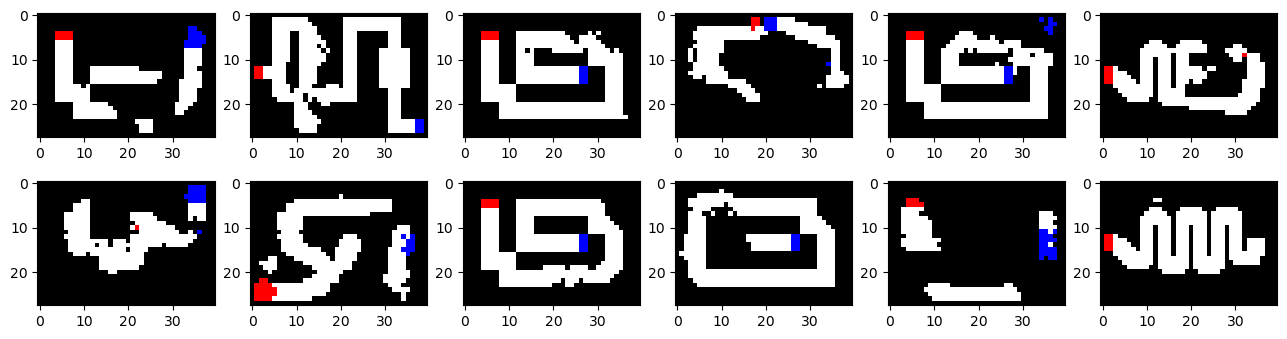

[6501/200]: loss_d: 0.000, loss_g: 4.450
[6502/200]: loss_d: 0.000, loss_g: 3.089
[6503/200]: loss_d: 0.000, loss_g: 3.531
[6504/200]: loss_d: 0.000, loss_g: 3.561
[6505/200]: loss_d: 0.000, loss_g: 3.570
[6506/200]: loss_d: 0.000, loss_g: 4.063
[6507/200]: loss_d: 0.000, loss_g: 3.684
[6508/200]: loss_d: 0.000, loss_g: 3.684
[6509/200]: loss_d: 0.044, loss_g: 4.986
[6510/200]: loss_d: 0.237, loss_g: 0.749
[6511/200]: loss_d: 0.723, loss_g: 6.256
[6512/200]: loss_d: 2.546, loss_g: 0.156
[6513/200]: loss_d: 0.906, loss_g: 4.588
[6514/200]: loss_d: 0.928, loss_g: 1.556
[6515/200]: loss_d: 0.672, loss_g: 3.163
[6516/200]: loss_d: 0.211, loss_g: 2.597
[6517/200]: loss_d: 0.174, loss_g: 4.038
[6518/200]: loss_d: 0.520, loss_g: 0.406
[6519/200]: loss_d: 0.632, loss_g: 3.090
[6520/200]: loss_d: 0.020, loss_g: 3.504
[6521/200]: loss_d: 0.003, loss_g: 3.467
[6522/200]: loss_d: 0.040, loss_g: 2.883
[6523/200]: loss_d: 0.000, loss_g: 3.484
[6524/200]: loss_d: 0.002, loss_g: 3.121
[6525/200]: loss

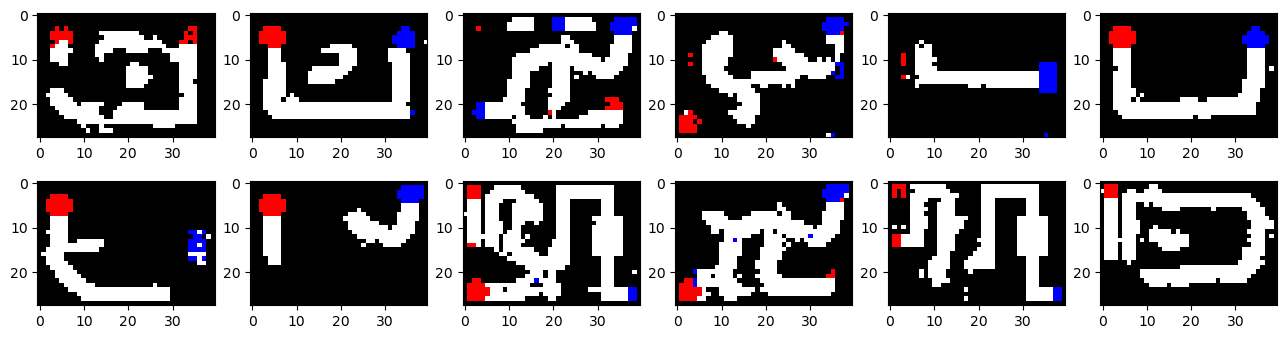

[6601/200]: loss_d: 0.000, loss_g: 4.245
[6602/200]: loss_d: 0.000, loss_g: 4.157
[6603/200]: loss_d: 0.000, loss_g: 3.942
[6604/200]: loss_d: 0.000, loss_g: 3.958
[6605/200]: loss_d: 0.000, loss_g: 3.908
[6606/200]: loss_d: 0.000, loss_g: 3.035
[6607/200]: loss_d: 0.000, loss_g: 3.470
[6608/200]: loss_d: 0.000, loss_g: 3.732
[6609/200]: loss_d: 0.000, loss_g: 3.732
[6610/200]: loss_d: 0.000, loss_g: 4.075
[6611/200]: loss_d: 0.000, loss_g: 3.834
[6612/200]: loss_d: 0.000, loss_g: 3.859
[6613/200]: loss_d: 0.000, loss_g: 3.851
[6614/200]: loss_d: 0.000, loss_g: 3.919
[6615/200]: loss_d: 0.000, loss_g: 3.663
[6616/200]: loss_d: 0.000, loss_g: 4.297
[6617/200]: loss_d: 0.000, loss_g: 3.605
[6618/200]: loss_d: 0.000, loss_g: 3.714
[6619/200]: loss_d: 0.000, loss_g: 3.411
[6620/200]: loss_d: 0.000, loss_g: 3.995
[6621/200]: loss_d: 0.000, loss_g: 3.689
[6622/200]: loss_d: 0.000, loss_g: 3.344
[6623/200]: loss_d: 0.000, loss_g: 3.398
[6624/200]: loss_d: 0.000, loss_g: 3.589
[6625/200]: loss

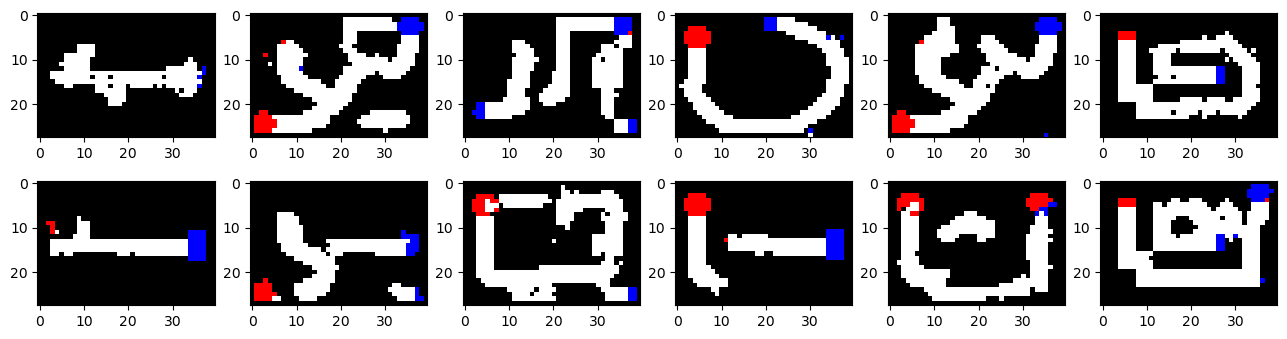

[6701/200]: loss_d: 0.000, loss_g: 4.491
[6702/200]: loss_d: 0.049, loss_g: 3.578
[6703/200]: loss_d: 0.000, loss_g: 3.631
[6704/200]: loss_d: 0.242, loss_g: 3.919
[6705/200]: loss_d: 0.021, loss_g: 4.600
[6706/200]: loss_d: 0.090, loss_g: 4.720
[6707/200]: loss_d: 0.000, loss_g: 4.701
[6708/200]: loss_d: 0.001, loss_g: 4.077
[6709/200]: loss_d: 0.000, loss_g: 3.827
[6710/200]: loss_d: 0.000, loss_g: 3.481
[6711/200]: loss_d: 0.000, loss_g: 4.290
[6712/200]: loss_d: 0.000, loss_g: 3.485
[6713/200]: loss_d: 0.000, loss_g: 3.956
[6714/200]: loss_d: 0.000, loss_g: 3.987
[6715/200]: loss_d: 0.000, loss_g: 3.740
[6716/200]: loss_d: 0.000, loss_g: 3.296
[6717/200]: loss_d: 0.000, loss_g: 3.912
[6718/200]: loss_d: 0.000, loss_g: 4.076
[6719/200]: loss_d: 0.000, loss_g: 3.816
[6720/200]: loss_d: 0.000, loss_g: 3.929
[6721/200]: loss_d: 0.000, loss_g: 3.839
[6722/200]: loss_d: 0.000, loss_g: 3.630
[6723/200]: loss_d: 0.000, loss_g: 3.415
[6724/200]: loss_d: 0.000, loss_g: 3.932
[6725/200]: loss

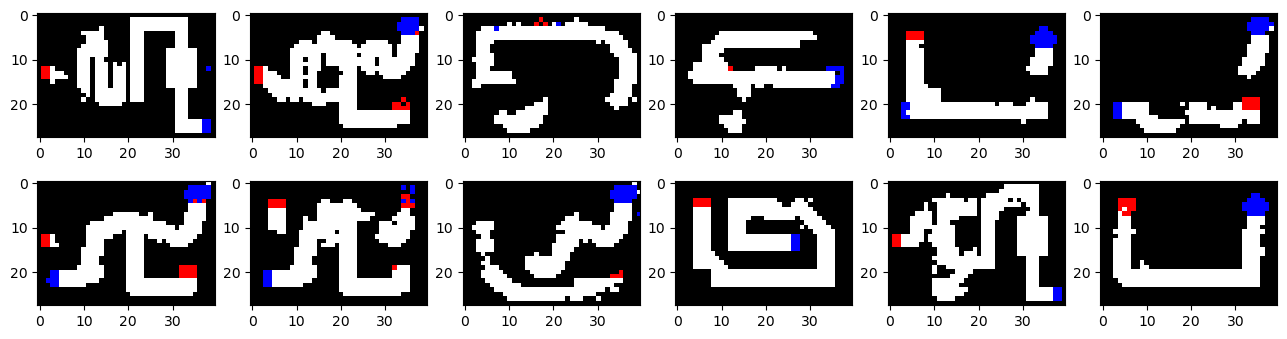

[6801/200]: loss_d: 0.000, loss_g: 3.414
[6802/200]: loss_d: 0.000, loss_g: 3.361
[6803/200]: loss_d: 0.000, loss_g: 3.364
[6804/200]: loss_d: 0.000, loss_g: 3.616
[6805/200]: loss_d: 0.000, loss_g: 3.621
[6806/200]: loss_d: 0.000, loss_g: 3.486
[6807/200]: loss_d: 0.000, loss_g: 4.217
[6808/200]: loss_d: 0.000, loss_g: 3.849
[6809/200]: loss_d: 0.000, loss_g: 3.726
[6810/200]: loss_d: 0.000, loss_g: 4.041
[6811/200]: loss_d: 0.000, loss_g: 3.452
[6812/200]: loss_d: 0.000, loss_g: 3.599
[6813/200]: loss_d: 0.000, loss_g: 4.087
[6814/200]: loss_d: 0.000, loss_g: 3.898
[6815/200]: loss_d: 0.000, loss_g: 3.736
[6816/200]: loss_d: 0.000, loss_g: 3.953
[6817/200]: loss_d: 0.000, loss_g: 3.900
[6818/200]: loss_d: 0.000, loss_g: 3.218
[6819/200]: loss_d: 0.000, loss_g: 3.894
[6820/200]: loss_d: 0.000, loss_g: 2.990
[6821/200]: loss_d: 0.000, loss_g: 3.851
[6822/200]: loss_d: 0.000, loss_g: 3.739
[6823/200]: loss_d: 0.000, loss_g: 3.308
[6824/200]: loss_d: 0.000, loss_g: 3.373
[6825/200]: loss

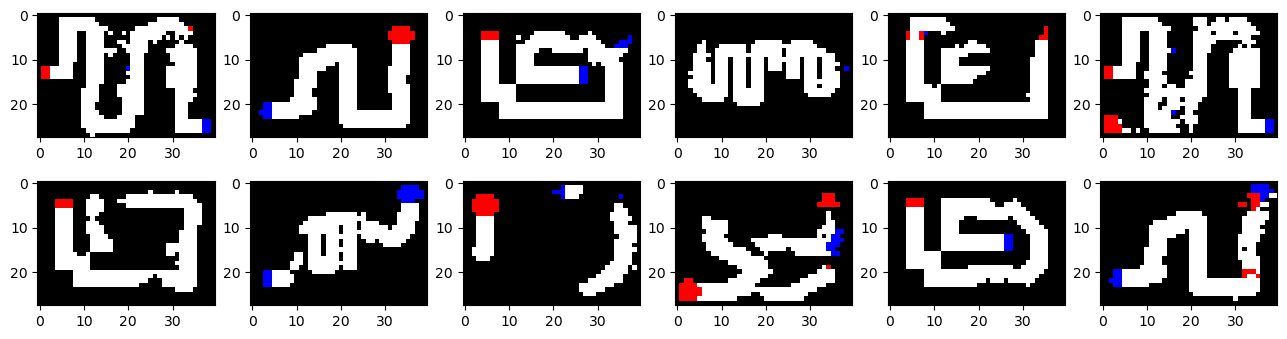

[6901/200]: loss_d: 0.000, loss_g: 3.730
[6902/200]: loss_d: 0.000, loss_g: 3.598
[6903/200]: loss_d: 0.000, loss_g: 3.265
[6904/200]: loss_d: 0.000, loss_g: 4.428
[6905/200]: loss_d: 0.000, loss_g: 3.533
[6906/200]: loss_d: 0.000, loss_g: 3.438
[6907/200]: loss_d: 0.000, loss_g: 3.555
[6908/200]: loss_d: 0.000, loss_g: 4.154
[6909/200]: loss_d: 0.000, loss_g: 2.872
[6910/200]: loss_d: 0.000, loss_g: 4.057
[6911/200]: loss_d: 0.000, loss_g: 3.949
[6912/200]: loss_d: 0.000, loss_g: 3.417
[6913/200]: loss_d: 0.000, loss_g: 3.438
[6914/200]: loss_d: 0.000, loss_g: 3.534
[6915/200]: loss_d: 0.000, loss_g: 3.805
[6916/200]: loss_d: 0.000, loss_g: 3.294
[6917/200]: loss_d: 0.011, loss_g: 4.029
[6918/200]: loss_d: 0.000, loss_g: 3.930
[6919/200]: loss_d: 0.051, loss_g: 3.286
[6920/200]: loss_d: 0.004, loss_g: 2.715
[6921/200]: loss_d: 0.078, loss_g: 3.646
[6922/200]: loss_d: 0.022, loss_g: 2.935
[6923/200]: loss_d: 0.000, loss_g: 3.166
[6924/200]: loss_d: 0.000, loss_g: 3.107
[6925/200]: loss

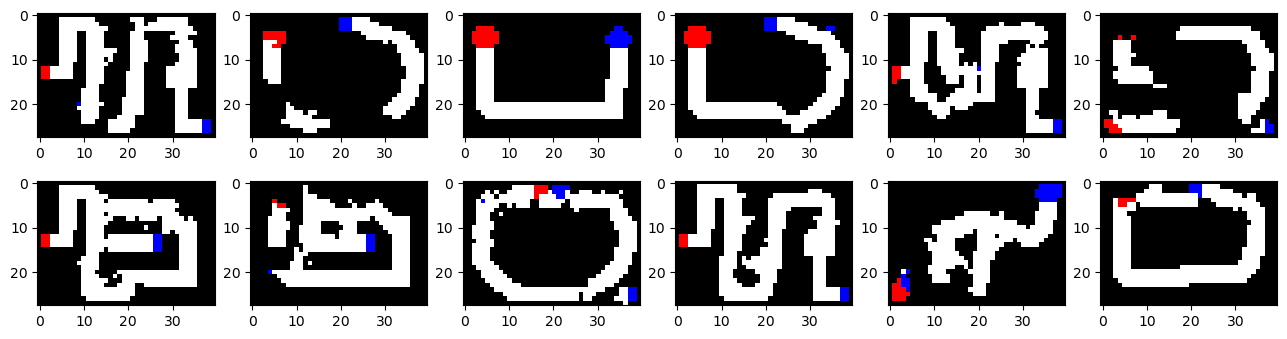

In [27]:
for epoch in range(0, 7000+1):           
    D_losses, G_losses = [], []
    x = data
    
    # _______Discriminator____________
    if epoch % d_step == 0:
        D.zero_grad()

        x_real, y_real = x.to(device), torch.ones(bs, 1).to(device)

        D_output = D(x_real)
        D_loss_real = torch.nn.ReLU()(1.0 - D_output.view(-1).reshape(bs, 1)).mean()

        z = torch.randn((bs, z_dim, 1, 1)).to(device)
        x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)
        D_output = D(x_fake)
        D_fake_loss = torch.nn.ReLU()(1.0 + D_output.view(-1).reshape(bs, 1)).mean()

        D_loss = D_loss_real + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_losses.append(D_loss.item())

    # _______Generator____________
    G.zero_grad()
    z = torch.randn(100, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = -D_output.view(-1).reshape(bs, 1).mean()
    G_loss.backward()
    G_optimizer.step() 
    G_losses.append(G_loss.item())

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), 200, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    if epoch % 100 == 0:
        with torch.no_grad():
            fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 4))

            a = G_output.argmax(dim=1).cpu().detach()
            for i, ax in enumerate(axes.flat):
                image = create_image_from_array(a[i])
                ax.imshow(image)

            plt.show()

In [29]:
torch.save(G.state_dict(), 'models/sagan2.pt')

In [30]:
mygen = Generator(z_dim, 4)
mygen.load_state_dict(torch.load('models/sagan2.pt', weights_only=True))
mygen.eval()

Generator(
  (seq): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(7, 10), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Self_Attn(
      (query_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1

In [31]:
a = mygen(torch.randn((1000, 100, 1, 1))).argmax(dim=1)
for i in range(1000):
    if i % 100 == 0:
        print(i)
    image = create_image_from_array(a[i])
    image.save('generated_levels/sagan2/{}.png'.format(i))

0
100
200
300
400
500
600
700
800
900
